# Определение стоимости автомобилей

На основании исторические данных (технические характеристики, комплектации и цены автомобилей), построить модель для определения стоимости.

Важны:
- качество предсказания;
- скорость предсказания;
- время обучения.

Значения столбцов датасета:
- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `NotRepaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя
- `Price` — цена (евро).

## 1.  Подготовка данных

### 1.1.  Общая информация

In [1]:
# Перед импортом lightgbm и catboost в локальную тетрадь, необходимо сначала установить их через Anaconda Prompt:
# pip install lightgbm
# pip install catboost

import time
from tqdm import tqdm # Для прогресс-бара выполнения кода ячейки.
from warnings import simplefilter # Сокращает сообщения Jupiter.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, RepeatedKFold
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, make_scorer, mean_squared_error

from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor, Pool

In [3]:
df = pd.read_csv('datasets/autos.csv')

In [4]:
df.info()
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Соберем информацию о столбцах датасета и проверим, целесообразно ли мы кодировать категориальные признаки или лучше их удалить (например, если их много и это импактит скорость модели).

In [5]:
# Создадим переменную для хранения размера изначального датасета.
df_init_shape = df.shape
df.shape

(354369, 16)

In [6]:
print('\033[1m' + 'Пропусков в столбцах, %:' + '\033[0m')
for col in df.columns:
    if df[col].isna().sum() > 0:
        print(col, np.round_((df[col].isna().sum() / df.shape[0])*100))

print('\033[1m' + '\nВариантов значений категориальных признаков:' + '\033[0m')

for col in df.columns:
    if col == 'VehicleType' or col == 'Gearbox'or col == 'Model' or col == 'FuelType' or col == 'Brand':
        print(col, len(list(df[col].value_counts())))

    
print('\033[1m' + '\nДубликатов строк:' + '\033[0m', df.duplicated().sum())

Пропусков в столбцах, %:
VehicleType 11.0
Gearbox 6.0
Model 6.0
FuelType 9.0
NotRepaired 20.0

Вариантов значений категориальных признаков:
VehicleType 8
Gearbox 2
Model 250
FuelType 7
Brand 40

Дубликатов строк: 4


Назовем колонки более компактно.

In [7]:
df = df.rename(columns={'DateCrawled':'dt_crawled',
                       'Price':'price',
                       'VehicleType':'veh_type',
                       'RegistrationYear':'reg_year',
                       'Gearbox':'gearbox',
                       'Power':'power',
                       'Model':'model',
                       'Kilometer':'km',
                       'RegistrationMonth':'reg_month',
                       'FuelType':'fuel',
                       'Brand':'brand',
                       'NotRepaired':'is_repaired',
                       'DateCreated':'dt_created',
                       'NumberOfPictures':'pic_cnt',
                       'PostalCode':'zip_cde',
                       'LastSeen':'dt_last_seen'
                      })

Text(0.5, 1.0, 'Корреляционная матрица')

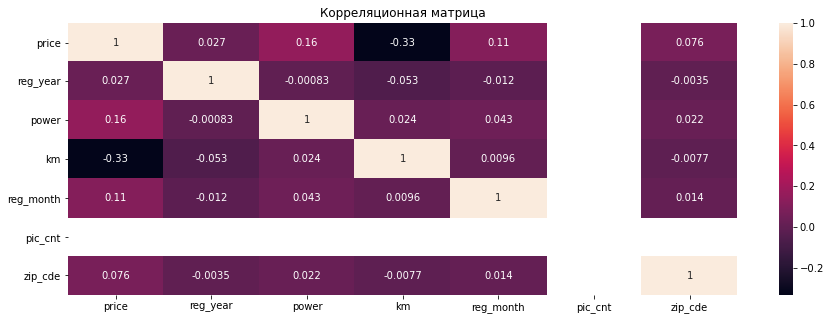

In [8]:
plt.figure(figsize=(15,5))
corr_matrix = sns.heatmap(df.corr(),annot=True)
corr_matrix.axes.set_title("Корреляционная матрица")

Наиболее сильная корреляция наблюдается у цены и пробега (обратная, -0,33), остальные факторы имею гораздо мееьший вклад.

**Вывод**

Необходимые библиотеки и данные загружены; получена общая информация о столбцах датасета, а также проведена первичная оценка корреляции признаков.

### 1.2. Анализ данных

#### 1.2.1.  Количественные признаки

Рассмотрим распределение количественных признаков, к таковым относятся: `price`, `power`, `km`, `reg_year`.

In [10]:
# Функция для построения гистограмм и диаграммы размаха.

def boxplot_values(data_frame, item):
    upper_quartile = data_frame[item].quantile(0.75)
    lower_quartile = data_frame[item].quantile(0.25)
    median = data_frame[item].median()
    mean = data_frame[item].mean()
    iqr = upper_quartile - lower_quartile
    upper_whisker = data_frame[item][data_frame[item] <= upper_quartile + 1.5 * iqr].max()
    lower_whisker = data_frame[item][data_frame[item] >= lower_quartile - 1.5 * iqr].min()
    print('25-й процентиль:', lower_quartile)
    print('75-й процентиль:', upper_quartile)
    print('Медиана: ', median)
    print('Среднее: ', mean)
    print('Нижний ус:', lower_whisker)
    print('Верхний ус:', upper_whisker)

def hist_boxplot(data_frame, item):
    data_frame[item].hist(bins=200, figsize=(15, 5)).set(xlabel=item, ylabel='Частота');
    plt.show()
    data_frame.boxplot(column=item, vert=False, figsize=(15,3)).set(xlabel='Частота');
    boxplot_values(data_frame, item)

Начнем с <b><u>цен на автомобили</u></b>.

In [12]:
print('Число объявлений с нулевой ценой:', df.loc[(df['price'] == 0)]['price'].count())

Число объявлений с нулевой ценой: 10772


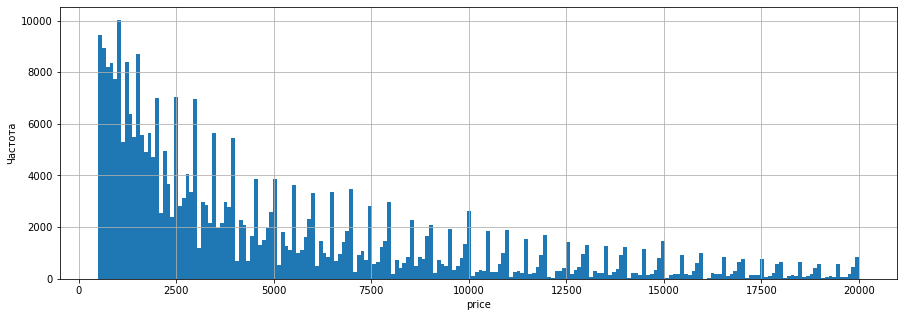

25-й процентиль: 1499.0
75-й процентиль: 6950.0
Медиана:  3200.0
Среднее:  4895.083203744718
Нижний ус: 500
Верхний ус: 15120


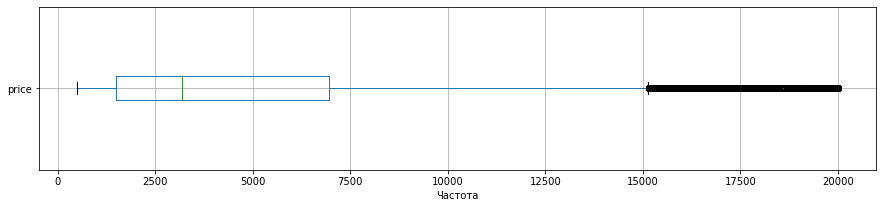

In [13]:
# Уберем из датасета объявления, со значением цены 0 евро и построим распределения.
df = df.loc[(df['price'] >= 500)]

hist_boxplot(df, 'price')

Большинство автомобилей лежит в диапазоне до 7000 евро. Распределение цены - пуассоновское. 

Проверим распределение по <b><u>мощности двигателя</u></b>.

In [14]:
print('Автомобилей с мощностью менее 10 л/с', df.loc[(df['power'] <10)]['power'].count())
print('Автомобилей с мощностью более 250 л/с', df.loc[(df['power'] > 250)]['power'].count())

Автомобилей с мощностью менее 10 л/с 28855
Автомобилей с мощностью более 250 л/с 7134


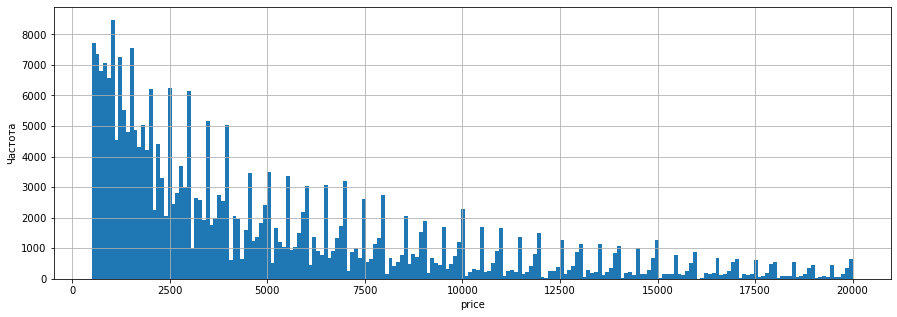

25-й процентиль: 1500.0
75-й процентиль: 6990.0
Медиана:  3350.0
Среднее:  4936.141372030915
Нижний ус: 500
Верхний ус: 15222


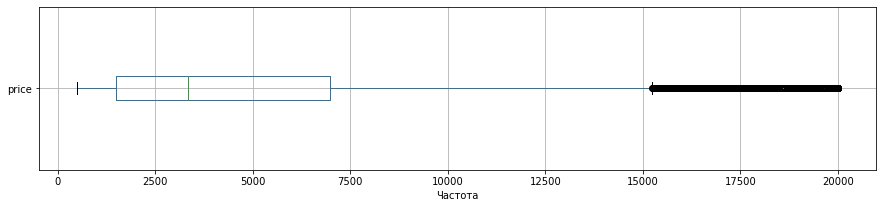

In [15]:
# Уберем из датасета объявления, с мощностью двигателя менее 10 и более 250 л/с и посмотрим на распределение.
df = df.loc[(df['power'] >= 10) & (df['power'] <= 250)]

hist_boxplot(df, 'price')

Распределение мощностей двигателей нормальное, основаная масса находится в диапазоне от 75 до 143 л.с.

Проверим колонку с <b><u>пробегом автомобилей</u></b>.

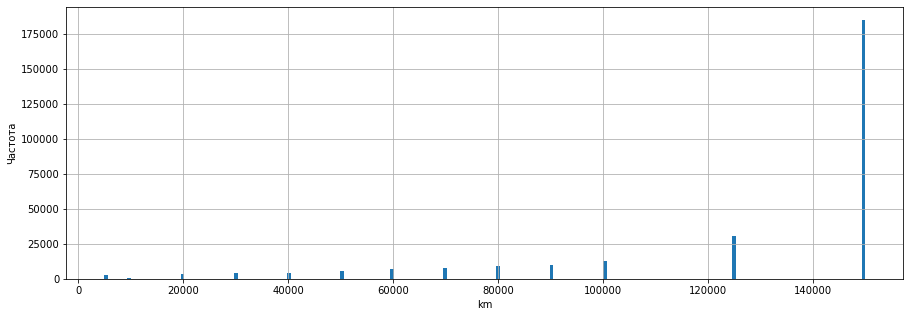

25-й процентиль: 125000.0
75-й процентиль: 150000.0
Медиана:  150000.0
Среднее:  127761.08116149416
Нижний ус: 90000
Верхний ус: 150000


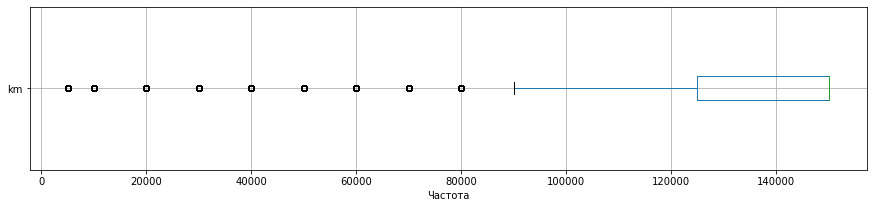

In [16]:
hist_boxplot(df, 'km')

Авто с пообегом ниже среднего (128 тыс. км.) значительно меньше выставляются на продажу.

Проверим колонку с <b><u>годом регистрации автомобилей</b></u>.

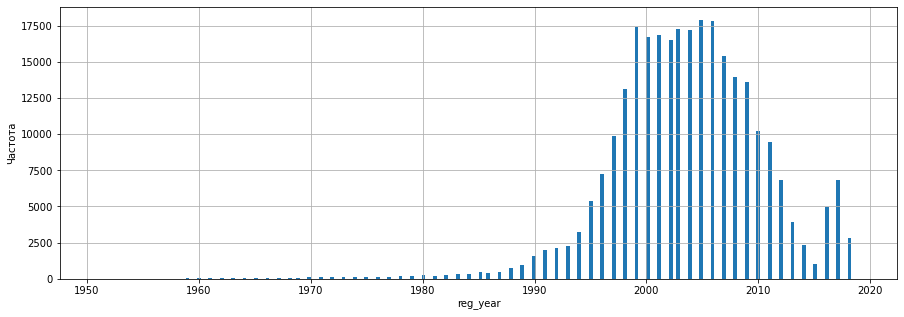

25-й процентиль: 2000.0
75-й процентиль: 2008.0
Медиана:  2004.0
Среднее:  2003.5740047261559
Нижний ус: 1988
Верхний ус: 2019


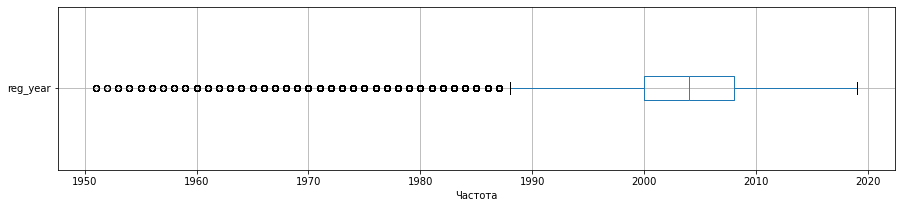

In [17]:
hist_boxplot(df[(df['reg_year']>1950) & (df['reg_year']<2022)], 'reg_year')

Основная масса автомобилей, наодящихся между 25-м и 75-м процентилями регистрировались с 1986 по 2019 гг. В целом, распределение нормальное с провалом значений между 2010 и 2015 гг. и последующим всплеском в 2016-2017 гг. Может юыть, ошика в системе хранения/выгрузки данных.

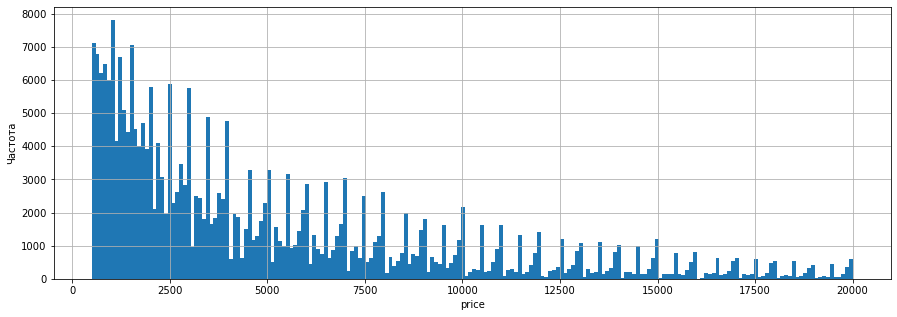

25-й процентиль: 1500.0
75-й процентиль: 7000.0
Медиана:  3450.0
Среднее:  4996.070756475279
Нижний ус: 500
Верхний ус: 15250


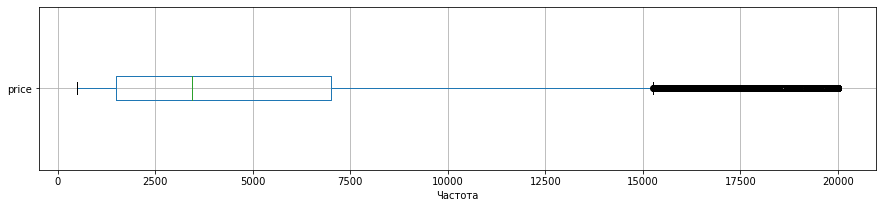

In [18]:
# Уберем из датасета значения до 1980 года и после 2015 года.
df = df.loc[(df['reg_year'] >= 1980) & (df['reg_year'] <= 2015)]

hist_boxplot(df, 'price')

#### 1.2.2. Категориальные признаки

Перейдем к категориальным признакам, среди которых рассмотрим `veh_type`, `gearbox`, `model`, `brand`, `is_repaired`, `zip_cde`.
<br>Начнем с <b><u>типа кузова</u></b>.

In [31]:
# Функция для построения гисторграмм.

def categorical(df, item, h_kind, h_title):
    df[item].value_counts().plot(kind=h_kind,
                                figsize=(15,5),
                                title=h_title,
                                xlabel=item,
                                ylabel='Частота')

0.7410335923226267

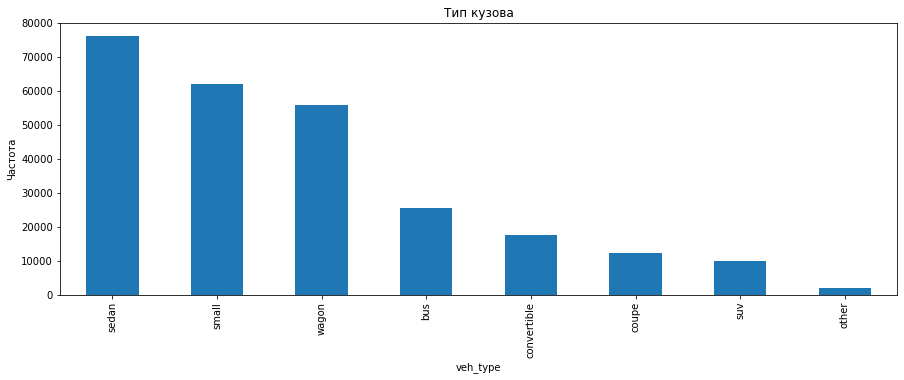

In [32]:
categorical(df, 'veh_type', 'bar', 'Тип кузова')
df.query('veh_type == "sedan" | veh_type == "small" | veh_type == "wagon"')['veh_type'].count()/df['veh_type'].count()

В топе sedan, small и wagon, на них приходится 75% всех типов кузова.

Рассмотрим распределение типа <b><u>коробки передач</u></b>.

manual    0.802497
auto      0.197503
Name: gearbox, dtype: float64


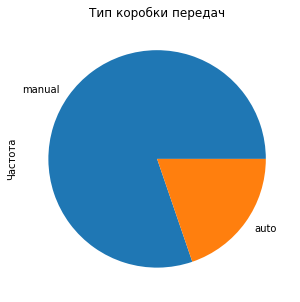

In [21]:
categorical(df, 'gearbox', 'pie', 'Тип коробки передач')

print(df['gearbox'].value_counts()/df['gearbox'].count())

80% автовладельцев предпочитают "механику".

Рассмотрим распределение автомобилей по <u><b>маркам производителя</b><u>.

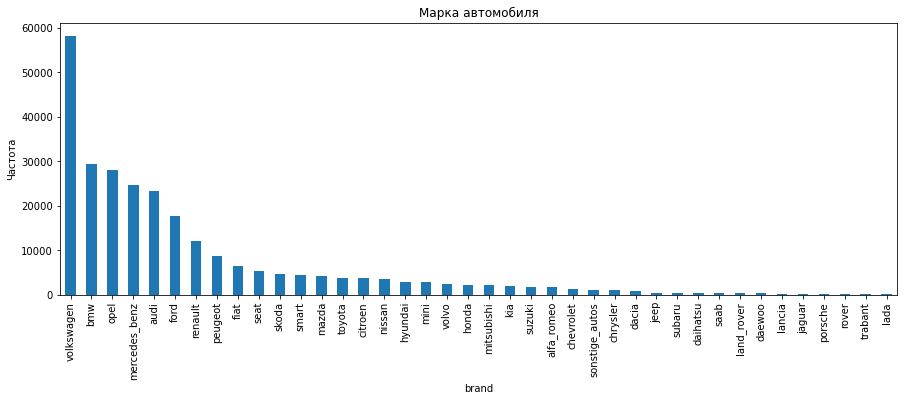

In [22]:
categorical(df, 'brand', 'bar', 'Марка автомобиля')

In [23]:
print(df.query('brand == "volkswagen"')['brand'].count()/df['brand'].count())
print(df['brand'].value_counts().head(10).sum() / df['brand'].count())

0.21900921355337422
0.8057962174353414


Volkswagen однозначный лидер с долей в 22%, а топ-10 марок авто приходитя 81% всех авто датасета.

Рассмотрим распределение <b><u>не ремонтированых и ремонтированных авто</u></b>.

no     0.905501
yes    0.094499
Name: is_repaired, dtype: float64


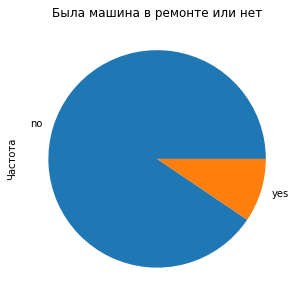

In [25]:
print(df['is_repaired'].value_counts()/df['is_repaired'].count())

categorical(df, 'is_repaired', 'pie', 'Была машина в ремонте или нет')

90% авто никогда ранее не ремонтировались, 1% - ремонтировались, про оставшиеся 9% нам не известно.

Рассмотрим авто по используемому <b><u>типу топлива</u></b>.

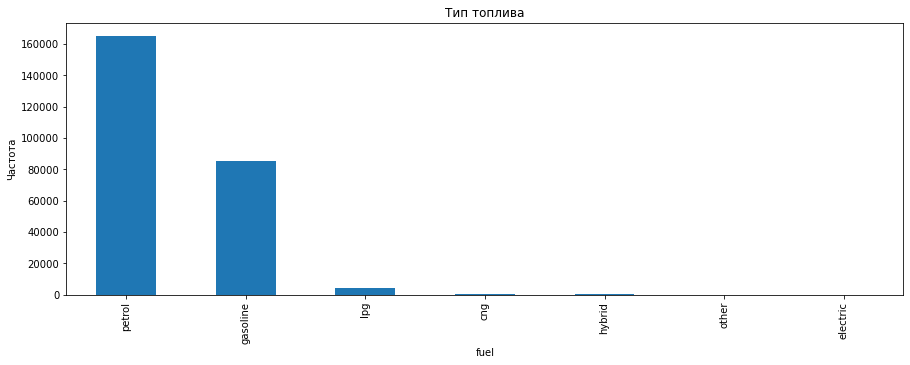

In [33]:
categorical(df, 'fuel', 'bar', 'Тип топлива')

Бензин и газ лидируют. Остальные виды топлива занимают ничтожную долю.

Строить диаграмму по <u><b>почтовому индексу</b></u> смысла не имеет - слишком большой разброс значений.

In [34]:
pd.Series(df['zip_cde'].unique()).count()

8094

Строить диаграмму по <b><u>количеству фотографий</u></b> автомобиля также не имеет смысла, поскольку в столбце представлено только одно значение - 0.

In [35]:
df['pic_cnt'].value_counts()

0    265587
Name: pic_cnt, dtype: int64

#### 1.2.3. Дата-время

Рассмотрим распределение количественных признаков, к таковым относятся: `reg_year`, `dt_created`.
<br>Столбцы `dt_crawled`, `reg_month` и `dt_last_seen`, не несут смыслового значения, мы не будем их рассматривать и удалим ниже.

Посмотрим как распределяются <b><u>дат создания описаний авто</u></b>.

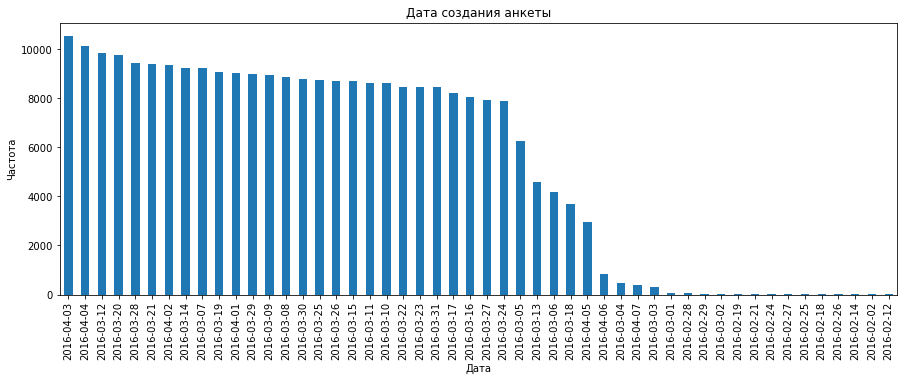

In [36]:
# Преобразовываем данные в формат даты-времени.

df['dt_created'] = pd.to_datetime(df['dt_created'], format="%Y-%m-%dT%H:%M:%S").dt.date



# Поскольку у распределения очень длинный хвост, оставим только только топ-50 дат, по которым уже понятно распределение.

df['dt_created'].value_counts().head(50).plot(kind='bar', 
                                              figsize=(15,5), 
                                              title='Дата создания анкеты',
                                              xlabel='Дата',
                                              ylabel='Частота');

Почти все даты относятся к перилду с 03.03.2016 по 03.04.2016. Вероятно, компания/проект новый и только начал заполнять базу.

**Вывод**

Признаки датасета были распределены на 3 категории: числовые, категориальные и признаки в формате DateTime. Выделены признаки, не имеющие смысла для построения модели такие как почтовый идекс и наличие фото автомобиля (ниже они будут удалены из датасета). Невалидные данные были исключены из признаков (оставлены лишь данные с годом регистарции  до 1980 года и после 2015 года, а также со стоимостью автомобиля более 500 евро и мощность. двигателя от 10 до 250 л/с).

### 2. Предобработка данных

Удалим колонки, которые не повлияют на результаты модели: `dt_crawled`, `reg_month`, `dt_created`, `dt_last_seen`, `pic_cnt`, `zip_cde`.

In [37]:
df = df.drop(['dt_crawled', 'reg_month', 'dt_created', 'dt_last_seen', 'pic_cnt', 'zip_cde'], axis=1)

Обработаем пропуски в 4 столбцах:
- vehtype - восстановим по соответсвующей модели автомобиля;
- gearbox - заменим пропуски на manual;
- model - создадим новую группу - other;
- fuel - заменим на наиболее часто встречающееся топливо petrol;
- is_repaired - заменим на unknown.

Заменим 6% пропущенных строк столбца `model` на other.

In [38]:
df['model'] = df['model'].fillna('other')
list(df['model'].sort_values().unique())

['100',
 '145',
 '147',
 '156',
 '159',
 '1_reihe',
 '1er',
 '200',
 '2_reihe',
 '300c',
 '3_reihe',
 '3er',
 '4_reihe',
 '500',
 '5_reihe',
 '5er',
 '601',
 '6_reihe',
 '6er',
 '7er',
 '80',
 '850',
 '90',
 '900',
 '9000',
 '911',
 'a1',
 'a2',
 'a3',
 'a4',
 'a5',
 'a6',
 'a8',
 'a_klasse',
 'accord',
 'agila',
 'alhambra',
 'almera',
 'altea',
 'amarok',
 'antara',
 'arosa',
 'astra',
 'auris',
 'avensis',
 'aveo',
 'aygo',
 'b_klasse',
 'b_max',
 'beetle',
 'berlingo',
 'bora',
 'boxster',
 'bravo',
 'c1',
 'c2',
 'c3',
 'c4',
 'c5',
 'c_klasse',
 'c_max',
 'c_reihe',
 'caddy',
 'calibra',
 'captiva',
 'carisma',
 'carnival',
 'cayenne',
 'cc',
 'ceed',
 'charade',
 'cherokee',
 'citigo',
 'civic',
 'cl',
 'clio',
 'clk',
 'clubman',
 'colt',
 'combo',
 'cooper',
 'cordoba',
 'corolla',
 'corsa',
 'cr_reihe',
 'croma',
 'crossfire',
 'cuore',
 'cx_reihe',
 'defender',
 'delta',
 'discovery',
 'doblo',
 'ducato',
 'duster',
 'e_klasse',
 'elefantino',
 'eos',
 'escort',
 'espace',
 

Как было показано выше, столбец `veh_type` содержит 11% строк с пропущенными знаечниями. Заполним их, на основании модели авто.

In [39]:
veh_type_by_model = df[df['model'].isna()==False].pivot_table(index='model',
                                                              columns='veh_type',
                                                              values='brand',
                                                              aggfunc='count')

model_upd = veh_type_by_model.columns.values
veh_type_by_model['veh_type_upd'] = veh_type_by_model[model_upd].apply(lambda x: model_upd[x.argmax()], axis=1)
df.loc[df['veh_type'].isna(), 'veh_type'] = df[df['veh_type'].isna()]['model'].\
                                            apply(lambda x: veh_type_by_model.loc[x,'veh_type_upd'])

df['veh_type'].value_counts()

sedan          78340
small          62745
wagon          56145
bus            26060
convertible    17710
coupe          12442
suv            10021
other           2124
Name: veh_type, dtype: int64

Как было показано выше, столбец `gearbox ` содержит 6% строк с пропущенными знаечниями. Заполним их, "механикой".

In [40]:
df['gearbox'] = df['gearbox'].fillna('manual')
df['gearbox'].value_counts()

manual    213928
auto       51659
Name: gearbox, dtype: int64

Аналогично поступим со столбцом `fuel`, заполнив пустые строки (9% столбца) самым популярным значением - petrol.

In [41]:
df['fuel'] = df['fuel'].fillna('petrol')
df['fuel'].value_counts()

petrol      175554
gasoline     85224
lpg           4036
cng            460
hybrid         193
other           63
electric        57
Name: fuel, dtype: int64

20% пропущенных значений столбца `is_repaired` выглядят слишком большим числом, чтобы заполнять их наугад. Создадим особую категорию для пропусков - n/a.

In [42]:
df['is_repaired'] = df['is_repaired'].fillna('n/a')
df['is_repaired'].value_counts()

no     210039
n/a     33628
yes     21920
Name: is_repaired, dtype: int64

Убедимся, что в колонках не осталось пропусков.

In [43]:
print('\033[1m' + 'Пропусков в столбцах, %:' + '\033[0m')
for col in df.columns:
    print(col, np.round_((df[col].isna().sum() / df.shape[0])*100))

Пропусков в столбцах, %:
price 0.0
veh_type 0.0
reg_year 0.0
gearbox 0.0
power 0.0
model 0.0
km 0.0
fuel 0.0
brand 0.0
is_repaired 0.0


Проверим, сколько теперь дубликатов и удалим их.

In [44]:
print(df.duplicated().sum())
df = df.drop_duplicates()
print(df.info())

38456
<class 'pandas.core.frame.DataFrame'>
Int64Index: 227131 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   price        227131 non-null  int64 
 1   veh_type     227131 non-null  object
 2   reg_year     227131 non-null  int64 
 3   gearbox      227131 non-null  object
 4   power        227131 non-null  int64 
 5   model        227131 non-null  object
 6   km           227131 non-null  int64 
 7   fuel         227131 non-null  object
 8   brand        227131 non-null  object
 9   is_repaired  227131 non-null  object
dtypes: int64(4), object(6)
memory usage: 19.1+ MB
None


In [45]:
print('Сохранено строк от изначального датасета после преобразований:', '{:.0%}'.format(df.shape[0]/df_init_shape[0]))

Сохранено строк от изначального датасета после преобразований: 64%


**Вывод**

Таким образом, была получена общая информация о датасете, осуществлена проверка распределений данных в колонках-признаках будущей модели, удалены колонки, которые не будут участовать в построении модели ML.
<br>При преобразовании было сохранено 64% исходного датасета.

## 3. Построение моделей

### 3.1. Подготовка признаков

Закодируем признаки методом порядкового кодирования (OE - Ordinal Encoding).

In [46]:
# Инициируем кодировщик.
encoder = OrdinalEncoder()

# Указываем колонки с категориальными признаками, которые будем кодировать.
cat_columns = ['veh_type', 'gearbox', 'model', 'fuel', 'brand', 'is_repaired']

# Создаем DataFrame с закодированными признаками.
cat_oe = df[cat_columns]
cat_oe = pd.DataFrame(encoder.fit_transform(cat_oe),
                                columns=cat_oe.columns, 
                                index=cat_oe.index)

# Разделим датафреймы с закодированными и незакодированными признаками.
df_oe = df.copy()
for column in cat_columns:
    df_oe[column] = cat_oe[column]

Выделим признаки и целевой признак.

In [47]:
# С закодированными категориальными переменными.
features = df_oe.drop(['price'], axis=1)
target = df['price']
print(features.shape)

(227131, 9)


Разобьем выборки c OE на обучающую и валидационную.

In [48]:
(features_train_oe,
 features_valid_oe,
 target_train_oe,
 target_valid_oe) = train_test_split(features, target, random_state=12345, test_size=0.2)


#Проверим корректность разбивки.

if features_train_oe.shape[0] + features_valid_oe.shape[0] == df_oe.shape[0]:
    print('Датасет раздлен на выборки корректно\n')
else:
    print('Датасет раздлен на выборки некорректно\n')

print('Исходный датасет включает:', df_oe.shape[0],
      '\nОбучающая выборка включает:', features_train_oe.shape[0], f'или {features_train_oe.shape[0]/df_oe.shape[0]:.0%} датасета'
      '\nВалидационная выборка включает:', features_valid_oe.shape[0], f'или {features_valid_oe.shape[0]/df_oe.shape[0]:.0%} датасета')

Датасет раздлен на выборки корректно

Исходный датасет включает: 227131 
Обучающая выборка включает: 181704 или 80% датасета
Валидационная выборка включает: 45427 или 20% датасета


### 3.2. Обучение моделей

Сравним скорость работы и качество предсказаний (как RMSE) на нескольких ансаблевых моделях машинного обучения:
- Случайный лес,
- Градиентный бустинг на LightGBM,
- Градиентный бустинг на CatBoost.

Обучим модель <b><u>случайного леса</b></u>.

In [49]:
# Подготовим поиск гиперпараметров модели.
RFR_model = RandomForestRegressor()
RFR_params = {'n_estimators':[3,10,15],
             'max_depth':[1,5]}

RFR_grid = RandomizedSearchCV(RFR_model,
                              param_distributions=RFR_params,
                              n_jobs=-1,
                              cv=2,
                              verbose=True,
                              scoring='neg_mean_squared_error')

In [50]:
# Обучим модель и замерим время обучения.
RFR_train_start = time.time()
RFR_grid.fit(features_train_oe, target_train_oe)
RFR_train_time = time.time() - RFR_train_start

RFR_RMSE_train = abs((RFR_grid.best_score_)) ** 0.5

print('Лучшие параметры модели:', RFR_grid.best_estimator_)
print('RMSE лучшей модели на обучающей выборке:', RFR_RMSE_train)
print('Время обучения модели, сек.:', np.round_(RFR_train_time))

C:\Users\Roman\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 6 candidates, totalling 12 fits
Лучшие параметры модели: RandomForestRegressor(max_depth=5, n_estimators=10)
RMSE лучшей модели на обучающей выборке: 2200.054172934323
Время обучения модели, сек.: 10.0


Проведем проверку на валидационной выборке и замерим ее параметры.

In [51]:
RFR_valid_start = time.time()
RFR_valid = RFR_grid.best_estimator_.predict(features_valid_oe)
RFR_valid_time = time.time() - RFR_valid_start

RFR_RMSE_valid = mean_squared_error(RFR_valid, target_valid_oe) ** 0.5

print('RMSE лучшей модели на валидационной выборке:', RFR_RMSE_valid)
print('Время валидации модели, сек.:', np.round_(RFR_valid_time))

RMSE лучшей модели на валидационной выборке: 2231.0764976566466
Время валидации модели, сек.: 0.0


Градиентный бустинг <b><u>LightGBM</b></u>

In [52]:
# Обучим модель и замерим время обучения.
LGBR_train_start = time.time()

LGBR_train = lgb.Dataset(features_train_oe, target_train_oe)
LGBR_valid = lgb.Dataset(features_valid_oe, target_valid_oe, reference=LGBR_train)

LGBR_params = {'metric': 'l2',
              'max_depth':10,
              "random_state": 12345,
              "learning_rate":0.1}

LGBR_model = lgb.train(LGBR_params,
                LGBR_train,
                num_boost_round=1000,
                valid_sets=[LGBR_train, LGBR_valid],
                verbose_eval=100)


LGBR_train_time = time.time() - LGBR_train_start

C:\Users\Roman\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010257 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 589
[LightGBM] [Info] Number of data points in the train set: 181704, number of used features: 9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 5121.605309
[100]	training's l2: 2.4237e+06	valid_1's l2: 2.47874e+06
[200]	training's l2: 2.21813e+06	valid_1's l2: 2.32739e+06
[300]	training's l2: 2.1148e+06	valid_1's l2: 2.26316e+06
[400]	training's l2: 2.0

In [53]:
# Замерим RMSE обучающей выборки.
LGBR_pred_train = LGBR_model.predict(features_train_oe)
LGBR_RMSE_train = mean_squared_error(LGBR_pred_train, target_train_oe) ** 0.5

print('RMSE лучшей модели на обучающей выборке:', LGBR_RMSE_train)
print('Время обучения модели, сек.:', np.round_(LGBR_train_time))

RMSE лучшей модели на обучающей выборке: 1342.129523457894
Время обучения модели, сек.: 8.0


Проведем проверку на валидационной выборке и замерим ее параметры.

In [54]:
LGBR_valid_start = time.time()

LGBR_pred_valid = LGBR_model.predict(features_valid_oe)
LGBR_RMSE_valid = mean_squared_error(LGBR_pred_valid, target_valid_oe) ** 0.5

LGBR_valid_time = time.time() - LGBR_valid_start

print('RMSE лучшей модели на валидационной выборке:', LGBR_RMSE_valid)
print('Время валидации модели, сек.:', np.round_(LGBR_valid_time))

RMSE лучшей модели на валидационной выборке: 1460.6817718251152
Время валидации модели, сек.: 1.0


Градиентный бустинг <u><b>CatBoost</b></u>

In [55]:
CATBOOST_train_start = time.time()

CATBOOST_model = CatBoostRegressor(loss_function='RMSE')
CATBOOST_params = {'depth':[5,10], 'learning_rate':np.arange(0.1,1,0.2)}
CATBOOST_grid = GridSearchCV(CATBOOST_model, CATBOOST_params, cv=3, verbose=True)

CATBOOST_grid.fit(features_train_oe, target_train_oe)
                                           
CATBOOST_train_time = time.time() - CATBOOST_train_start

Fitting 3 folds for each of 10 candidates, totalling 30 fits
0:	learn: 4235.1518324	total: 260ms	remaining: 4m 19s
1:	learn: 3965.5975785	total: 281ms	remaining: 2m 20s
2:	learn: 3729.9445238	total: 299ms	remaining: 1m 39s
3:	learn: 3517.0079972	total: 318ms	remaining: 1m 19s
4:	learn: 3338.3888963	total: 336ms	remaining: 1m 6s
5:	learn: 3172.0678300	total: 350ms	remaining: 58s
6:	learn: 3030.0006875	total: 366ms	remaining: 51.9s
7:	learn: 2904.4774344	total: 380ms	remaining: 47.1s
8:	learn: 2798.7013593	total: 395ms	remaining: 43.5s
9:	learn: 2704.0948793	total: 411ms	remaining: 40.7s
10:	learn: 2623.1634096	total: 429ms	remaining: 38.5s
11:	learn: 2546.5879216	total: 444ms	remaining: 36.5s
12:	learn: 2480.5548280	total: 458ms	remaining: 34.8s
13:	learn: 2422.1517472	total: 470ms	remaining: 33.1s
14:	learn: 2371.4468952	total: 487ms	remaining: 32s
15:	learn: 2326.2148376	total: 504ms	remaining: 31s
16:	learn: 2286.4399666	total: 525ms	remaining: 30.3s
17:	learn: 2247.5431404	total: 54

163:	learn: 1641.1302474	total: 2.89s	remaining: 14.7s
164:	learn: 1640.4836447	total: 2.9s	remaining: 14.7s
165:	learn: 1639.7320464	total: 2.92s	remaining: 14.7s
166:	learn: 1639.1572176	total: 2.93s	remaining: 14.6s
167:	learn: 1638.7826108	total: 2.94s	remaining: 14.6s
168:	learn: 1637.8812490	total: 2.95s	remaining: 14.5s
169:	learn: 1637.2640973	total: 2.97s	remaining: 14.5s
170:	learn: 1636.5806108	total: 2.98s	remaining: 14.4s
171:	learn: 1636.0570210	total: 2.99s	remaining: 14.4s
172:	learn: 1634.9009873	total: 3s	remaining: 14.4s
173:	learn: 1634.2373935	total: 3.02s	remaining: 14.3s
174:	learn: 1633.6310187	total: 3.03s	remaining: 14.3s
175:	learn: 1633.1957810	total: 3.04s	remaining: 14.2s
176:	learn: 1632.8744421	total: 3.05s	remaining: 14.2s
177:	learn: 1631.9357596	total: 3.07s	remaining: 14.2s
178:	learn: 1631.2873309	total: 3.08s	remaining: 14.1s
179:	learn: 1630.2835475	total: 3.1s	remaining: 14.1s
180:	learn: 1629.5502383	total: 3.11s	remaining: 14.1s
181:	learn: 162

321:	learn: 1567.4708991	total: 5.09s	remaining: 10.7s
322:	learn: 1567.1846032	total: 5.11s	remaining: 10.7s
323:	learn: 1566.9125963	total: 5.13s	remaining: 10.7s
324:	learn: 1566.5179919	total: 5.14s	remaining: 10.7s
325:	learn: 1566.2167519	total: 5.17s	remaining: 10.7s
326:	learn: 1565.9008029	total: 5.19s	remaining: 10.7s
327:	learn: 1565.4311758	total: 5.21s	remaining: 10.7s
328:	learn: 1565.0989204	total: 5.22s	remaining: 10.6s
329:	learn: 1564.8041244	total: 5.23s	remaining: 10.6s
330:	learn: 1564.6095857	total: 5.24s	remaining: 10.6s
331:	learn: 1564.1379125	total: 5.26s	remaining: 10.6s
332:	learn: 1563.6919788	total: 5.28s	remaining: 10.6s
333:	learn: 1563.4594041	total: 5.29s	remaining: 10.5s
334:	learn: 1563.1478502	total: 5.3s	remaining: 10.5s
335:	learn: 1562.7189068	total: 5.32s	remaining: 10.5s
336:	learn: 1562.5259685	total: 5.33s	remaining: 10.5s
337:	learn: 1562.2511215	total: 5.34s	remaining: 10.5s
338:	learn: 1562.0316590	total: 5.36s	remaining: 10.5s
339:	learn:

476:	learn: 1527.9509881	total: 7.8s	remaining: 8.55s
477:	learn: 1527.6732357	total: 7.81s	remaining: 8.53s
478:	learn: 1527.4379588	total: 7.82s	remaining: 8.51s
479:	learn: 1527.1710948	total: 7.83s	remaining: 8.49s
480:	learn: 1526.9673766	total: 7.85s	remaining: 8.47s
481:	learn: 1526.6874897	total: 7.86s	remaining: 8.45s
482:	learn: 1526.4203473	total: 7.87s	remaining: 8.43s
483:	learn: 1526.2784742	total: 7.89s	remaining: 8.41s
484:	learn: 1526.1637544	total: 7.9s	remaining: 8.39s
485:	learn: 1526.0503071	total: 7.92s	remaining: 8.38s
486:	learn: 1525.7156111	total: 7.94s	remaining: 8.36s
487:	learn: 1525.5529011	total: 7.96s	remaining: 8.35s
488:	learn: 1525.3986924	total: 7.97s	remaining: 8.33s
489:	learn: 1525.2088897	total: 7.99s	remaining: 8.31s
490:	learn: 1524.9952550	total: 8s	remaining: 8.29s
491:	learn: 1524.8308650	total: 8.01s	remaining: 8.27s
492:	learn: 1524.6196277	total: 8.03s	remaining: 8.25s
493:	learn: 1524.4922500	total: 8.04s	remaining: 8.23s
494:	learn: 152

634:	learn: 1502.0023815	total: 10.1s	remaining: 5.8s
635:	learn: 1501.9478783	total: 10.1s	remaining: 5.78s
636:	learn: 1501.8427662	total: 10.1s	remaining: 5.76s
637:	learn: 1501.7320907	total: 10.1s	remaining: 5.75s
638:	learn: 1501.6083603	total: 10.1s	remaining: 5.73s
639:	learn: 1501.4927770	total: 10.1s	remaining: 5.71s
640:	learn: 1501.3699787	total: 10.2s	remaining: 5.69s
641:	learn: 1501.2066952	total: 10.2s	remaining: 5.67s
642:	learn: 1501.0846956	total: 10.2s	remaining: 5.67s
643:	learn: 1500.8859485	total: 10.2s	remaining: 5.65s
644:	learn: 1500.7783565	total: 10.2s	remaining: 5.64s
645:	learn: 1500.6172347	total: 10.3s	remaining: 5.62s
646:	learn: 1500.5277954	total: 10.3s	remaining: 5.61s
647:	learn: 1500.2958358	total: 10.3s	remaining: 5.59s
648:	learn: 1500.1972789	total: 10.3s	remaining: 5.58s
649:	learn: 1500.0469666	total: 10.3s	remaining: 5.56s
650:	learn: 1499.9902776	total: 10.3s	remaining: 5.54s
651:	learn: 1499.7954403	total: 10.4s	remaining: 5.53s
652:	learn:

790:	learn: 1482.4613659	total: 12.4s	remaining: 3.29s
791:	learn: 1482.4308482	total: 12.5s	remaining: 3.28s
792:	learn: 1482.2671877	total: 12.5s	remaining: 3.27s
793:	learn: 1482.1843033	total: 12.5s	remaining: 3.25s
794:	learn: 1482.0776920	total: 12.5s	remaining: 3.23s
795:	learn: 1481.9962944	total: 12.6s	remaining: 3.22s
796:	learn: 1481.8318937	total: 12.6s	remaining: 3.2s
797:	learn: 1481.6653254	total: 12.6s	remaining: 3.19s
798:	learn: 1481.5608402	total: 12.6s	remaining: 3.17s
799:	learn: 1481.4533385	total: 12.6s	remaining: 3.16s
800:	learn: 1481.3285935	total: 12.6s	remaining: 3.14s
801:	learn: 1481.2255914	total: 12.7s	remaining: 3.13s
802:	learn: 1481.1141604	total: 12.7s	remaining: 3.11s
803:	learn: 1481.0533640	total: 12.7s	remaining: 3.09s
804:	learn: 1480.8886217	total: 12.7s	remaining: 3.08s
805:	learn: 1480.7729590	total: 12.7s	remaining: 3.06s
806:	learn: 1480.6486400	total: 12.7s	remaining: 3.04s
807:	learn: 1480.5356734	total: 12.7s	remaining: 3.03s
808:	learn:

944:	learn: 1465.9530338	total: 14.8s	remaining: 859ms
945:	learn: 1465.8351267	total: 14.8s	remaining: 844ms
946:	learn: 1465.7702450	total: 14.8s	remaining: 828ms
947:	learn: 1465.6040595	total: 14.8s	remaining: 812ms
948:	learn: 1465.4958029	total: 14.8s	remaining: 797ms
949:	learn: 1465.3418050	total: 14.8s	remaining: 781ms
950:	learn: 1465.1976526	total: 14.9s	remaining: 765ms
951:	learn: 1465.0757387	total: 14.9s	remaining: 750ms
952:	learn: 1464.9549899	total: 14.9s	remaining: 734ms
953:	learn: 1464.8260354	total: 14.9s	remaining: 718ms
954:	learn: 1464.7464643	total: 14.9s	remaining: 702ms
955:	learn: 1464.6072276	total: 14.9s	remaining: 687ms
956:	learn: 1464.4753086	total: 14.9s	remaining: 671ms
957:	learn: 1464.4229368	total: 14.9s	remaining: 655ms
958:	learn: 1464.2951084	total: 15s	remaining: 640ms
959:	learn: 1464.2085612	total: 15s	remaining: 624ms
960:	learn: 1464.1214628	total: 15s	remaining: 608ms
961:	learn: 1464.0404339	total: 15s	remaining: 593ms
962:	learn: 1463.9

99:	learn: 1716.4512901	total: 1.88s	remaining: 16.9s
100:	learn: 1713.6890146	total: 1.9s	remaining: 16.9s
101:	learn: 1712.3028741	total: 1.92s	remaining: 16.9s
102:	learn: 1710.9552665	total: 1.94s	remaining: 16.9s
103:	learn: 1709.6504976	total: 1.96s	remaining: 16.8s
104:	learn: 1708.6696888	total: 1.98s	remaining: 16.9s
105:	learn: 1707.2712813	total: 2s	remaining: 16.8s
106:	learn: 1706.4230920	total: 2.02s	remaining: 16.8s
107:	learn: 1705.6396096	total: 2.04s	remaining: 16.8s
108:	learn: 1704.3325918	total: 2.06s	remaining: 16.8s
109:	learn: 1703.0056281	total: 2.08s	remaining: 16.8s
110:	learn: 1701.3582247	total: 2.13s	remaining: 17.1s
111:	learn: 1700.3885633	total: 2.17s	remaining: 17.3s
112:	learn: 1698.4898959	total: 2.19s	remaining: 17.2s
113:	learn: 1697.4525995	total: 2.21s	remaining: 17.2s
114:	learn: 1696.5076350	total: 2.23s	remaining: 17.2s
115:	learn: 1695.6185586	total: 2.25s	remaining: 17.1s
116:	learn: 1693.1457261	total: 2.28s	remaining: 17.2s
117:	learn: 169

257:	learn: 1598.6265997	total: 4.11s	remaining: 11.8s
258:	learn: 1598.3009292	total: 4.12s	remaining: 11.8s
259:	learn: 1597.9931879	total: 4.14s	remaining: 11.8s
260:	learn: 1597.3312563	total: 4.15s	remaining: 11.7s
261:	learn: 1597.0133547	total: 4.16s	remaining: 11.7s
262:	learn: 1596.5129230	total: 4.18s	remaining: 11.7s
263:	learn: 1596.2204362	total: 4.19s	remaining: 11.7s
264:	learn: 1595.9760295	total: 4.2s	remaining: 11.7s
265:	learn: 1595.8176419	total: 4.21s	remaining: 11.6s
266:	learn: 1595.4843367	total: 4.22s	remaining: 11.6s
267:	learn: 1594.8739718	total: 4.24s	remaining: 11.6s
268:	learn: 1594.5842645	total: 4.26s	remaining: 11.6s
269:	learn: 1594.3872441	total: 4.27s	remaining: 11.6s
270:	learn: 1594.1198972	total: 4.29s	remaining: 11.5s
271:	learn: 1593.4988698	total: 4.3s	remaining: 11.5s
272:	learn: 1593.2258868	total: 4.32s	remaining: 11.5s
273:	learn: 1592.8853892	total: 4.33s	remaining: 11.5s
274:	learn: 1592.2375258	total: 4.34s	remaining: 11.4s
275:	learn: 

408:	learn: 1550.1985222	total: 6.42s	remaining: 9.28s
409:	learn: 1550.0249898	total: 6.43s	remaining: 9.26s
410:	learn: 1549.7879068	total: 6.45s	remaining: 9.24s
411:	learn: 1549.6125321	total: 6.46s	remaining: 9.22s
412:	learn: 1549.2548164	total: 6.47s	remaining: 9.2s
413:	learn: 1549.0539433	total: 6.49s	remaining: 9.18s
414:	learn: 1548.8452235	total: 6.5s	remaining: 9.16s
415:	learn: 1548.5601993	total: 6.51s	remaining: 9.14s
416:	learn: 1548.3424200	total: 6.52s	remaining: 9.12s
417:	learn: 1548.2386505	total: 6.54s	remaining: 9.1s
418:	learn: 1547.8016595	total: 6.55s	remaining: 9.08s
419:	learn: 1547.5042495	total: 6.56s	remaining: 9.06s
420:	learn: 1547.3048528	total: 6.57s	remaining: 9.04s
421:	learn: 1546.9478161	total: 6.58s	remaining: 9.02s
422:	learn: 1546.8443013	total: 6.6s	remaining: 9s
423:	learn: 1546.5660407	total: 6.61s	remaining: 8.98s
424:	learn: 1546.3983633	total: 6.62s	remaining: 8.96s
425:	learn: 1546.1817950	total: 6.64s	remaining: 8.94s
426:	learn: 1545.

558:	learn: 1521.1120860	total: 8.7s	remaining: 6.86s
559:	learn: 1520.9158204	total: 8.72s	remaining: 6.85s
560:	learn: 1520.7838502	total: 8.74s	remaining: 6.84s
561:	learn: 1520.6823927	total: 8.76s	remaining: 6.83s
562:	learn: 1520.4641441	total: 8.79s	remaining: 6.82s
563:	learn: 1520.2726797	total: 8.8s	remaining: 6.81s
564:	learn: 1520.1128474	total: 8.82s	remaining: 6.79s
565:	learn: 1519.7597766	total: 8.84s	remaining: 6.78s
566:	learn: 1519.6725909	total: 8.85s	remaining: 6.76s
567:	learn: 1519.5406406	total: 8.86s	remaining: 6.74s
568:	learn: 1519.3650346	total: 8.88s	remaining: 6.72s
569:	learn: 1518.9915686	total: 8.89s	remaining: 6.71s
570:	learn: 1518.8310632	total: 8.9s	remaining: 6.69s
571:	learn: 1518.6479949	total: 8.92s	remaining: 6.67s
572:	learn: 1518.4837166	total: 8.93s	remaining: 6.66s
573:	learn: 1518.3665684	total: 8.94s	remaining: 6.64s
574:	learn: 1518.2022847	total: 8.96s	remaining: 6.62s
575:	learn: 1517.9176761	total: 8.98s	remaining: 6.61s
576:	learn: 1

715:	learn: 1497.3844727	total: 10.9s	remaining: 4.34s
716:	learn: 1497.1906404	total: 11s	remaining: 4.33s
717:	learn: 1497.0922789	total: 11s	remaining: 4.31s
718:	learn: 1496.9715855	total: 11s	remaining: 4.29s
719:	learn: 1496.8604862	total: 11s	remaining: 4.28s
720:	learn: 1496.7321458	total: 11s	remaining: 4.26s
721:	learn: 1496.5328231	total: 11s	remaining: 4.25s
722:	learn: 1496.3245071	total: 11s	remaining: 4.23s
723:	learn: 1496.0070801	total: 11.1s	remaining: 4.21s
724:	learn: 1495.8472864	total: 11.1s	remaining: 4.2s
725:	learn: 1495.7362887	total: 11.1s	remaining: 4.18s
726:	learn: 1495.6469692	total: 11.1s	remaining: 4.16s
727:	learn: 1495.5141432	total: 11.1s	remaining: 4.15s
728:	learn: 1495.4606045	total: 11.1s	remaining: 4.13s
729:	learn: 1495.3611180	total: 11.1s	remaining: 4.12s
730:	learn: 1495.2195744	total: 11.1s	remaining: 4.1s
731:	learn: 1495.0681787	total: 11.2s	remaining: 4.08s
732:	learn: 1494.9219626	total: 11.2s	remaining: 4.07s
733:	learn: 1494.7857827	t

875:	learn: 1478.7660282	total: 13.2s	remaining: 1.87s
876:	learn: 1478.6857845	total: 13.3s	remaining: 1.86s
877:	learn: 1478.5620321	total: 13.3s	remaining: 1.84s
878:	learn: 1478.4797672	total: 13.3s	remaining: 1.83s
879:	learn: 1478.3628873	total: 13.3s	remaining: 1.81s
880:	learn: 1478.1993300	total: 13.3s	remaining: 1.8s
881:	learn: 1478.0794584	total: 13.3s	remaining: 1.78s
882:	learn: 1478.0139736	total: 13.3s	remaining: 1.77s
883:	learn: 1477.9462800	total: 13.3s	remaining: 1.75s
884:	learn: 1477.8454665	total: 13.4s	remaining: 1.74s
885:	learn: 1477.7626788	total: 13.4s	remaining: 1.72s
886:	learn: 1477.6231893	total: 13.4s	remaining: 1.7s
887:	learn: 1477.5377312	total: 13.4s	remaining: 1.69s
888:	learn: 1477.4771057	total: 13.4s	remaining: 1.67s
889:	learn: 1477.4172821	total: 13.4s	remaining: 1.66s
890:	learn: 1477.3314259	total: 13.4s	remaining: 1.64s
891:	learn: 1477.1875646	total: 13.4s	remaining: 1.63s
892:	learn: 1477.0647173	total: 13.5s	remaining: 1.61s
893:	learn: 

33:	learn: 1966.2042648	total: 600ms	remaining: 17s
34:	learn: 1953.3806515	total: 621ms	remaining: 17.1s
35:	learn: 1946.8631927	total: 638ms	remaining: 17.1s
36:	learn: 1934.7715161	total: 660ms	remaining: 17.2s
37:	learn: 1923.6303348	total: 677ms	remaining: 17.1s
38:	learn: 1915.7445132	total: 691ms	remaining: 17s
39:	learn: 1909.8626818	total: 703ms	remaining: 16.9s
40:	learn: 1903.8366296	total: 716ms	remaining: 16.7s
41:	learn: 1898.4918775	total: 728ms	remaining: 16.6s
42:	learn: 1889.0902209	total: 742ms	remaining: 16.5s
43:	learn: 1882.8670559	total: 754ms	remaining: 16.4s
44:	learn: 1878.7346027	total: 767ms	remaining: 16.3s
45:	learn: 1875.0094607	total: 781ms	remaining: 16.2s
46:	learn: 1866.3538319	total: 795ms	remaining: 16.1s
47:	learn: 1860.4326980	total: 810ms	remaining: 16.1s
48:	learn: 1852.5287910	total: 823ms	remaining: 16s
49:	learn: 1849.2881655	total: 834ms	remaining: 15.8s
50:	learn: 1845.3890029	total: 851ms	remaining: 15.8s
51:	learn: 1842.4464245	total: 870

192:	learn: 1625.8606204	total: 2.87s	remaining: 12s
193:	learn: 1625.0981512	total: 2.88s	remaining: 12s
194:	learn: 1624.6411073	total: 2.89s	remaining: 11.9s
195:	learn: 1623.3976703	total: 2.91s	remaining: 11.9s
196:	learn: 1622.6652189	total: 2.92s	remaining: 11.9s
197:	learn: 1622.2520058	total: 2.93s	remaining: 11.9s
198:	learn: 1621.3600633	total: 2.94s	remaining: 11.9s
199:	learn: 1620.8228732	total: 2.96s	remaining: 11.8s
200:	learn: 1619.9197439	total: 2.97s	remaining: 11.8s
201:	learn: 1619.1808645	total: 2.98s	remaining: 11.8s
202:	learn: 1618.6282293	total: 3s	remaining: 11.8s
203:	learn: 1618.0144092	total: 3.01s	remaining: 11.7s
204:	learn: 1617.5554322	total: 3.02s	remaining: 11.7s
205:	learn: 1616.7281419	total: 3.04s	remaining: 11.7s
206:	learn: 1616.3479712	total: 3.05s	remaining: 11.7s
207:	learn: 1616.0560437	total: 3.06s	remaining: 11.7s
208:	learn: 1615.2851421	total: 3.08s	remaining: 11.6s
209:	learn: 1614.5832958	total: 3.09s	remaining: 11.6s
210:	learn: 1614.

350:	learn: 1560.6411007	total: 4.94s	remaining: 9.13s
351:	learn: 1560.3194522	total: 4.96s	remaining: 9.13s
352:	learn: 1560.1193218	total: 4.97s	remaining: 9.11s
353:	learn: 1559.8353244	total: 4.99s	remaining: 9.1s
354:	learn: 1559.5665151	total: 5s	remaining: 9.08s
355:	learn: 1559.3928916	total: 5.01s	remaining: 9.06s
356:	learn: 1559.3040902	total: 5.02s	remaining: 9.04s
357:	learn: 1559.0678806	total: 5.03s	remaining: 9.02s
358:	learn: 1558.7711096	total: 5.04s	remaining: 9s
359:	learn: 1558.5002724	total: 5.05s	remaining: 8.99s
360:	learn: 1558.2217086	total: 5.07s	remaining: 8.97s
361:	learn: 1558.0526514	total: 5.08s	remaining: 8.96s
362:	learn: 1557.6884580	total: 5.1s	remaining: 8.95s
363:	learn: 1557.4535149	total: 5.11s	remaining: 8.93s
364:	learn: 1557.3390547	total: 5.13s	remaining: 8.92s
365:	learn: 1557.2128820	total: 5.14s	remaining: 8.9s
366:	learn: 1556.7235990	total: 5.15s	remaining: 8.88s
367:	learn: 1556.4404433	total: 5.17s	remaining: 8.87s
368:	learn: 1556.18

508:	learn: 1527.4403067	total: 6.98s	remaining: 6.74s
509:	learn: 1527.3121566	total: 7s	remaining: 6.72s
510:	learn: 1527.1959234	total: 7.01s	remaining: 6.71s
511:	learn: 1527.0372838	total: 7.02s	remaining: 6.69s
512:	learn: 1526.9418575	total: 7.04s	remaining: 6.68s
513:	learn: 1526.8065672	total: 7.05s	remaining: 6.66s
514:	learn: 1526.7003581	total: 7.06s	remaining: 6.65s
515:	learn: 1526.4786715	total: 7.07s	remaining: 6.63s
516:	learn: 1526.3943394	total: 7.08s	remaining: 6.62s
517:	learn: 1526.1556225	total: 7.1s	remaining: 6.61s
518:	learn: 1526.0081973	total: 7.11s	remaining: 6.59s
519:	learn: 1525.9729305	total: 7.13s	remaining: 6.58s
520:	learn: 1525.7803264	total: 7.14s	remaining: 6.56s
521:	learn: 1525.6668172	total: 7.15s	remaining: 6.55s
522:	learn: 1525.4967356	total: 7.17s	remaining: 6.54s
523:	learn: 1525.2588574	total: 7.18s	remaining: 6.52s
524:	learn: 1525.0920572	total: 7.19s	remaining: 6.5s
525:	learn: 1524.8915410	total: 7.2s	remaining: 6.49s
526:	learn: 1524

668:	learn: 1503.1472485	total: 9.02s	remaining: 4.46s
669:	learn: 1503.0235246	total: 9.03s	remaining: 4.45s
670:	learn: 1502.8863753	total: 9.05s	remaining: 4.44s
671:	learn: 1502.7957713	total: 9.06s	remaining: 4.42s
672:	learn: 1502.6734567	total: 9.07s	remaining: 4.41s
673:	learn: 1502.5411269	total: 9.08s	remaining: 4.39s
674:	learn: 1502.4551299	total: 9.1s	remaining: 4.38s
675:	learn: 1502.3954872	total: 9.11s	remaining: 4.36s
676:	learn: 1502.2126858	total: 9.12s	remaining: 4.35s
677:	learn: 1502.1007329	total: 9.13s	remaining: 4.34s
678:	learn: 1502.0103158	total: 9.14s	remaining: 4.32s
679:	learn: 1501.9167414	total: 9.15s	remaining: 4.31s
680:	learn: 1501.8406778	total: 9.17s	remaining: 4.29s
681:	learn: 1501.7503480	total: 9.18s	remaining: 4.28s
682:	learn: 1501.6473895	total: 9.2s	remaining: 4.27s
683:	learn: 1501.4866220	total: 9.21s	remaining: 4.26s
684:	learn: 1501.3340730	total: 9.22s	remaining: 4.24s
685:	learn: 1501.1213214	total: 9.24s	remaining: 4.23s
686:	learn: 

823:	learn: 1485.5133756	total: 11.1s	remaining: 2.36s
824:	learn: 1485.4104138	total: 11.1s	remaining: 2.35s
825:	learn: 1485.3014480	total: 11.1s	remaining: 2.33s
826:	learn: 1485.1612234	total: 11.1s	remaining: 2.32s
827:	learn: 1485.0512701	total: 11.1s	remaining: 2.31s
828:	learn: 1484.8899571	total: 11.1s	remaining: 2.29s
829:	learn: 1484.6716007	total: 11.1s	remaining: 2.28s
830:	learn: 1484.6040168	total: 11.2s	remaining: 2.27s
831:	learn: 1484.5186398	total: 11.2s	remaining: 2.26s
832:	learn: 1484.4204962	total: 11.2s	remaining: 2.25s
833:	learn: 1484.3514706	total: 11.2s	remaining: 2.23s
834:	learn: 1484.2641844	total: 11.2s	remaining: 2.22s
835:	learn: 1484.1051159	total: 11.3s	remaining: 2.21s
836:	learn: 1484.0135184	total: 11.3s	remaining: 2.2s
837:	learn: 1483.9180765	total: 11.3s	remaining: 2.18s
838:	learn: 1483.8102097	total: 11.3s	remaining: 2.17s
839:	learn: 1483.6323397	total: 11.3s	remaining: 2.16s
840:	learn: 1483.5389936	total: 11.3s	remaining: 2.14s
841:	learn:

985:	learn: 1470.2711556	total: 13.5s	remaining: 191ms
986:	learn: 1470.1827156	total: 13.5s	remaining: 178ms
987:	learn: 1470.1075121	total: 13.5s	remaining: 164ms
988:	learn: 1470.0341929	total: 13.5s	remaining: 150ms
989:	learn: 1469.8835600	total: 13.5s	remaining: 137ms
990:	learn: 1469.8059576	total: 13.5s	remaining: 123ms
991:	learn: 1469.7381350	total: 13.6s	remaining: 109ms
992:	learn: 1469.6539533	total: 13.6s	remaining: 95.7ms
993:	learn: 1469.5787379	total: 13.6s	remaining: 82ms
994:	learn: 1469.4780306	total: 13.6s	remaining: 68.4ms
995:	learn: 1469.4152871	total: 13.6s	remaining: 54.7ms
996:	learn: 1469.3534352	total: 13.7s	remaining: 41.1ms
997:	learn: 1469.2210768	total: 13.7s	remaining: 27.4ms
998:	learn: 1469.1433288	total: 13.7s	remaining: 13.7ms
999:	learn: 1469.0021599	total: 13.7s	remaining: 0us
0:	learn: 3676.9512522	total: 17.9ms	remaining: 17.8s
1:	learn: 3092.2495241	total: 33.7ms	remaining: 16.8s
2:	learn: 2707.3297130	total: 47.3ms	remaining: 15.7s
3:	learn: 

145:	learn: 1544.5742277	total: 2.27s	remaining: 13.3s
146:	learn: 1543.9166243	total: 2.29s	remaining: 13.3s
147:	learn: 1542.7517179	total: 2.3s	remaining: 13.3s
148:	learn: 1542.1537812	total: 2.32s	remaining: 13.2s
149:	learn: 1541.2450194	total: 2.34s	remaining: 13.2s
150:	learn: 1540.6027854	total: 2.35s	remaining: 13.2s
151:	learn: 1539.8746128	total: 2.39s	remaining: 13.4s
152:	learn: 1539.2197803	total: 2.41s	remaining: 13.4s
153:	learn: 1538.3916282	total: 2.42s	remaining: 13.3s
154:	learn: 1538.0163426	total: 2.44s	remaining: 13.3s
155:	learn: 1537.4058839	total: 2.46s	remaining: 13.3s
156:	learn: 1536.2386167	total: 2.47s	remaining: 13.3s
157:	learn: 1535.5580855	total: 2.49s	remaining: 13.3s
158:	learn: 1535.1075884	total: 2.5s	remaining: 13.2s
159:	learn: 1534.6544198	total: 2.52s	remaining: 13.2s
160:	learn: 1534.4120276	total: 2.53s	remaining: 13.2s
161:	learn: 1533.7733630	total: 2.54s	remaining: 13.1s
162:	learn: 1533.0205726	total: 2.55s	remaining: 13.1s
163:	learn: 

296:	learn: 1474.3216425	total: 4.31s	remaining: 10.2s
297:	learn: 1473.9334370	total: 4.33s	remaining: 10.2s
298:	learn: 1473.7075864	total: 4.34s	remaining: 10.2s
299:	learn: 1473.4164584	total: 4.35s	remaining: 10.2s
300:	learn: 1472.9424482	total: 4.36s	remaining: 10.1s
301:	learn: 1472.7992748	total: 4.38s	remaining: 10.1s
302:	learn: 1472.3555299	total: 4.39s	remaining: 10.1s
303:	learn: 1471.9489597	total: 4.4s	remaining: 10.1s
304:	learn: 1471.4590387	total: 4.41s	remaining: 10.1s
305:	learn: 1471.0461755	total: 4.43s	remaining: 10s
306:	learn: 1470.8760995	total: 4.44s	remaining: 10s
307:	learn: 1470.5300401	total: 4.46s	remaining: 10s
308:	learn: 1470.3125055	total: 4.47s	remaining: 10s
309:	learn: 1470.0596430	total: 4.49s	remaining: 9.99s
310:	learn: 1469.6928188	total: 4.5s	remaining: 9.98s
311:	learn: 1469.3868816	total: 4.52s	remaining: 9.97s
312:	learn: 1469.1094718	total: 4.53s	remaining: 9.95s
313:	learn: 1468.7197819	total: 4.55s	remaining: 9.93s
314:	learn: 1468.504

453:	learn: 1434.8196780	total: 6.55s	remaining: 7.88s
454:	learn: 1434.5753850	total: 6.56s	remaining: 7.86s
455:	learn: 1434.3593263	total: 6.58s	remaining: 7.85s
456:	learn: 1434.0888498	total: 6.59s	remaining: 7.83s
457:	learn: 1433.7742875	total: 6.6s	remaining: 7.81s
458:	learn: 1433.5673819	total: 6.61s	remaining: 7.8s
459:	learn: 1433.3692415	total: 6.63s	remaining: 7.78s
460:	learn: 1433.1783041	total: 6.64s	remaining: 7.76s
461:	learn: 1432.9925462	total: 6.65s	remaining: 7.75s
462:	learn: 1432.8523116	total: 6.67s	remaining: 7.74s
463:	learn: 1432.7540306	total: 6.68s	remaining: 7.72s
464:	learn: 1432.4732508	total: 6.7s	remaining: 7.71s
465:	learn: 1432.3066483	total: 6.72s	remaining: 7.7s
466:	learn: 1432.1509401	total: 6.74s	remaining: 7.69s
467:	learn: 1432.0149785	total: 6.76s	remaining: 7.68s
468:	learn: 1431.8477391	total: 6.78s	remaining: 7.67s
469:	learn: 1431.6953409	total: 6.79s	remaining: 7.66s
470:	learn: 1431.5357122	total: 6.81s	remaining: 7.65s
471:	learn: 14

612:	learn: 1407.9321131	total: 9.06s	remaining: 5.72s
613:	learn: 1407.8210908	total: 9.07s	remaining: 5.71s
614:	learn: 1407.7663299	total: 9.09s	remaining: 5.69s
615:	learn: 1407.6025053	total: 9.1s	remaining: 5.67s
616:	learn: 1407.4123070	total: 9.12s	remaining: 5.66s
617:	learn: 1407.1930731	total: 9.13s	remaining: 5.64s
618:	learn: 1406.9991377	total: 9.14s	remaining: 5.63s
619:	learn: 1406.8007155	total: 9.15s	remaining: 5.61s
620:	learn: 1406.7051060	total: 9.17s	remaining: 5.6s
621:	learn: 1406.5102664	total: 9.18s	remaining: 5.58s
622:	learn: 1406.2929050	total: 9.2s	remaining: 5.57s
623:	learn: 1406.1417167	total: 9.21s	remaining: 5.55s
624:	learn: 1405.9974140	total: 9.22s	remaining: 5.54s
625:	learn: 1405.8927526	total: 9.24s	remaining: 5.52s
626:	learn: 1405.7866247	total: 9.25s	remaining: 5.5s
627:	learn: 1405.6678907	total: 9.27s	remaining: 5.49s
628:	learn: 1405.3938259	total: 9.28s	remaining: 5.47s
629:	learn: 1405.3386673	total: 9.29s	remaining: 5.46s
630:	learn: 14

764:	learn: 1389.2239124	total: 11.3s	remaining: 3.49s
765:	learn: 1389.0960335	total: 11.4s	remaining: 3.48s
766:	learn: 1389.0111429	total: 11.4s	remaining: 3.46s
767:	learn: 1388.8239825	total: 11.4s	remaining: 3.45s
768:	learn: 1388.7224665	total: 11.4s	remaining: 3.44s
769:	learn: 1388.5875387	total: 11.5s	remaining: 3.42s
770:	learn: 1388.5053022	total: 11.5s	remaining: 3.41s
771:	learn: 1388.3578696	total: 11.5s	remaining: 3.4s
772:	learn: 1388.2830372	total: 11.5s	remaining: 3.38s
773:	learn: 1388.1880946	total: 11.5s	remaining: 3.37s
774:	learn: 1388.0924756	total: 11.6s	remaining: 3.36s
775:	learn: 1387.9851822	total: 11.6s	remaining: 3.34s
776:	learn: 1387.9026370	total: 11.6s	remaining: 3.33s
777:	learn: 1387.8163224	total: 11.6s	remaining: 3.31s
778:	learn: 1387.7652629	total: 11.6s	remaining: 3.3s
779:	learn: 1387.5909571	total: 11.6s	remaining: 3.29s
780:	learn: 1387.5138370	total: 11.7s	remaining: 3.27s
781:	learn: 1387.3859636	total: 11.7s	remaining: 3.26s
782:	learn: 

920:	learn: 1373.8697906	total: 14.5s	remaining: 1.24s
921:	learn: 1373.7540072	total: 14.5s	remaining: 1.23s
922:	learn: 1373.6715778	total: 14.5s	remaining: 1.21s
923:	learn: 1373.5956372	total: 14.5s	remaining: 1.19s
924:	learn: 1373.5446982	total: 14.5s	remaining: 1.18s
925:	learn: 1373.4638461	total: 14.5s	remaining: 1.16s
926:	learn: 1373.3913385	total: 14.6s	remaining: 1.15s
927:	learn: 1373.2768547	total: 14.6s	remaining: 1.13s
928:	learn: 1373.2369673	total: 14.6s	remaining: 1.11s
929:	learn: 1373.1390789	total: 14.6s	remaining: 1.1s
930:	learn: 1373.0267578	total: 14.6s	remaining: 1.08s
931:	learn: 1372.9650348	total: 14.6s	remaining: 1.07s
932:	learn: 1372.7837359	total: 14.6s	remaining: 1.05s
933:	learn: 1372.6219257	total: 14.6s	remaining: 1.03s
934:	learn: 1372.5514207	total: 14.7s	remaining: 1.02s
935:	learn: 1372.5146132	total: 14.7s	remaining: 1s
936:	learn: 1372.4546061	total: 14.7s	remaining: 987ms
937:	learn: 1372.4185595	total: 14.7s	remaining: 971ms
938:	learn: 13

73:	learn: 1618.0867299	total: 1.15s	remaining: 14.4s
74:	learn: 1617.4019637	total: 1.16s	remaining: 14.3s
75:	learn: 1616.3350080	total: 1.17s	remaining: 14.3s
76:	learn: 1615.1552286	total: 1.19s	remaining: 14.2s
77:	learn: 1613.1668547	total: 1.2s	remaining: 14.2s
78:	learn: 1611.3581862	total: 1.21s	remaining: 14.2s
79:	learn: 1609.7534539	total: 1.35s	remaining: 15.6s
80:	learn: 1606.5538065	total: 1.42s	remaining: 16.2s
81:	learn: 1605.3994355	total: 1.46s	remaining: 16.3s
82:	learn: 1604.6363545	total: 1.48s	remaining: 16.3s
83:	learn: 1603.7949498	total: 1.49s	remaining: 16.3s
84:	learn: 1601.9956870	total: 1.51s	remaining: 16.2s
85:	learn: 1600.7600762	total: 1.52s	remaining: 16.2s
86:	learn: 1599.6224037	total: 1.54s	remaining: 16.1s
87:	learn: 1598.2366858	total: 1.55s	remaining: 16.1s
88:	learn: 1597.0221854	total: 1.56s	remaining: 16s
89:	learn: 1596.1073951	total: 1.58s	remaining: 16s
90:	learn: 1595.2056655	total: 1.6s	remaining: 16s
91:	learn: 1594.1934251	total: 1.62s

234:	learn: 1503.4640639	total: 4.19s	remaining: 13.6s
235:	learn: 1503.2083511	total: 4.21s	remaining: 13.6s
236:	learn: 1502.6655429	total: 4.22s	remaining: 13.6s
237:	learn: 1502.4094030	total: 4.24s	remaining: 13.6s
238:	learn: 1502.2514091	total: 4.25s	remaining: 13.5s
239:	learn: 1502.0315318	total: 4.26s	remaining: 13.5s
240:	learn: 1501.7343276	total: 4.27s	remaining: 13.5s
241:	learn: 1501.4066425	total: 4.28s	remaining: 13.4s
242:	learn: 1501.0287875	total: 4.3s	remaining: 13.4s
243:	learn: 1500.6198123	total: 4.31s	remaining: 13.4s
244:	learn: 1500.0924867	total: 4.32s	remaining: 13.3s
245:	learn: 1499.6362487	total: 4.34s	remaining: 13.3s
246:	learn: 1499.1177039	total: 4.35s	remaining: 13.3s
247:	learn: 1498.5843256	total: 4.36s	remaining: 13.2s
248:	learn: 1498.3366960	total: 4.38s	remaining: 13.2s
249:	learn: 1497.7402838	total: 4.39s	remaining: 13.2s
250:	learn: 1497.3873665	total: 4.4s	remaining: 13.1s
251:	learn: 1497.0151853	total: 4.42s	remaining: 13.1s
252:	learn: 

398:	learn: 1454.8416511	total: 6.28s	remaining: 9.46s
399:	learn: 1454.5196051	total: 6.29s	remaining: 9.44s
400:	learn: 1454.3516507	total: 6.31s	remaining: 9.42s
401:	learn: 1454.1289579	total: 6.32s	remaining: 9.4s
402:	learn: 1453.9513533	total: 6.33s	remaining: 9.38s
403:	learn: 1453.8353177	total: 6.34s	remaining: 9.35s
404:	learn: 1453.5996034	total: 6.35s	remaining: 9.33s
405:	learn: 1453.4605544	total: 6.36s	remaining: 9.31s
406:	learn: 1453.2731895	total: 6.37s	remaining: 9.29s
407:	learn: 1452.8772184	total: 6.39s	remaining: 9.27s
408:	learn: 1452.5474773	total: 6.4s	remaining: 9.24s
409:	learn: 1452.4174962	total: 6.41s	remaining: 9.22s
410:	learn: 1452.1045410	total: 6.42s	remaining: 9.2s
411:	learn: 1451.8818048	total: 6.43s	remaining: 9.18s
412:	learn: 1451.5952529	total: 6.45s	remaining: 9.16s
413:	learn: 1451.4361362	total: 6.46s	remaining: 9.15s
414:	learn: 1451.1958875	total: 6.47s	remaining: 9.13s
415:	learn: 1450.9968813	total: 6.49s	remaining: 9.11s
416:	learn: 1

548:	learn: 1424.3092338	total: 8.3s	remaining: 6.82s
549:	learn: 1424.1097551	total: 8.31s	remaining: 6.8s
550:	learn: 1423.8928332	total: 8.33s	remaining: 6.79s
551:	learn: 1423.6660772	total: 8.34s	remaining: 6.77s
552:	learn: 1423.5084146	total: 8.35s	remaining: 6.75s
553:	learn: 1423.3796770	total: 8.37s	remaining: 6.74s
554:	learn: 1423.2162448	total: 8.38s	remaining: 6.72s
555:	learn: 1423.0983218	total: 8.39s	remaining: 6.7s
556:	learn: 1422.9989915	total: 8.4s	remaining: 6.68s
557:	learn: 1422.8924795	total: 8.42s	remaining: 6.67s
558:	learn: 1422.7382868	total: 8.43s	remaining: 6.65s
559:	learn: 1422.6183343	total: 8.45s	remaining: 6.63s
560:	learn: 1422.5202287	total: 8.46s	remaining: 6.62s
561:	learn: 1422.2939442	total: 8.47s	remaining: 6.6s
562:	learn: 1422.1170041	total: 8.48s	remaining: 6.59s
563:	learn: 1422.0093471	total: 8.5s	remaining: 6.57s
564:	learn: 1421.9024579	total: 8.51s	remaining: 6.55s
565:	learn: 1421.8048702	total: 8.52s	remaining: 6.53s
566:	learn: 1421

706:	learn: 1402.8182996	total: 10.6s	remaining: 4.41s
707:	learn: 1402.6722822	total: 10.7s	remaining: 4.39s
708:	learn: 1402.5520097	total: 10.7s	remaining: 4.38s
709:	learn: 1402.4939695	total: 10.7s	remaining: 4.36s
710:	learn: 1402.3928738	total: 10.7s	remaining: 4.34s
711:	learn: 1402.2190942	total: 10.7s	remaining: 4.33s
712:	learn: 1401.9789637	total: 10.7s	remaining: 4.31s
713:	learn: 1401.8884337	total: 10.7s	remaining: 4.29s
714:	learn: 1401.7933091	total: 10.7s	remaining: 4.28s
715:	learn: 1401.7314506	total: 10.7s	remaining: 4.26s
716:	learn: 1401.6465646	total: 10.8s	remaining: 4.25s
717:	learn: 1401.5130313	total: 10.8s	remaining: 4.23s
718:	learn: 1401.3860968	total: 10.8s	remaining: 4.22s
719:	learn: 1401.2526553	total: 10.8s	remaining: 4.2s
720:	learn: 1401.1114374	total: 10.8s	remaining: 4.18s
721:	learn: 1400.8860915	total: 10.8s	remaining: 4.17s
722:	learn: 1400.7722487	total: 10.8s	remaining: 4.15s
723:	learn: 1400.6599016	total: 10.9s	remaining: 4.14s
724:	learn:

865:	learn: 1385.0365502	total: 13.1s	remaining: 2.03s
866:	learn: 1384.9684898	total: 13.1s	remaining: 2.01s
867:	learn: 1384.8215900	total: 13.1s	remaining: 2s
868:	learn: 1384.7562729	total: 13.1s	remaining: 1.98s
869:	learn: 1384.6626105	total: 13.2s	remaining: 1.97s
870:	learn: 1384.5681922	total: 13.2s	remaining: 1.95s
871:	learn: 1384.4496748	total: 13.2s	remaining: 1.94s
872:	learn: 1384.2298938	total: 13.2s	remaining: 1.92s
873:	learn: 1384.1532878	total: 13.2s	remaining: 1.91s
874:	learn: 1384.0395295	total: 13.2s	remaining: 1.89s
875:	learn: 1383.9848646	total: 13.2s	remaining: 1.87s
876:	learn: 1383.9222200	total: 13.3s	remaining: 1.86s
877:	learn: 1383.8301930	total: 13.3s	remaining: 1.84s
878:	learn: 1383.7622920	total: 13.3s	remaining: 1.83s
879:	learn: 1383.6062225	total: 13.3s	remaining: 1.81s
880:	learn: 1383.5187810	total: 13.3s	remaining: 1.8s
881:	learn: 1383.3518793	total: 13.3s	remaining: 1.78s
882:	learn: 1383.2904904	total: 13.3s	remaining: 1.77s
883:	learn: 13

16:	learn: 1829.6559921	total: 225ms	remaining: 13s
17:	learn: 1818.5250079	total: 240ms	remaining: 13.1s
18:	learn: 1811.3229606	total: 251ms	remaining: 13s
19:	learn: 1800.1242948	total: 263ms	remaining: 12.9s
20:	learn: 1790.4353377	total: 275ms	remaining: 12.8s
21:	learn: 1783.3841262	total: 291ms	remaining: 12.9s
22:	learn: 1778.0749409	total: 305ms	remaining: 12.9s
23:	learn: 1765.9755124	total: 317ms	remaining: 12.9s
24:	learn: 1761.4650758	total: 329ms	remaining: 12.8s
25:	learn: 1756.4155286	total: 341ms	remaining: 12.8s
26:	learn: 1748.9874607	total: 351ms	remaining: 12.7s
27:	learn: 1741.4775486	total: 364ms	remaining: 12.6s
28:	learn: 1734.9567733	total: 376ms	remaining: 12.6s
29:	learn: 1728.8840936	total: 390ms	remaining: 12.6s
30:	learn: 1723.6344863	total: 407ms	remaining: 12.7s
31:	learn: 1719.5701819	total: 419ms	remaining: 12.7s
32:	learn: 1715.9244808	total: 430ms	remaining: 12.6s
33:	learn: 1712.1261951	total: 444ms	remaining: 12.6s
34:	learn: 1708.8500511	total: 4

178:	learn: 1529.2184339	total: 2.32s	remaining: 10.6s
179:	learn: 1528.7752498	total: 2.33s	remaining: 10.6s
180:	learn: 1528.2003047	total: 2.35s	remaining: 10.6s
181:	learn: 1527.8359463	total: 2.36s	remaining: 10.6s
182:	learn: 1527.4150836	total: 2.37s	remaining: 10.6s
183:	learn: 1527.1666756	total: 2.38s	remaining: 10.6s
184:	learn: 1526.6794756	total: 2.39s	remaining: 10.5s
185:	learn: 1526.3663326	total: 2.4s	remaining: 10.5s
186:	learn: 1525.7209464	total: 2.42s	remaining: 10.5s
187:	learn: 1524.9884597	total: 2.43s	remaining: 10.5s
188:	learn: 1524.6100035	total: 2.44s	remaining: 10.5s
189:	learn: 1524.0516461	total: 2.45s	remaining: 10.5s
190:	learn: 1523.8158067	total: 2.46s	remaining: 10.4s
191:	learn: 1523.0339048	total: 2.48s	remaining: 10.4s
192:	learn: 1522.5164261	total: 2.49s	remaining: 10.4s
193:	learn: 1522.2045712	total: 2.51s	remaining: 10.4s
194:	learn: 1521.2627945	total: 2.52s	remaining: 10.4s
195:	learn: 1520.8178878	total: 2.53s	remaining: 10.4s
196:	learn:

330:	learn: 1473.2047230	total: 4.38s	remaining: 8.85s
331:	learn: 1473.0178190	total: 4.39s	remaining: 8.84s
332:	learn: 1472.5984105	total: 4.4s	remaining: 8.82s
333:	learn: 1472.4028638	total: 4.42s	remaining: 8.81s
334:	learn: 1471.8081997	total: 4.43s	remaining: 8.8s
335:	learn: 1471.6829570	total: 4.45s	remaining: 8.79s
336:	learn: 1471.4171747	total: 4.46s	remaining: 8.78s
337:	learn: 1471.2724135	total: 4.47s	remaining: 8.76s
338:	learn: 1470.8904120	total: 4.49s	remaining: 8.74s
339:	learn: 1470.6251531	total: 4.5s	remaining: 8.73s
340:	learn: 1470.5191100	total: 4.51s	remaining: 8.71s
341:	learn: 1470.3238601	total: 4.52s	remaining: 8.7s
342:	learn: 1470.0740811	total: 4.53s	remaining: 8.68s
343:	learn: 1469.7687913	total: 4.54s	remaining: 8.66s
344:	learn: 1469.6155819	total: 4.55s	remaining: 8.65s
345:	learn: 1469.5068035	total: 4.57s	remaining: 8.63s
346:	learn: 1469.2367910	total: 4.58s	remaining: 8.63s
347:	learn: 1468.5708508	total: 4.6s	remaining: 8.62s
348:	learn: 146

487:	learn: 1439.9239899	total: 6.47s	remaining: 6.79s
488:	learn: 1439.7266119	total: 6.51s	remaining: 6.8s
489:	learn: 1439.4416434	total: 6.52s	remaining: 6.79s
490:	learn: 1439.1708726	total: 6.56s	remaining: 6.8s
491:	learn: 1439.0112661	total: 6.58s	remaining: 6.79s
492:	learn: 1438.8401703	total: 6.59s	remaining: 6.78s
493:	learn: 1438.6286493	total: 6.61s	remaining: 6.77s
494:	learn: 1438.4990139	total: 6.62s	remaining: 6.75s
495:	learn: 1438.4200035	total: 6.63s	remaining: 6.74s
496:	learn: 1438.2705963	total: 6.65s	remaining: 6.73s
497:	learn: 1438.1014014	total: 6.66s	remaining: 6.71s
498:	learn: 1437.9760254	total: 6.67s	remaining: 6.7s
499:	learn: 1437.8821260	total: 6.68s	remaining: 6.68s
500:	learn: 1437.7793689	total: 6.7s	remaining: 6.67s
501:	learn: 1437.4492971	total: 6.71s	remaining: 6.66s
502:	learn: 1437.2613876	total: 6.72s	remaining: 6.64s
503:	learn: 1437.1439431	total: 6.74s	remaining: 6.63s
504:	learn: 1437.0083022	total: 6.75s	remaining: 6.62s
505:	learn: 14

641:	learn: 1415.1153558	total: 8.65s	remaining: 4.82s
642:	learn: 1414.9567418	total: 8.66s	remaining: 4.81s
643:	learn: 1414.8904288	total: 8.67s	remaining: 4.79s
644:	learn: 1414.8347570	total: 8.69s	remaining: 4.78s
645:	learn: 1414.7177891	total: 8.7s	remaining: 4.77s
646:	learn: 1414.6405134	total: 8.71s	remaining: 4.75s
647:	learn: 1414.6099222	total: 8.72s	remaining: 4.74s
648:	learn: 1414.4974199	total: 8.73s	remaining: 4.72s
649:	learn: 1414.3010205	total: 8.75s	remaining: 4.71s
650:	learn: 1414.1959376	total: 8.76s	remaining: 4.7s
651:	learn: 1414.0520289	total: 8.77s	remaining: 4.68s
652:	learn: 1413.9712400	total: 8.78s	remaining: 4.67s
653:	learn: 1413.8438399	total: 8.8s	remaining: 4.65s
654:	learn: 1413.6868294	total: 8.81s	remaining: 4.64s
655:	learn: 1413.6058424	total: 8.84s	remaining: 4.63s
656:	learn: 1413.4093248	total: 8.85s	remaining: 4.62s
657:	learn: 1413.3038465	total: 8.86s	remaining: 4.61s
658:	learn: 1413.1991993	total: 8.88s	remaining: 4.59s
659:	learn: 1

801:	learn: 1394.9674895	total: 10.9s	remaining: 2.68s
802:	learn: 1394.9222029	total: 10.9s	remaining: 2.67s
803:	learn: 1394.8523538	total: 10.9s	remaining: 2.65s
804:	learn: 1394.7257745	total: 10.9s	remaining: 2.64s
805:	learn: 1394.6486068	total: 10.9s	remaining: 2.63s
806:	learn: 1394.5074221	total: 10.9s	remaining: 2.61s
807:	learn: 1394.3777218	total: 10.9s	remaining: 2.6s
808:	learn: 1394.2852723	total: 11s	remaining: 2.59s
809:	learn: 1394.1627619	total: 11s	remaining: 2.58s
810:	learn: 1394.1081266	total: 11s	remaining: 2.56s
811:	learn: 1394.0053975	total: 11s	remaining: 2.55s
812:	learn: 1393.9160337	total: 11s	remaining: 2.54s
813:	learn: 1393.8425221	total: 11s	remaining: 2.52s
814:	learn: 1393.7536869	total: 11.1s	remaining: 2.51s
815:	learn: 1393.6017766	total: 11.1s	remaining: 2.5s
816:	learn: 1393.4095324	total: 11.1s	remaining: 2.48s
817:	learn: 1393.3242327	total: 11.1s	remaining: 2.47s
818:	learn: 1393.2382724	total: 11.2s	remaining: 2.46s
819:	learn: 1393.0867506

960:	learn: 1378.1929958	total: 13.1s	remaining: 531ms
961:	learn: 1378.1315731	total: 13.1s	remaining: 517ms
962:	learn: 1378.0557357	total: 13.1s	remaining: 504ms
963:	learn: 1377.9826621	total: 13.1s	remaining: 490ms
964:	learn: 1377.9066928	total: 13.1s	remaining: 476ms
965:	learn: 1377.7676092	total: 13.1s	remaining: 463ms
966:	learn: 1377.5531707	total: 13.2s	remaining: 449ms
967:	learn: 1377.4688641	total: 13.2s	remaining: 436ms
968:	learn: 1377.3295519	total: 13.2s	remaining: 422ms
969:	learn: 1377.2808725	total: 13.2s	remaining: 408ms
970:	learn: 1377.1873895	total: 13.2s	remaining: 395ms
971:	learn: 1377.1512939	total: 13.2s	remaining: 381ms
972:	learn: 1377.0524419	total: 13.2s	remaining: 367ms
973:	learn: 1377.0406628	total: 13.3s	remaining: 354ms
974:	learn: 1376.9773529	total: 13.3s	remaining: 340ms
975:	learn: 1376.8834683	total: 13.3s	remaining: 327ms
976:	learn: 1376.7614328	total: 13.3s	remaining: 313ms
977:	learn: 1376.6240118	total: 13.3s	remaining: 300ms
978:	learn

123:	learn: 1519.0751161	total: 1.87s	remaining: 13.2s
124:	learn: 1518.5079246	total: 1.88s	remaining: 13.2s
125:	learn: 1517.9135303	total: 1.9s	remaining: 13.1s
126:	learn: 1517.2850465	total: 1.91s	remaining: 13.1s
127:	learn: 1516.6549939	total: 1.92s	remaining: 13.1s
128:	learn: 1513.8870622	total: 1.93s	remaining: 13.1s
129:	learn: 1512.8368693	total: 1.95s	remaining: 13s
130:	learn: 1512.2159496	total: 1.96s	remaining: 13s
131:	learn: 1511.8897579	total: 1.97s	remaining: 13s
132:	learn: 1511.2903091	total: 1.99s	remaining: 12.9s
133:	learn: 1510.6646449	total: 2s	remaining: 12.9s
134:	learn: 1509.7694095	total: 2.01s	remaining: 12.9s
135:	learn: 1509.1720821	total: 2.02s	remaining: 12.9s
136:	learn: 1508.5579633	total: 2.04s	remaining: 12.8s
137:	learn: 1508.2062845	total: 2.05s	remaining: 12.8s
138:	learn: 1507.6351973	total: 2.06s	remaining: 12.8s
139:	learn: 1506.6242379	total: 2.08s	remaining: 12.8s
140:	learn: 1505.9075789	total: 2.09s	remaining: 12.7s
141:	learn: 1504.960

277:	learn: 1438.3534841	total: 4.09s	remaining: 10.6s
278:	learn: 1437.9136672	total: 4.11s	remaining: 10.6s
279:	learn: 1437.5978225	total: 4.13s	remaining: 10.6s
280:	learn: 1437.3991701	total: 4.14s	remaining: 10.6s
281:	learn: 1437.0537089	total: 4.15s	remaining: 10.6s
282:	learn: 1436.6642337	total: 4.16s	remaining: 10.6s
283:	learn: 1436.2590558	total: 4.18s	remaining: 10.5s
284:	learn: 1435.9738440	total: 4.19s	remaining: 10.5s
285:	learn: 1435.5659618	total: 4.2s	remaining: 10.5s
286:	learn: 1435.2913734	total: 4.21s	remaining: 10.5s
287:	learn: 1435.0058744	total: 4.22s	remaining: 10.4s
288:	learn: 1434.7919417	total: 4.24s	remaining: 10.4s
289:	learn: 1434.3486925	total: 4.25s	remaining: 10.4s
290:	learn: 1434.0401304	total: 4.26s	remaining: 10.4s
291:	learn: 1433.6729044	total: 4.28s	remaining: 10.4s
292:	learn: 1433.4398581	total: 4.29s	remaining: 10.3s
293:	learn: 1433.1473624	total: 4.3s	remaining: 10.3s
294:	learn: 1433.0902513	total: 4.31s	remaining: 10.3s
295:	learn: 

429:	learn: 1400.2271354	total: 6.17s	remaining: 8.18s
430:	learn: 1399.8588829	total: 6.19s	remaining: 8.17s
431:	learn: 1399.6813752	total: 6.2s	remaining: 8.15s
432:	learn: 1399.4342714	total: 6.21s	remaining: 8.14s
433:	learn: 1399.2962795	total: 6.23s	remaining: 8.12s
434:	learn: 1399.0782673	total: 6.24s	remaining: 8.11s
435:	learn: 1398.9108119	total: 6.26s	remaining: 8.1s
436:	learn: 1398.8042188	total: 6.27s	remaining: 8.08s
437:	learn: 1398.6543288	total: 6.29s	remaining: 8.06s
438:	learn: 1398.4819092	total: 6.3s	remaining: 8.05s
439:	learn: 1398.1339534	total: 6.31s	remaining: 8.03s
440:	learn: 1398.0245173	total: 6.33s	remaining: 8.02s
441:	learn: 1397.7239524	total: 6.34s	remaining: 8.01s
442:	learn: 1397.3898463	total: 6.35s	remaining: 7.99s
443:	learn: 1397.1682616	total: 6.37s	remaining: 7.97s
444:	learn: 1396.7848306	total: 6.38s	remaining: 7.96s
445:	learn: 1396.5493596	total: 6.4s	remaining: 7.95s
446:	learn: 1396.4205164	total: 6.41s	remaining: 7.93s
447:	learn: 13

579:	learn: 1373.7467668	total: 8.36s	remaining: 6.06s
580:	learn: 1373.6695944	total: 8.38s	remaining: 6.04s
581:	learn: 1373.5132545	total: 8.4s	remaining: 6.03s
582:	learn: 1373.3365750	total: 8.42s	remaining: 6.02s
583:	learn: 1373.2226544	total: 8.44s	remaining: 6.01s
584:	learn: 1373.0578242	total: 8.45s	remaining: 6s
585:	learn: 1372.8158871	total: 8.47s	remaining: 5.98s
586:	learn: 1372.6705493	total: 8.48s	remaining: 5.97s
587:	learn: 1372.4544523	total: 8.49s	remaining: 5.95s
588:	learn: 1372.2659819	total: 8.51s	remaining: 5.94s
589:	learn: 1372.1056016	total: 8.52s	remaining: 5.92s
590:	learn: 1371.9376740	total: 8.54s	remaining: 5.91s
591:	learn: 1371.6976707	total: 8.55s	remaining: 5.89s
592:	learn: 1371.6141037	total: 8.57s	remaining: 5.88s
593:	learn: 1371.3589353	total: 8.58s	remaining: 5.87s
594:	learn: 1371.2661273	total: 8.6s	remaining: 5.85s
595:	learn: 1371.1906979	total: 8.62s	remaining: 5.84s
596:	learn: 1371.0800353	total: 8.63s	remaining: 5.83s
597:	learn: 137

736:	learn: 1352.4035828	total: 11s	remaining: 3.91s
737:	learn: 1352.2828418	total: 11s	remaining: 3.9s
738:	learn: 1352.2283368	total: 11s	remaining: 3.89s
739:	learn: 1351.9585356	total: 11s	remaining: 3.87s
740:	learn: 1351.8633656	total: 11s	remaining: 3.86s
741:	learn: 1351.7639099	total: 11.1s	remaining: 3.84s
742:	learn: 1351.6419298	total: 11.1s	remaining: 3.83s
743:	learn: 1351.5046917	total: 11.1s	remaining: 3.81s
744:	learn: 1351.4371661	total: 11.1s	remaining: 3.8s
745:	learn: 1351.3367353	total: 11.1s	remaining: 3.78s
746:	learn: 1351.2572812	total: 11.1s	remaining: 3.77s
747:	learn: 1351.1173524	total: 11.1s	remaining: 3.76s
748:	learn: 1351.0545968	total: 11.2s	remaining: 3.74s
749:	learn: 1350.8420141	total: 11.2s	remaining: 3.73s
750:	learn: 1350.7709812	total: 11.2s	remaining: 3.72s
751:	learn: 1350.5742350	total: 11.2s	remaining: 3.7s
752:	learn: 1350.4836782	total: 11.2s	remaining: 3.69s
753:	learn: 1350.3246915	total: 11.3s	remaining: 3.67s
754:	learn: 1350.080902

892:	learn: 1335.7355122	total: 13.5s	remaining: 1.62s
893:	learn: 1335.5570929	total: 13.6s	remaining: 1.61s
894:	learn: 1335.5024828	total: 13.6s	remaining: 1.59s
895:	learn: 1335.4318886	total: 13.6s	remaining: 1.58s
896:	learn: 1335.3610758	total: 13.6s	remaining: 1.56s
897:	learn: 1335.1580812	total: 13.6s	remaining: 1.55s
898:	learn: 1335.1013285	total: 13.6s	remaining: 1.53s
899:	learn: 1335.0069647	total: 13.7s	remaining: 1.52s
900:	learn: 1334.8934984	total: 13.7s	remaining: 1.5s
901:	learn: 1334.8303461	total: 13.7s	remaining: 1.49s
902:	learn: 1334.7603352	total: 13.7s	remaining: 1.47s
903:	learn: 1334.6343628	total: 13.7s	remaining: 1.46s
904:	learn: 1334.4627936	total: 13.7s	remaining: 1.44s
905:	learn: 1334.3967204	total: 13.7s	remaining: 1.43s
906:	learn: 1334.3263277	total: 13.8s	remaining: 1.41s
907:	learn: 1334.1490480	total: 13.8s	remaining: 1.39s
908:	learn: 1334.0661057	total: 13.8s	remaining: 1.38s
909:	learn: 1333.9938569	total: 13.8s	remaining: 1.36s
910:	learn:

52:	learn: 1624.6517766	total: 959ms	remaining: 17.1s
53:	learn: 1621.4842490	total: 1.08s	remaining: 18.9s
54:	learn: 1619.5526204	total: 1.16s	remaining: 19.9s
55:	learn: 1616.3849982	total: 1.21s	remaining: 20.3s
56:	learn: 1614.3963911	total: 1.25s	remaining: 20.7s
57:	learn: 1613.4077856	total: 1.3s	remaining: 21.2s
58:	learn: 1610.8960902	total: 1.34s	remaining: 21.5s
59:	learn: 1609.0011387	total: 1.41s	remaining: 22s
60:	learn: 1608.0239484	total: 1.43s	remaining: 22s
61:	learn: 1605.0737271	total: 1.45s	remaining: 21.9s
62:	learn: 1603.0390278	total: 1.46s	remaining: 21.8s
63:	learn: 1599.7369840	total: 1.48s	remaining: 21.6s
64:	learn: 1597.3694018	total: 1.49s	remaining: 21.5s
65:	learn: 1596.5464577	total: 1.51s	remaining: 21.3s
66:	learn: 1595.7529774	total: 1.52s	remaining: 21.1s
67:	learn: 1593.8668223	total: 1.53s	remaining: 21s
68:	learn: 1591.5025717	total: 1.55s	remaining: 20.9s
69:	learn: 1590.1839887	total: 1.56s	remaining: 20.7s
70:	learn: 1588.7936788	total: 1.57

207:	learn: 1478.9138021	total: 3.55s	remaining: 13.5s
208:	learn: 1478.5375913	total: 3.57s	remaining: 13.5s
209:	learn: 1478.1732366	total: 3.58s	remaining: 13.5s
210:	learn: 1477.7713356	total: 3.6s	remaining: 13.5s
211:	learn: 1477.2377110	total: 3.62s	remaining: 13.5s
212:	learn: 1477.0447033	total: 3.64s	remaining: 13.4s
213:	learn: 1476.7961037	total: 3.65s	remaining: 13.4s
214:	learn: 1476.5415048	total: 3.66s	remaining: 13.4s
215:	learn: 1475.9798743	total: 3.68s	remaining: 13.3s
216:	learn: 1475.7556763	total: 3.69s	remaining: 13.3s
217:	learn: 1475.3459680	total: 3.7s	remaining: 13.3s
218:	learn: 1474.7108848	total: 3.71s	remaining: 13.2s
219:	learn: 1474.3838626	total: 3.73s	remaining: 13.2s
220:	learn: 1473.8706954	total: 3.74s	remaining: 13.2s
221:	learn: 1473.2897877	total: 3.75s	remaining: 13.2s
222:	learn: 1472.9300197	total: 3.77s	remaining: 13.1s
223:	learn: 1472.4929826	total: 3.78s	remaining: 13.1s
224:	learn: 1471.9488016	total: 3.79s	remaining: 13.1s
225:	learn: 

369:	learn: 1425.2897964	total: 5.77s	remaining: 9.82s
370:	learn: 1425.0213763	total: 5.78s	remaining: 9.8s
371:	learn: 1424.7294055	total: 5.8s	remaining: 9.79s
372:	learn: 1424.4421124	total: 5.81s	remaining: 9.76s
373:	learn: 1424.2507334	total: 5.82s	remaining: 9.74s
374:	learn: 1424.0615074	total: 5.83s	remaining: 9.73s
375:	learn: 1423.7840331	total: 5.85s	remaining: 9.71s
376:	learn: 1423.4749212	total: 5.86s	remaining: 9.69s
377:	learn: 1423.2891250	total: 5.87s	remaining: 9.66s
378:	learn: 1422.8702225	total: 5.89s	remaining: 9.65s
379:	learn: 1422.6548454	total: 5.9s	remaining: 9.63s
380:	learn: 1422.3117953	total: 5.92s	remaining: 9.61s
381:	learn: 1422.1333377	total: 5.93s	remaining: 9.6s
382:	learn: 1421.5993132	total: 5.95s	remaining: 9.58s
383:	learn: 1421.1124436	total: 5.96s	remaining: 9.56s
384:	learn: 1420.8753398	total: 5.97s	remaining: 9.54s
385:	learn: 1420.7092489	total: 5.99s	remaining: 9.52s
386:	learn: 1420.4880548	total: 6s	remaining: 9.5s
387:	learn: 1420.3

526:	learn: 1391.6946450	total: 7.79s	remaining: 6.99s
527:	learn: 1391.6807308	total: 7.8s	remaining: 6.97s
528:	learn: 1391.5039958	total: 7.82s	remaining: 6.96s
529:	learn: 1391.3362878	total: 7.84s	remaining: 6.95s
530:	learn: 1391.2534348	total: 7.86s	remaining: 6.94s
531:	learn: 1391.2284969	total: 7.87s	remaining: 6.92s
532:	learn: 1390.8973240	total: 7.88s	remaining: 6.9s
533:	learn: 1390.8322892	total: 7.89s	remaining: 6.89s
534:	learn: 1390.7544324	total: 7.91s	remaining: 6.87s
535:	learn: 1390.6348446	total: 7.92s	remaining: 6.85s
536:	learn: 1390.4623972	total: 7.94s	remaining: 6.84s
537:	learn: 1390.1936547	total: 7.95s	remaining: 6.83s
538:	learn: 1390.0821772	total: 7.96s	remaining: 6.81s
539:	learn: 1389.9628109	total: 7.98s	remaining: 6.8s
540:	learn: 1389.8284464	total: 7.99s	remaining: 6.78s
541:	learn: 1389.6937506	total: 8s	remaining: 6.76s
542:	learn: 1389.5853338	total: 8.02s	remaining: 6.75s
543:	learn: 1389.4694785	total: 8.03s	remaining: 6.73s
544:	learn: 1389

682:	learn: 1368.2305197	total: 9.98s	remaining: 4.63s
683:	learn: 1368.1885941	total: 9.99s	remaining: 4.62s
684:	learn: 1368.0377656	total: 10s	remaining: 4.6s
685:	learn: 1367.9338518	total: 10s	remaining: 4.59s
686:	learn: 1367.8092408	total: 10s	remaining: 4.57s
687:	learn: 1367.7581458	total: 10s	remaining: 4.55s
688:	learn: 1367.5226660	total: 10.1s	remaining: 4.54s
689:	learn: 1367.4479945	total: 10.1s	remaining: 4.52s
690:	learn: 1367.3536941	total: 10.1s	remaining: 4.51s
691:	learn: 1367.1637181	total: 10.1s	remaining: 4.49s
692:	learn: 1367.0114224	total: 10.1s	remaining: 4.48s
693:	learn: 1366.7654142	total: 10.1s	remaining: 4.46s
694:	learn: 1366.7131537	total: 10.1s	remaining: 4.45s
695:	learn: 1366.5628601	total: 10.1s	remaining: 4.43s
696:	learn: 1366.3874691	total: 10.2s	remaining: 4.42s
697:	learn: 1366.2842820	total: 10.2s	remaining: 4.41s
698:	learn: 1366.1997574	total: 10.2s	remaining: 4.39s
699:	learn: 1366.1183907	total: 10.2s	remaining: 4.38s
700:	learn: 1366.04

841:	learn: 1348.4670767	total: 12s	remaining: 2.25s
842:	learn: 1348.3940875	total: 12s	remaining: 2.24s
843:	learn: 1348.3372409	total: 12s	remaining: 2.23s
844:	learn: 1348.2808489	total: 12.1s	remaining: 2.21s
845:	learn: 1348.1997128	total: 12.1s	remaining: 2.2s
846:	learn: 1348.0818091	total: 12.1s	remaining: 2.18s
847:	learn: 1347.8296170	total: 12.1s	remaining: 2.17s
848:	learn: 1347.7515063	total: 12.1s	remaining: 2.15s
849:	learn: 1347.6083372	total: 12.1s	remaining: 2.14s
850:	learn: 1347.5543006	total: 12.1s	remaining: 2.12s
851:	learn: 1347.4615627	total: 12.1s	remaining: 2.11s
852:	learn: 1347.3671094	total: 12.1s	remaining: 2.09s
853:	learn: 1347.2038433	total: 12.2s	remaining: 2.08s
854:	learn: 1347.1134161	total: 12.2s	remaining: 2.06s
855:	learn: 1347.0229829	total: 12.2s	remaining: 2.05s
856:	learn: 1346.9163612	total: 12.2s	remaining: 2.03s
857:	learn: 1346.7931497	total: 12.2s	remaining: 2.02s
858:	learn: 1346.7056670	total: 12.2s	remaining: 2.01s
859:	learn: 1346.

994:	learn: 1332.8582573	total: 14s	remaining: 70.2ms
995:	learn: 1332.8127808	total: 14s	remaining: 56.1ms
996:	learn: 1332.7613274	total: 14s	remaining: 42.1ms
997:	learn: 1332.7272092	total: 14s	remaining: 28.1ms
998:	learn: 1332.6102485	total: 14s	remaining: 14ms
999:	learn: 1332.5355801	total: 14s	remaining: 0us
0:	learn: 3191.1430128	total: 15ms	remaining: 15s
1:	learn: 2573.4811711	total: 31.7ms	remaining: 15.8s
2:	learn: 2302.3307806	total: 45ms	remaining: 14.9s
3:	learn: 2167.7832668	total: 57.6ms	remaining: 14.3s
4:	learn: 2071.1903722	total: 69.4ms	remaining: 13.8s
5:	learn: 2013.8314770	total: 81.2ms	remaining: 13.5s
6:	learn: 1972.8603181	total: 92.2ms	remaining: 13.1s
7:	learn: 1912.2531696	total: 106ms	remaining: 13.1s
8:	learn: 1891.4857470	total: 117ms	remaining: 12.9s
9:	learn: 1858.4906809	total: 130ms	remaining: 12.8s
10:	learn: 1833.8463343	total: 142ms	remaining: 12.7s
11:	learn: 1817.5524271	total: 155ms	remaining: 12.7s
12:	learn: 1804.1314438	total: 166ms	remai

146:	learn: 1509.8432271	total: 1.91s	remaining: 11.1s
147:	learn: 1509.1507752	total: 1.92s	remaining: 11s
148:	learn: 1508.2581808	total: 1.93s	remaining: 11s
149:	learn: 1507.9148289	total: 1.94s	remaining: 11s
150:	learn: 1507.1872621	total: 1.95s	remaining: 11s
151:	learn: 1506.7848453	total: 1.97s	remaining: 11s
152:	learn: 1506.0153860	total: 1.98s	remaining: 11s
153:	learn: 1505.4210723	total: 1.99s	remaining: 10.9s
154:	learn: 1505.1206748	total: 2s	remaining: 10.9s
155:	learn: 1504.6029912	total: 2.02s	remaining: 10.9s
156:	learn: 1503.2308487	total: 2.03s	remaining: 10.9s
157:	learn: 1502.3019265	total: 2.04s	remaining: 10.9s
158:	learn: 1501.7297534	total: 2.05s	remaining: 10.9s
159:	learn: 1501.1332733	total: 2.06s	remaining: 10.8s
160:	learn: 1500.4315640	total: 2.08s	remaining: 10.8s
161:	learn: 1499.7102669	total: 2.09s	remaining: 10.8s
162:	learn: 1499.3514059	total: 2.1s	remaining: 10.8s
163:	learn: 1498.9758094	total: 2.12s	remaining: 10.8s
164:	learn: 1498.3620755	t

307:	learn: 1444.0597055	total: 3.98s	remaining: 8.93s
308:	learn: 1443.7577447	total: 3.99s	remaining: 8.92s
309:	learn: 1443.4940828	total: 4s	remaining: 8.91s
310:	learn: 1443.1019663	total: 4.01s	remaining: 8.9s
311:	learn: 1442.8768402	total: 4.03s	remaining: 8.88s
312:	learn: 1442.4617622	total: 4.04s	remaining: 8.86s
313:	learn: 1442.1527442	total: 4.05s	remaining: 8.85s
314:	learn: 1441.9195624	total: 4.06s	remaining: 8.84s
315:	learn: 1441.5876963	total: 4.08s	remaining: 8.82s
316:	learn: 1441.1781870	total: 4.09s	remaining: 8.81s
317:	learn: 1440.8931052	total: 4.1s	remaining: 8.8s
318:	learn: 1440.7614567	total: 4.12s	remaining: 8.79s
319:	learn: 1440.4880406	total: 4.13s	remaining: 8.77s
320:	learn: 1440.2783683	total: 4.14s	remaining: 8.77s
321:	learn: 1440.0775004	total: 4.16s	remaining: 8.77s
322:	learn: 1439.8133991	total: 4.18s	remaining: 8.76s
323:	learn: 1439.6033754	total: 4.19s	remaining: 8.75s
324:	learn: 1439.3456743	total: 4.21s	remaining: 8.74s
325:	learn: 1438

468:	learn: 1404.6900445	total: 6.14s	remaining: 6.96s
469:	learn: 1404.5063473	total: 6.16s	remaining: 6.94s
470:	learn: 1404.1815044	total: 6.17s	remaining: 6.93s
471:	learn: 1403.9466737	total: 6.18s	remaining: 6.92s
472:	learn: 1403.7234191	total: 6.2s	remaining: 6.9s
473:	learn: 1403.6401764	total: 6.21s	remaining: 6.89s
474:	learn: 1403.4901823	total: 6.22s	remaining: 6.88s
475:	learn: 1403.3247016	total: 6.23s	remaining: 6.86s
476:	learn: 1403.1371263	total: 6.25s	remaining: 6.85s
477:	learn: 1403.0760718	total: 6.26s	remaining: 6.84s
478:	learn: 1402.9044764	total: 6.27s	remaining: 6.82s
479:	learn: 1402.6572557	total: 6.29s	remaining: 6.81s
480:	learn: 1402.5279220	total: 6.3s	remaining: 6.8s
481:	learn: 1402.3802706	total: 6.32s	remaining: 6.79s
482:	learn: 1402.2519284	total: 6.33s	remaining: 6.78s
483:	learn: 1402.0213989	total: 6.35s	remaining: 6.77s
484:	learn: 1401.8261963	total: 6.36s	remaining: 6.75s
485:	learn: 1401.5679426	total: 6.38s	remaining: 6.74s
486:	learn: 14

624:	learn: 1377.7097736	total: 8.15s	remaining: 4.89s
625:	learn: 1377.5865458	total: 8.17s	remaining: 4.88s
626:	learn: 1377.3658315	total: 8.18s	remaining: 4.87s
627:	learn: 1377.1896314	total: 8.19s	remaining: 4.85s
628:	learn: 1377.0736325	total: 8.2s	remaining: 4.84s
629:	learn: 1376.9492936	total: 8.22s	remaining: 4.83s
630:	learn: 1376.8446573	total: 8.23s	remaining: 4.81s
631:	learn: 1376.7199974	total: 8.24s	remaining: 4.8s
632:	learn: 1376.6187234	total: 8.26s	remaining: 4.79s
633:	learn: 1376.5143379	total: 8.27s	remaining: 4.77s
634:	learn: 1376.3886296	total: 8.28s	remaining: 4.76s
635:	learn: 1376.2490813	total: 8.29s	remaining: 4.75s
636:	learn: 1376.1461680	total: 8.31s	remaining: 4.73s
637:	learn: 1375.9886431	total: 8.32s	remaining: 4.72s
638:	learn: 1375.8961331	total: 8.34s	remaining: 4.71s
639:	learn: 1375.7863835	total: 8.35s	remaining: 4.7s
640:	learn: 1375.6699964	total: 8.37s	remaining: 4.68s
641:	learn: 1375.5452819	total: 8.38s	remaining: 4.67s
642:	learn: 1

775:	learn: 1357.1577512	total: 10s	remaining: 2.9s
776:	learn: 1357.0980332	total: 10.1s	remaining: 2.89s
777:	learn: 1357.0198999	total: 10.1s	remaining: 2.88s
778:	learn: 1356.8598402	total: 10.1s	remaining: 2.87s
779:	learn: 1356.7409690	total: 10.1s	remaining: 2.85s
780:	learn: 1356.6259786	total: 10.1s	remaining: 2.84s
781:	learn: 1356.4754288	total: 10.1s	remaining: 2.83s
782:	learn: 1356.3540194	total: 10.2s	remaining: 2.81s
783:	learn: 1356.2844011	total: 10.2s	remaining: 2.8s
784:	learn: 1356.1970155	total: 10.2s	remaining: 2.79s
785:	learn: 1356.0636987	total: 10.2s	remaining: 2.77s
786:	learn: 1355.9926985	total: 10.2s	remaining: 2.76s
787:	learn: 1355.8535266	total: 10.2s	remaining: 2.75s
788:	learn: 1355.7795063	total: 10.2s	remaining: 2.73s
789:	learn: 1355.5925095	total: 10.2s	remaining: 2.72s
790:	learn: 1355.4619614	total: 10.3s	remaining: 2.71s
791:	learn: 1355.3014714	total: 10.3s	remaining: 2.7s
792:	learn: 1355.1646266	total: 10.3s	remaining: 2.68s
793:	learn: 135

934:	learn: 1340.6162517	total: 12.1s	remaining: 840ms
935:	learn: 1340.5293008	total: 12.1s	remaining: 827ms
936:	learn: 1340.4717054	total: 12.1s	remaining: 814ms
937:	learn: 1340.3093336	total: 12.1s	remaining: 802ms
938:	learn: 1340.2360166	total: 12.1s	remaining: 789ms
939:	learn: 1340.1604010	total: 12.2s	remaining: 776ms
940:	learn: 1340.0276031	total: 12.2s	remaining: 763ms
941:	learn: 1339.9132290	total: 12.2s	remaining: 750ms
942:	learn: 1339.7405508	total: 12.2s	remaining: 737ms
943:	learn: 1339.5903053	total: 12.2s	remaining: 724ms
944:	learn: 1339.5377124	total: 12.2s	remaining: 711ms
945:	learn: 1339.4595777	total: 12.2s	remaining: 698ms
946:	learn: 1339.4040200	total: 12.2s	remaining: 685ms
947:	learn: 1339.3127087	total: 12.2s	remaining: 672ms
948:	learn: 1339.2612662	total: 12.3s	remaining: 659ms
949:	learn: 1339.1801042	total: 12.3s	remaining: 646ms
950:	learn: 1339.0106043	total: 12.3s	remaining: 633ms
951:	learn: 1338.8549064	total: 12.3s	remaining: 620ms
952:	learn

98:	learn: 1526.0058014	total: 1.34s	remaining: 12.2s
99:	learn: 1525.1892874	total: 1.35s	remaining: 12.2s
100:	learn: 1524.2735215	total: 1.37s	remaining: 12.2s
101:	learn: 1523.0893961	total: 1.38s	remaining: 12.1s
102:	learn: 1522.5731396	total: 1.39s	remaining: 12.1s
103:	learn: 1521.6626054	total: 1.4s	remaining: 12.1s
104:	learn: 1521.1157899	total: 1.41s	remaining: 12.1s
105:	learn: 1519.8489438	total: 1.43s	remaining: 12s
106:	learn: 1518.9778834	total: 1.44s	remaining: 12s
107:	learn: 1517.9862819	total: 1.45s	remaining: 12s
108:	learn: 1516.6756204	total: 1.46s	remaining: 12s
109:	learn: 1516.0071079	total: 1.47s	remaining: 11.9s
110:	learn: 1515.2519752	total: 1.49s	remaining: 11.9s
111:	learn: 1514.7513582	total: 1.5s	remaining: 11.9s
112:	learn: 1513.9100071	total: 1.51s	remaining: 11.9s
113:	learn: 1512.6508253	total: 1.53s	remaining: 11.9s
114:	learn: 1511.6937698	total: 1.55s	remaining: 11.9s
115:	learn: 1511.1631848	total: 1.56s	remaining: 11.9s
116:	learn: 1510.21973

257:	learn: 1431.1562094	total: 3.38s	remaining: 9.72s
258:	learn: 1430.5805541	total: 3.4s	remaining: 9.71s
259:	learn: 1430.3541650	total: 3.41s	remaining: 9.7s
260:	learn: 1429.9365725	total: 3.42s	remaining: 9.68s
261:	learn: 1429.8058763	total: 3.43s	remaining: 9.66s
262:	learn: 1429.6868154	total: 3.44s	remaining: 9.65s
263:	learn: 1429.3606884	total: 3.45s	remaining: 9.63s
264:	learn: 1429.0431386	total: 3.46s	remaining: 9.61s
265:	learn: 1428.8197737	total: 3.48s	remaining: 9.6s
266:	learn: 1428.3569810	total: 3.49s	remaining: 9.58s
267:	learn: 1428.1218838	total: 3.5s	remaining: 9.56s
268:	learn: 1427.8851152	total: 3.51s	remaining: 9.54s
269:	learn: 1427.5580132	total: 3.52s	remaining: 9.53s
270:	learn: 1427.0497131	total: 3.54s	remaining: 9.52s
271:	learn: 1426.6803620	total: 3.55s	remaining: 9.5s
272:	learn: 1426.3730657	total: 3.56s	remaining: 9.48s
273:	learn: 1426.0391762	total: 3.58s	remaining: 9.48s
274:	learn: 1425.6643883	total: 3.59s	remaining: 9.46s
275:	learn: 142

413:	learn: 1384.8973866	total: 5.44s	remaining: 7.69s
414:	learn: 1384.6663340	total: 5.46s	remaining: 7.69s
415:	learn: 1384.4180409	total: 5.47s	remaining: 7.68s
416:	learn: 1384.2079504	total: 5.49s	remaining: 7.67s
417:	learn: 1383.7944148	total: 5.5s	remaining: 7.66s
418:	learn: 1383.6102244	total: 5.51s	remaining: 7.64s
419:	learn: 1383.1309792	total: 5.53s	remaining: 7.63s
420:	learn: 1382.9456300	total: 5.54s	remaining: 7.62s
421:	learn: 1382.7689714	total: 5.56s	remaining: 7.61s
422:	learn: 1382.5183385	total: 5.57s	remaining: 7.6s
423:	learn: 1382.3851000	total: 5.59s	remaining: 7.59s
424:	learn: 1382.1486496	total: 5.6s	remaining: 7.58s
425:	learn: 1381.8927049	total: 5.62s	remaining: 7.57s
426:	learn: 1381.7006419	total: 5.63s	remaining: 7.56s
427:	learn: 1381.5676739	total: 5.64s	remaining: 7.54s
428:	learn: 1381.3552680	total: 5.66s	remaining: 7.53s
429:	learn: 1381.1650159	total: 5.67s	remaining: 7.51s
430:	learn: 1380.9774041	total: 5.68s	remaining: 7.5s
431:	learn: 13

570:	learn: 1354.1153310	total: 7.62s	remaining: 5.73s
571:	learn: 1353.9557052	total: 7.64s	remaining: 5.71s
572:	learn: 1353.8055536	total: 7.65s	remaining: 5.7s
573:	learn: 1353.6312806	total: 7.67s	remaining: 5.69s
574:	learn: 1353.4848939	total: 7.68s	remaining: 5.68s
575:	learn: 1353.3534907	total: 7.7s	remaining: 5.67s
576:	learn: 1353.2296547	total: 7.71s	remaining: 5.65s
577:	learn: 1353.0308183	total: 7.72s	remaining: 5.64s
578:	learn: 1352.8551608	total: 7.74s	remaining: 5.62s
579:	learn: 1352.7125478	total: 7.75s	remaining: 5.61s
580:	learn: 1352.5144410	total: 7.76s	remaining: 5.59s
581:	learn: 1352.2682805	total: 7.77s	remaining: 5.58s
582:	learn: 1352.1219598	total: 7.78s	remaining: 5.57s
583:	learn: 1352.0266136	total: 7.79s	remaining: 5.55s
584:	learn: 1351.8274330	total: 7.81s	remaining: 5.54s
585:	learn: 1351.7818920	total: 7.82s	remaining: 5.52s
586:	learn: 1351.6605404	total: 7.84s	remaining: 5.51s
587:	learn: 1351.5380698	total: 7.85s	remaining: 5.5s
588:	learn: 1

733:	learn: 1331.2725483	total: 9.73s	remaining: 3.52s
734:	learn: 1331.2074775	total: 9.74s	remaining: 3.51s
735:	learn: 1331.0451152	total: 9.75s	remaining: 3.5s
736:	learn: 1330.9786044	total: 9.76s	remaining: 3.48s
737:	learn: 1330.8929872	total: 9.78s	remaining: 3.47s
738:	learn: 1330.7249327	total: 9.79s	remaining: 3.46s
739:	learn: 1330.5811099	total: 9.8s	remaining: 3.44s
740:	learn: 1330.4532769	total: 9.81s	remaining: 3.43s
741:	learn: 1330.3771165	total: 9.83s	remaining: 3.42s
742:	learn: 1330.3220562	total: 9.84s	remaining: 3.4s
743:	learn: 1330.0190549	total: 9.85s	remaining: 3.39s
744:	learn: 1329.9232660	total: 9.86s	remaining: 3.38s
745:	learn: 1329.7914185	total: 9.88s	remaining: 3.36s
746:	learn: 1329.6391969	total: 9.89s	remaining: 3.35s
747:	learn: 1329.5786721	total: 9.9s	remaining: 3.34s
748:	learn: 1329.5014098	total: 9.91s	remaining: 3.32s
749:	learn: 1329.3892673	total: 9.93s	remaining: 3.31s
750:	learn: 1329.2365173	total: 9.94s	remaining: 3.29s
751:	learn: 13

893:	learn: 1313.5255285	total: 11.8s	remaining: 1.4s
894:	learn: 1313.4701181	total: 11.8s	remaining: 1.38s
895:	learn: 1313.3982141	total: 11.8s	remaining: 1.37s
896:	learn: 1313.3337601	total: 11.8s	remaining: 1.36s
897:	learn: 1313.1854042	total: 11.8s	remaining: 1.34s
898:	learn: 1313.0915020	total: 11.8s	remaining: 1.33s
899:	learn: 1312.9140935	total: 11.9s	remaining: 1.32s
900:	learn: 1312.7375081	total: 11.9s	remaining: 1.3s
901:	learn: 1312.6511832	total: 11.9s	remaining: 1.29s
902:	learn: 1312.5123148	total: 11.9s	remaining: 1.28s
903:	learn: 1312.4595316	total: 11.9s	remaining: 1.26s
904:	learn: 1312.3367158	total: 11.9s	remaining: 1.25s
905:	learn: 1312.2447001	total: 12s	remaining: 1.24s
906:	learn: 1312.1939797	total: 12s	remaining: 1.23s
907:	learn: 1312.1223990	total: 12s	remaining: 1.21s
908:	learn: 1311.9806614	total: 12s	remaining: 1.2s
909:	learn: 1311.9105809	total: 12s	remaining: 1.19s
910:	learn: 1311.8987457	total: 12s	remaining: 1.18s
911:	learn: 1311.8394046	

44:	learn: 1623.7733795	total: 573ms	remaining: 12.2s
45:	learn: 1621.3510920	total: 586ms	remaining: 12.2s
46:	learn: 1618.7043224	total: 619ms	remaining: 12.6s
47:	learn: 1617.2410808	total: 643ms	remaining: 12.8s
48:	learn: 1615.5206093	total: 658ms	remaining: 12.8s
49:	learn: 1612.7303134	total: 672ms	remaining: 12.8s
50:	learn: 1610.8286040	total: 684ms	remaining: 12.7s
51:	learn: 1608.4811501	total: 697ms	remaining: 12.7s
52:	learn: 1605.5767448	total: 711ms	remaining: 12.7s
53:	learn: 1603.2386039	total: 723ms	remaining: 12.7s
54:	learn: 1601.1996166	total: 736ms	remaining: 12.6s
55:	learn: 1598.2106057	total: 750ms	remaining: 12.6s
56:	learn: 1596.2799696	total: 767ms	remaining: 12.7s
57:	learn: 1594.1159535	total: 781ms	remaining: 12.7s
58:	learn: 1592.4302623	total: 792ms	remaining: 12.6s
59:	learn: 1590.0478759	total: 805ms	remaining: 12.6s
60:	learn: 1588.4906700	total: 817ms	remaining: 12.6s
61:	learn: 1586.4417087	total: 829ms	remaining: 12.5s
62:	learn: 1584.7039618	tota

207:	learn: 1457.3867612	total: 2.68s	remaining: 10.2s
208:	learn: 1456.9655525	total: 2.69s	remaining: 10.2s
209:	learn: 1456.6709038	total: 2.71s	remaining: 10.2s
210:	learn: 1456.1217455	total: 2.72s	remaining: 10.2s
211:	learn: 1455.6238628	total: 2.73s	remaining: 10.2s
212:	learn: 1454.9724674	total: 2.74s	remaining: 10.1s
213:	learn: 1454.5971029	total: 2.76s	remaining: 10.1s
214:	learn: 1454.3622756	total: 2.77s	remaining: 10.1s
215:	learn: 1453.9715813	total: 2.78s	remaining: 10.1s
216:	learn: 1453.2132472	total: 2.79s	remaining: 10.1s
217:	learn: 1452.5636603	total: 2.8s	remaining: 10.1s
218:	learn: 1452.3178225	total: 2.82s	remaining: 10s
219:	learn: 1451.6648009	total: 2.83s	remaining: 10s
220:	learn: 1451.2696639	total: 2.84s	remaining: 10s
221:	learn: 1450.7901349	total: 2.85s	remaining: 10s
222:	learn: 1450.3778823	total: 2.87s	remaining: 9.98s
223:	learn: 1450.0944587	total: 2.88s	remaining: 9.97s
224:	learn: 1449.6995579	total: 2.89s	remaining: 9.96s
225:	learn: 1449.00

364:	learn: 1404.4537065	total: 4.63s	remaining: 8.05s
365:	learn: 1404.1128292	total: 4.64s	remaining: 8.04s
366:	learn: 1403.9676730	total: 4.66s	remaining: 8.04s
367:	learn: 1403.6951129	total: 4.68s	remaining: 8.03s
368:	learn: 1403.3768713	total: 4.69s	remaining: 8.02s
369:	learn: 1403.1410463	total: 4.7s	remaining: 8s
370:	learn: 1403.0196202	total: 4.71s	remaining: 7.99s
371:	learn: 1402.6182969	total: 4.72s	remaining: 7.97s
372:	learn: 1402.4402068	total: 4.73s	remaining: 7.96s
373:	learn: 1402.1513836	total: 4.75s	remaining: 7.94s
374:	learn: 1401.8290456	total: 4.76s	remaining: 7.93s
375:	learn: 1401.6299928	total: 4.77s	remaining: 7.92s
376:	learn: 1401.3477670	total: 4.78s	remaining: 7.9s
377:	learn: 1400.9592927	total: 4.79s	remaining: 7.89s
378:	learn: 1400.8230440	total: 4.81s	remaining: 7.88s
379:	learn: 1400.5749422	total: 4.82s	remaining: 7.87s
380:	learn: 1400.3320702	total: 4.83s	remaining: 7.85s
381:	learn: 1400.1326877	total: 4.84s	remaining: 7.84s
382:	learn: 139

521:	learn: 1370.1477201	total: 6.56s	remaining: 6.01s
522:	learn: 1369.8254591	total: 6.58s	remaining: 6s
523:	learn: 1369.6223914	total: 6.59s	remaining: 5.98s
524:	learn: 1369.4664500	total: 6.6s	remaining: 5.97s
525:	learn: 1369.2887731	total: 6.61s	remaining: 5.96s
526:	learn: 1369.0708683	total: 6.63s	remaining: 5.95s
527:	learn: 1368.9823213	total: 6.64s	remaining: 5.93s
528:	learn: 1368.8390559	total: 6.65s	remaining: 5.92s
529:	learn: 1368.6070742	total: 6.66s	remaining: 5.91s
530:	learn: 1368.2948168	total: 6.67s	remaining: 5.9s
531:	learn: 1368.1866764	total: 6.69s	remaining: 5.88s
532:	learn: 1368.0514281	total: 6.7s	remaining: 5.87s
533:	learn: 1368.0301479	total: 6.71s	remaining: 5.86s
534:	learn: 1367.7207950	total: 6.72s	remaining: 5.84s
535:	learn: 1367.4657421	total: 6.73s	remaining: 5.83s
536:	learn: 1367.2307274	total: 6.75s	remaining: 5.82s
537:	learn: 1367.0864292	total: 6.76s	remaining: 5.8s
538:	learn: 1366.8884031	total: 6.77s	remaining: 5.79s
539:	learn: 1366.

680:	learn: 1344.7715275	total: 8.5s	remaining: 3.98s
681:	learn: 1344.6125150	total: 8.52s	remaining: 3.97s
682:	learn: 1344.5173969	total: 8.53s	remaining: 3.96s
683:	learn: 1344.4562359	total: 8.54s	remaining: 3.95s
684:	learn: 1344.3419984	total: 8.55s	remaining: 3.93s
685:	learn: 1344.2126197	total: 8.56s	remaining: 3.92s
686:	learn: 1344.0850112	total: 8.57s	remaining: 3.91s
687:	learn: 1343.8408943	total: 8.59s	remaining: 3.89s
688:	learn: 1343.7307551	total: 8.6s	remaining: 3.88s
689:	learn: 1343.5785789	total: 8.61s	remaining: 3.87s
690:	learn: 1343.4836483	total: 8.62s	remaining: 3.85s
691:	learn: 1343.3602890	total: 8.63s	remaining: 3.84s
692:	learn: 1343.2533672	total: 8.65s	remaining: 3.83s
693:	learn: 1343.1520986	total: 8.66s	remaining: 3.82s
694:	learn: 1343.0140124	total: 8.67s	remaining: 3.81s
695:	learn: 1342.9276635	total: 8.69s	remaining: 3.79s
696:	learn: 1342.7643241	total: 8.7s	remaining: 3.78s
697:	learn: 1342.6762773	total: 8.71s	remaining: 3.77s
698:	learn: 1

831:	learn: 1326.2900311	total: 10.4s	remaining: 2.09s
832:	learn: 1326.1317524	total: 10.4s	remaining: 2.08s
833:	learn: 1326.0749836	total: 10.4s	remaining: 2.07s
834:	learn: 1325.9611199	total: 10.4s	remaining: 2.05s
835:	learn: 1325.8493025	total: 10.4s	remaining: 2.04s
836:	learn: 1325.5224074	total: 10.4s	remaining: 2.03s
837:	learn: 1325.3962723	total: 10.4s	remaining: 2.02s
838:	learn: 1325.3682762	total: 10.4s	remaining: 2s
839:	learn: 1325.3098184	total: 10.4s	remaining: 1.99s
840:	learn: 1325.2434419	total: 10.5s	remaining: 1.98s
841:	learn: 1325.1724445	total: 10.5s	remaining: 1.97s
842:	learn: 1325.0948131	total: 10.5s	remaining: 1.95s
843:	learn: 1324.9770804	total: 10.5s	remaining: 1.94s
844:	learn: 1324.9014277	total: 10.5s	remaining: 1.93s
845:	learn: 1324.8539639	total: 10.5s	remaining: 1.92s
846:	learn: 1324.7102905	total: 10.5s	remaining: 1.9s
847:	learn: 1324.5471641	total: 10.5s	remaining: 1.89s
848:	learn: 1324.4694828	total: 10.6s	remaining: 1.88s
849:	learn: 13

985:	learn: 1310.0321851	total: 12.2s	remaining: 174ms
986:	learn: 1309.9483931	total: 12.2s	remaining: 161ms
987:	learn: 1309.8560893	total: 12.2s	remaining: 149ms
988:	learn: 1309.6812193	total: 12.3s	remaining: 136ms
989:	learn: 1309.5192946	total: 12.3s	remaining: 124ms
990:	learn: 1309.3222130	total: 12.3s	remaining: 112ms
991:	learn: 1309.2798208	total: 12.3s	remaining: 99.2ms
992:	learn: 1309.2302922	total: 12.3s	remaining: 86.8ms
993:	learn: 1309.1708511	total: 12.3s	remaining: 74.4ms
994:	learn: 1309.0893457	total: 12.3s	remaining: 62ms
995:	learn: 1309.0445956	total: 12.3s	remaining: 49.6ms
996:	learn: 1308.9869769	total: 12.4s	remaining: 37.2ms
997:	learn: 1308.9169757	total: 12.4s	remaining: 24.8ms
998:	learn: 1308.7919875	total: 12.4s	remaining: 12.4ms
999:	learn: 1308.6404633	total: 12.4s	remaining: 0us
0:	learn: 2821.3216581	total: 15.2ms	remaining: 15.2s
1:	learn: 2361.6118907	total: 28.2ms	remaining: 14s
2:	learn: 2183.7847586	total: 40.6ms	remaining: 13.5s
3:	learn: 2

141:	learn: 1495.3902430	total: 1.79s	remaining: 10.8s
142:	learn: 1494.5328880	total: 1.8s	remaining: 10.8s
143:	learn: 1493.9501338	total: 1.81s	remaining: 10.8s
144:	learn: 1493.6416978	total: 1.82s	remaining: 10.8s
145:	learn: 1492.7966748	total: 1.84s	remaining: 10.7s
146:	learn: 1491.6628163	total: 1.85s	remaining: 10.7s
147:	learn: 1491.3344884	total: 1.86s	remaining: 10.7s
148:	learn: 1490.6947896	total: 1.87s	remaining: 10.7s
149:	learn: 1490.2383350	total: 1.88s	remaining: 10.7s
150:	learn: 1489.6884872	total: 1.89s	remaining: 10.7s
151:	learn: 1489.0200768	total: 1.91s	remaining: 10.6s
152:	learn: 1488.4568107	total: 1.92s	remaining: 10.6s
153:	learn: 1487.8179802	total: 1.93s	remaining: 10.6s
154:	learn: 1487.2394945	total: 1.95s	remaining: 10.6s
155:	learn: 1486.5827621	total: 1.96s	remaining: 10.6s
156:	learn: 1486.2559500	total: 1.97s	remaining: 10.6s
157:	learn: 1485.6488392	total: 1.98s	remaining: 10.6s
158:	learn: 1484.9961505	total: 2s	remaining: 10.6s
159:	learn: 14

296:	learn: 1426.2500834	total: 3.67s	remaining: 8.7s
297:	learn: 1425.8313553	total: 3.69s	remaining: 8.69s
298:	learn: 1425.3167178	total: 3.7s	remaining: 8.68s
299:	learn: 1424.8713893	total: 3.71s	remaining: 8.67s
300:	learn: 1424.5907659	total: 3.73s	remaining: 8.66s
301:	learn: 1424.3268431	total: 3.74s	remaining: 8.64s
302:	learn: 1424.0917239	total: 3.75s	remaining: 8.63s
303:	learn: 1423.9318818	total: 3.76s	remaining: 8.62s
304:	learn: 1423.6482367	total: 3.77s	remaining: 8.6s
305:	learn: 1423.4689216	total: 3.79s	remaining: 8.59s
306:	learn: 1423.3351763	total: 3.8s	remaining: 8.57s
307:	learn: 1422.8872845	total: 3.81s	remaining: 8.56s
308:	learn: 1422.7569186	total: 3.82s	remaining: 8.54s
309:	learn: 1422.4814042	total: 3.83s	remaining: 8.53s
310:	learn: 1422.3618500	total: 3.84s	remaining: 8.51s
311:	learn: 1422.1938027	total: 3.85s	remaining: 8.5s
312:	learn: 1421.8065026	total: 3.87s	remaining: 8.5s
313:	learn: 1421.6297830	total: 3.88s	remaining: 8.48s
314:	learn: 1421

451:	learn: 1384.0088521	total: 5.58s	remaining: 6.76s
452:	learn: 1383.7170856	total: 5.59s	remaining: 6.75s
453:	learn: 1383.6018532	total: 5.61s	remaining: 6.74s
454:	learn: 1383.4213243	total: 5.62s	remaining: 6.73s
455:	learn: 1383.2623595	total: 5.63s	remaining: 6.71s
456:	learn: 1383.1516887	total: 5.64s	remaining: 6.7s
457:	learn: 1382.5275299	total: 5.65s	remaining: 6.69s
458:	learn: 1382.3072639	total: 5.66s	remaining: 6.68s
459:	learn: 1382.1371240	total: 5.68s	remaining: 6.66s
460:	learn: 1382.0422284	total: 5.69s	remaining: 6.65s
461:	learn: 1381.8346783	total: 5.7s	remaining: 6.64s
462:	learn: 1381.6276217	total: 5.71s	remaining: 6.62s
463:	learn: 1381.4037987	total: 5.72s	remaining: 6.61s
464:	learn: 1381.2466975	total: 5.74s	remaining: 6.6s
465:	learn: 1380.5018201	total: 5.75s	remaining: 6.59s
466:	learn: 1380.3149528	total: 5.76s	remaining: 6.58s
467:	learn: 1380.1374285	total: 5.78s	remaining: 6.57s
468:	learn: 1379.9868438	total: 5.79s	remaining: 6.55s
469:	learn: 1

614:	learn: 1354.9958955	total: 7.6s	remaining: 4.76s
615:	learn: 1354.8532940	total: 7.62s	remaining: 4.75s
616:	learn: 1354.7920194	total: 7.63s	remaining: 4.74s
617:	learn: 1354.7031442	total: 7.64s	remaining: 4.72s
618:	learn: 1354.4861651	total: 7.65s	remaining: 4.71s
619:	learn: 1354.3602184	total: 7.66s	remaining: 4.7s
620:	learn: 1354.1088950	total: 7.67s	remaining: 4.68s
621:	learn: 1353.8198815	total: 7.69s	remaining: 4.67s
622:	learn: 1353.7010871	total: 7.7s	remaining: 4.66s
623:	learn: 1353.5570857	total: 7.71s	remaining: 4.65s
624:	learn: 1353.3738176	total: 7.72s	remaining: 4.63s
625:	learn: 1353.2950602	total: 7.74s	remaining: 4.62s
626:	learn: 1353.1557809	total: 7.75s	remaining: 4.61s
627:	learn: 1352.9746247	total: 7.76s	remaining: 4.6s
628:	learn: 1352.7489561	total: 7.77s	remaining: 4.58s
629:	learn: 1352.5416176	total: 7.79s	remaining: 4.57s
630:	learn: 1352.3956311	total: 7.8s	remaining: 4.56s
631:	learn: 1352.2446892	total: 7.81s	remaining: 4.55s
632:	learn: 135

771:	learn: 1333.1214913	total: 9.52s	remaining: 2.81s
772:	learn: 1332.9422146	total: 9.53s	remaining: 2.8s
773:	learn: 1332.8035760	total: 9.54s	remaining: 2.79s
774:	learn: 1332.7431617	total: 9.55s	remaining: 2.77s
775:	learn: 1332.5977508	total: 9.56s	remaining: 2.76s
776:	learn: 1332.4437771	total: 9.58s	remaining: 2.75s
777:	learn: 1332.2559491	total: 9.59s	remaining: 2.74s
778:	learn: 1332.1702071	total: 9.6s	remaining: 2.72s
779:	learn: 1332.0876495	total: 9.61s	remaining: 2.71s
780:	learn: 1331.9431975	total: 9.63s	remaining: 2.7s
781:	learn: 1331.8580133	total: 9.64s	remaining: 2.69s
782:	learn: 1331.7514252	total: 9.65s	remaining: 2.67s
783:	learn: 1331.6479228	total: 9.66s	remaining: 2.66s
784:	learn: 1331.5403655	total: 9.67s	remaining: 2.65s
785:	learn: 1331.3824159	total: 9.69s	remaining: 2.64s
786:	learn: 1331.3238364	total: 9.7s	remaining: 2.63s
787:	learn: 1331.1465254	total: 9.71s	remaining: 2.61s
788:	learn: 1330.9886105	total: 9.72s	remaining: 2.6s
789:	learn: 133

924:	learn: 1315.9451435	total: 11.4s	remaining: 922ms
925:	learn: 1315.8469054	total: 11.4s	remaining: 910ms
926:	learn: 1315.8005068	total: 11.4s	remaining: 897ms
927:	learn: 1315.7395492	total: 11.4s	remaining: 885ms
928:	learn: 1315.6622139	total: 11.4s	remaining: 873ms
929:	learn: 1315.5858439	total: 11.4s	remaining: 860ms
930:	learn: 1315.4350029	total: 11.4s	remaining: 848ms
931:	learn: 1315.3171194	total: 11.5s	remaining: 836ms
932:	learn: 1315.1843094	total: 11.5s	remaining: 823ms
933:	learn: 1315.0968703	total: 11.5s	remaining: 811ms
934:	learn: 1314.9879422	total: 11.5s	remaining: 799ms
935:	learn: 1314.8970958	total: 11.5s	remaining: 786ms
936:	learn: 1314.8655069	total: 11.5s	remaining: 774ms
937:	learn: 1314.6380501	total: 11.5s	remaining: 762ms
938:	learn: 1314.5275618	total: 11.5s	remaining: 750ms
939:	learn: 1314.3493693	total: 11.6s	remaining: 737ms
940:	learn: 1314.2150817	total: 11.6s	remaining: 725ms
941:	learn: 1314.0977258	total: 11.6s	remaining: 713ms
942:	learn

77:	learn: 1546.4424146	total: 971ms	remaining: 11.5s
78:	learn: 1545.0718424	total: 984ms	remaining: 11.5s
79:	learn: 1544.0296613	total: 997ms	remaining: 11.5s
80:	learn: 1542.2928494	total: 1.01s	remaining: 11.4s
81:	learn: 1540.6349706	total: 1.02s	remaining: 11.4s
82:	learn: 1539.0230955	total: 1.03s	remaining: 11.4s
83:	learn: 1538.1406208	total: 1.04s	remaining: 11.4s
84:	learn: 1536.2401207	total: 1.06s	remaining: 11.4s
85:	learn: 1535.2281773	total: 1.07s	remaining: 11.4s
86:	learn: 1534.1727196	total: 1.08s	remaining: 11.4s
87:	learn: 1532.9284329	total: 1.09s	remaining: 11.3s
88:	learn: 1531.5801672	total: 1.11s	remaining: 11.3s
89:	learn: 1529.8984926	total: 1.12s	remaining: 11.3s
90:	learn: 1528.3460561	total: 1.13s	remaining: 11.3s
91:	learn: 1527.5974104	total: 1.14s	remaining: 11.3s
92:	learn: 1526.3339682	total: 1.16s	remaining: 11.3s
93:	learn: 1525.4624550	total: 1.17s	remaining: 11.3s
94:	learn: 1524.7391499	total: 1.18s	remaining: 11.3s
95:	learn: 1523.6834612	tota

239:	learn: 1428.0287671	total: 3s	remaining: 9.49s
240:	learn: 1427.6972992	total: 3.01s	remaining: 9.48s
241:	learn: 1427.2486157	total: 3.02s	remaining: 9.47s
242:	learn: 1427.1001854	total: 3.03s	remaining: 9.45s
243:	learn: 1426.6560580	total: 3.05s	remaining: 9.44s
244:	learn: 1426.2639504	total: 3.06s	remaining: 9.43s
245:	learn: 1425.8669460	total: 3.07s	remaining: 9.41s
246:	learn: 1425.5598590	total: 3.08s	remaining: 9.4s
247:	learn: 1425.3095037	total: 3.09s	remaining: 9.38s
248:	learn: 1424.9573448	total: 3.11s	remaining: 9.37s
249:	learn: 1424.6007922	total: 3.12s	remaining: 9.35s
250:	learn: 1424.1685759	total: 3.13s	remaining: 9.34s
251:	learn: 1423.6334197	total: 3.14s	remaining: 9.32s
252:	learn: 1423.2224040	total: 3.15s	remaining: 9.31s
253:	learn: 1422.6001270	total: 3.16s	remaining: 9.29s
254:	learn: 1422.1480275	total: 3.18s	remaining: 9.29s
255:	learn: 1421.8161762	total: 3.19s	remaining: 9.28s
256:	learn: 1421.5019490	total: 3.21s	remaining: 9.27s
257:	learn: 14

394:	learn: 1380.1719014	total: 4.95s	remaining: 7.58s
395:	learn: 1380.0971672	total: 4.96s	remaining: 7.57s
396:	learn: 1379.7846277	total: 4.97s	remaining: 7.56s
397:	learn: 1379.5548896	total: 4.99s	remaining: 7.54s
398:	learn: 1379.4111937	total: 5s	remaining: 7.53s
399:	learn: 1379.1997644	total: 5.01s	remaining: 7.52s
400:	learn: 1379.0084076	total: 5.02s	remaining: 7.5s
401:	learn: 1378.9071269	total: 5.03s	remaining: 7.49s
402:	learn: 1378.5873186	total: 5.05s	remaining: 7.47s
403:	learn: 1378.3955422	total: 5.06s	remaining: 7.46s
404:	learn: 1378.2015044	total: 5.07s	remaining: 7.45s
405:	learn: 1378.0631980	total: 5.08s	remaining: 7.43s
406:	learn: 1377.7525251	total: 5.09s	remaining: 7.42s
407:	learn: 1377.6483664	total: 5.1s	remaining: 7.41s
408:	learn: 1377.3994366	total: 5.12s	remaining: 7.4s
409:	learn: 1377.1827814	total: 5.13s	remaining: 7.39s
410:	learn: 1376.8830942	total: 5.15s	remaining: 7.38s
411:	learn: 1376.6448916	total: 5.16s	remaining: 7.36s
412:	learn: 1376

546:	learn: 1347.9446019	total: 6.81s	remaining: 5.64s
547:	learn: 1347.5051617	total: 6.83s	remaining: 5.63s
548:	learn: 1347.3791415	total: 6.84s	remaining: 5.62s
549:	learn: 1347.2148406	total: 6.85s	remaining: 5.6s
550:	learn: 1347.0570674	total: 6.86s	remaining: 5.59s
551:	learn: 1346.8249539	total: 6.87s	remaining: 5.58s
552:	learn: 1346.6194193	total: 6.89s	remaining: 5.57s
553:	learn: 1346.4761029	total: 6.9s	remaining: 5.55s
554:	learn: 1346.3053899	total: 6.91s	remaining: 5.54s
555:	learn: 1346.1450959	total: 6.92s	remaining: 5.53s
556:	learn: 1345.9373892	total: 6.93s	remaining: 5.51s
557:	learn: 1345.8183009	total: 6.95s	remaining: 5.5s
558:	learn: 1345.6082960	total: 6.96s	remaining: 5.49s
559:	learn: 1345.5043149	total: 6.97s	remaining: 5.47s
560:	learn: 1345.4234129	total: 6.98s	remaining: 5.46s
561:	learn: 1345.2790684	total: 6.99s	remaining: 5.45s
562:	learn: 1345.0426284	total: 7.01s	remaining: 5.44s
563:	learn: 1344.8442003	total: 7.02s	remaining: 5.43s
564:	learn: 1

702:	learn: 1323.0439201	total: 8.71s	remaining: 3.68s
703:	learn: 1322.9055689	total: 8.72s	remaining: 3.67s
704:	learn: 1322.8307446	total: 8.73s	remaining: 3.65s
705:	learn: 1322.6043129	total: 8.74s	remaining: 3.64s
706:	learn: 1322.4664058	total: 8.76s	remaining: 3.63s
707:	learn: 1322.2959399	total: 8.77s	remaining: 3.62s
708:	learn: 1322.1476209	total: 8.78s	remaining: 3.6s
709:	learn: 1322.0071306	total: 8.79s	remaining: 3.59s
710:	learn: 1321.9426726	total: 8.8s	remaining: 3.58s
711:	learn: 1321.6738194	total: 8.82s	remaining: 3.57s
712:	learn: 1321.5549331	total: 8.83s	remaining: 3.55s
713:	learn: 1321.3941135	total: 8.84s	remaining: 3.54s
714:	learn: 1321.1242564	total: 8.85s	remaining: 3.53s
715:	learn: 1320.9905215	total: 8.87s	remaining: 3.52s
716:	learn: 1320.8502805	total: 8.88s	remaining: 3.5s
717:	learn: 1320.7374335	total: 8.89s	remaining: 3.49s
718:	learn: 1320.5112700	total: 8.9s	remaining: 3.48s
719:	learn: 1320.4025608	total: 8.91s	remaining: 3.47s
720:	learn: 13

858:	learn: 1303.1717979	total: 10.6s	remaining: 1.74s
859:	learn: 1303.0760455	total: 10.6s	remaining: 1.72s
860:	learn: 1302.9924719	total: 10.6s	remaining: 1.71s
861:	learn: 1302.8572865	total: 10.6s	remaining: 1.7s
862:	learn: 1302.7565760	total: 10.6s	remaining: 1.69s
863:	learn: 1302.6392521	total: 10.6s	remaining: 1.68s
864:	learn: 1302.5692021	total: 10.7s	remaining: 1.66s
865:	learn: 1302.4500313	total: 10.7s	remaining: 1.65s
866:	learn: 1302.3863480	total: 10.7s	remaining: 1.64s
867:	learn: 1302.2765680	total: 10.7s	remaining: 1.63s
868:	learn: 1302.2239653	total: 10.7s	remaining: 1.61s
869:	learn: 1302.1068289	total: 10.7s	remaining: 1.6s
870:	learn: 1302.0191887	total: 10.7s	remaining: 1.59s
871:	learn: 1301.9360847	total: 10.7s	remaining: 1.58s
872:	learn: 1301.8787561	total: 10.8s	remaining: 1.56s
873:	learn: 1301.5912720	total: 10.8s	remaining: 1.55s
874:	learn: 1301.5615143	total: 10.8s	remaining: 1.54s
875:	learn: 1301.4991588	total: 10.8s	remaining: 1.53s
876:	learn: 

19:	learn: 1724.8907275	total: 252ms	remaining: 12.3s
20:	learn: 1721.5522640	total: 265ms	remaining: 12.3s
21:	learn: 1713.2894679	total: 280ms	remaining: 12.4s
22:	learn: 1704.8805104	total: 293ms	remaining: 12.4s
23:	learn: 1698.3359321	total: 304ms	remaining: 12.4s
24:	learn: 1691.3914112	total: 317ms	remaining: 12.4s
25:	learn: 1687.7532787	total: 329ms	remaining: 12.3s
26:	learn: 1682.2240834	total: 341ms	remaining: 12.3s
27:	learn: 1675.2632210	total: 353ms	remaining: 12.3s
28:	learn: 1670.9850965	total: 366ms	remaining: 12.2s
29:	learn: 1666.8439542	total: 378ms	remaining: 12.2s
30:	learn: 1662.8632768	total: 389ms	remaining: 12.2s
31:	learn: 1657.9704935	total: 401ms	remaining: 12.1s
32:	learn: 1653.4256216	total: 415ms	remaining: 12.1s
33:	learn: 1648.6401819	total: 428ms	remaining: 12.2s
34:	learn: 1644.6305820	total: 447ms	remaining: 12.3s
35:	learn: 1641.2019710	total: 465ms	remaining: 12.5s
36:	learn: 1636.7886572	total: 480ms	remaining: 12.5s
37:	learn: 1635.0793770	tota

172:	learn: 1470.8610857	total: 2.19s	remaining: 10.5s
173:	learn: 1470.0543779	total: 2.21s	remaining: 10.5s
174:	learn: 1469.7217178	total: 2.22s	remaining: 10.5s
175:	learn: 1469.0458972	total: 2.23s	remaining: 10.4s
176:	learn: 1468.5920470	total: 2.24s	remaining: 10.4s
177:	learn: 1467.9799223	total: 2.25s	remaining: 10.4s
178:	learn: 1467.6543962	total: 2.27s	remaining: 10.4s
179:	learn: 1467.2729349	total: 2.28s	remaining: 10.4s
180:	learn: 1466.4457111	total: 2.29s	remaining: 10.4s
181:	learn: 1465.9664213	total: 2.3s	remaining: 10.3s
182:	learn: 1465.3706400	total: 2.31s	remaining: 10.3s
183:	learn: 1464.8592964	total: 2.32s	remaining: 10.3s
184:	learn: 1464.3886146	total: 2.33s	remaining: 10.3s
185:	learn: 1463.8032870	total: 2.35s	remaining: 10.3s
186:	learn: 1463.2073648	total: 2.36s	remaining: 10.3s
187:	learn: 1462.5142353	total: 2.37s	remaining: 10.3s
188:	learn: 1462.0539798	total: 2.39s	remaining: 10.2s
189:	learn: 1461.4235038	total: 2.4s	remaining: 10.2s
190:	learn: 

326:	learn: 1406.4186524	total: 4.07s	remaining: 8.37s
327:	learn: 1405.7630145	total: 4.08s	remaining: 8.37s
328:	learn: 1405.5173789	total: 4.09s	remaining: 8.35s
329:	learn: 1405.1497426	total: 4.11s	remaining: 8.34s
330:	learn: 1405.0199885	total: 4.12s	remaining: 8.32s
331:	learn: 1404.8369187	total: 4.13s	remaining: 8.31s
332:	learn: 1404.6796572	total: 4.14s	remaining: 8.29s
333:	learn: 1404.2490330	total: 4.15s	remaining: 8.28s
334:	learn: 1403.9855073	total: 4.17s	remaining: 8.27s
335:	learn: 1403.7327179	total: 4.18s	remaining: 8.26s
336:	learn: 1403.3633862	total: 4.19s	remaining: 8.24s
337:	learn: 1403.2752703	total: 4.2s	remaining: 8.23s
338:	learn: 1403.0160567	total: 4.21s	remaining: 8.22s
339:	learn: 1402.7283484	total: 4.23s	remaining: 8.2s
340:	learn: 1402.4425013	total: 4.24s	remaining: 8.19s
341:	learn: 1402.2656237	total: 4.25s	remaining: 8.18s
342:	learn: 1401.8089891	total: 4.26s	remaining: 8.16s
343:	learn: 1401.4880100	total: 4.28s	remaining: 8.15s
344:	learn: 

484:	learn: 1365.5702204	total: 5.98s	remaining: 6.34s
485:	learn: 1365.2943650	total: 5.99s	remaining: 6.33s
486:	learn: 1365.0159443	total: 6s	remaining: 6.32s
487:	learn: 1364.8886244	total: 6.01s	remaining: 6.31s
488:	learn: 1364.7180689	total: 6.03s	remaining: 6.3s
489:	learn: 1364.4461932	total: 6.04s	remaining: 6.28s
490:	learn: 1364.3053709	total: 6.05s	remaining: 6.27s
491:	learn: 1364.2197643	total: 6.06s	remaining: 6.26s
492:	learn: 1363.9973199	total: 6.07s	remaining: 6.24s
493:	learn: 1363.8212039	total: 6.08s	remaining: 6.23s
494:	learn: 1363.7679315	total: 6.09s	remaining: 6.22s
495:	learn: 1363.6293200	total: 6.11s	remaining: 6.2s
496:	learn: 1363.4351230	total: 6.12s	remaining: 6.19s
497:	learn: 1363.2341291	total: 6.13s	remaining: 6.18s
498:	learn: 1363.0035390	total: 6.14s	remaining: 6.17s
499:	learn: 1362.8963202	total: 6.16s	remaining: 6.16s
500:	learn: 1362.8105721	total: 6.17s	remaining: 6.14s
501:	learn: 1362.5028194	total: 6.18s	remaining: 6.13s
502:	learn: 136

635:	learn: 1338.9219474	total: 7.84s	remaining: 4.49s
636:	learn: 1338.8134803	total: 7.85s	remaining: 4.47s
637:	learn: 1338.6552016	total: 7.87s	remaining: 4.46s
638:	learn: 1338.5108058	total: 7.88s	remaining: 4.45s
639:	learn: 1338.3985580	total: 7.89s	remaining: 4.44s
640:	learn: 1338.2442882	total: 7.9s	remaining: 4.42s
641:	learn: 1338.0957253	total: 7.91s	remaining: 4.41s
642:	learn: 1337.9389596	total: 7.92s	remaining: 4.4s
643:	learn: 1337.8118188	total: 7.94s	remaining: 4.39s
644:	learn: 1337.7044796	total: 7.95s	remaining: 4.38s
645:	learn: 1337.4826332	total: 7.96s	remaining: 4.36s
646:	learn: 1337.3534203	total: 7.97s	remaining: 4.35s
647:	learn: 1337.1114366	total: 7.99s	remaining: 4.34s
648:	learn: 1336.9022332	total: 8s	remaining: 4.33s
649:	learn: 1336.7494517	total: 8.01s	remaining: 4.32s
650:	learn: 1336.3093012	total: 8.03s	remaining: 4.3s
651:	learn: 1336.1530098	total: 8.04s	remaining: 4.29s
652:	learn: 1336.0493462	total: 8.06s	remaining: 4.28s
653:	learn: 1335

788:	learn: 1317.0191858	total: 9.73s	remaining: 2.6s
789:	learn: 1316.9009761	total: 9.75s	remaining: 2.59s
790:	learn: 1316.7234743	total: 9.76s	remaining: 2.58s
791:	learn: 1316.6694891	total: 9.77s	remaining: 2.57s
792:	learn: 1316.4892741	total: 9.79s	remaining: 2.55s
793:	learn: 1316.2601703	total: 9.8s	remaining: 2.54s
794:	learn: 1316.1351769	total: 9.81s	remaining: 2.53s
795:	learn: 1316.0421826	total: 9.82s	remaining: 2.52s
796:	learn: 1315.9662345	total: 9.83s	remaining: 2.5s
797:	learn: 1315.8567306	total: 9.84s	remaining: 2.49s
798:	learn: 1315.7318041	total: 9.86s	remaining: 2.48s
799:	learn: 1315.6553581	total: 9.87s	remaining: 2.47s
800:	learn: 1315.5350474	total: 9.88s	remaining: 2.45s
801:	learn: 1315.3860210	total: 9.89s	remaining: 2.44s
802:	learn: 1315.3217015	total: 9.91s	remaining: 2.43s
803:	learn: 1315.1465220	total: 9.92s	remaining: 2.42s
804:	learn: 1315.0377277	total: 9.93s	remaining: 2.41s
805:	learn: 1314.9967844	total: 9.95s	remaining: 2.39s
806:	learn: 1

943:	learn: 1299.1228858	total: 11.6s	remaining: 690ms
944:	learn: 1298.9541423	total: 11.7s	remaining: 678ms
945:	learn: 1298.8670800	total: 11.7s	remaining: 666ms
946:	learn: 1298.7744209	total: 11.7s	remaining: 654ms
947:	learn: 1298.6290811	total: 11.7s	remaining: 641ms
948:	learn: 1298.4770838	total: 11.7s	remaining: 629ms
949:	learn: 1298.3969996	total: 11.7s	remaining: 617ms
950:	learn: 1298.3241021	total: 11.7s	remaining: 604ms
951:	learn: 1298.2201967	total: 11.7s	remaining: 592ms
952:	learn: 1298.1043625	total: 11.8s	remaining: 580ms
953:	learn: 1298.0104221	total: 11.8s	remaining: 567ms
954:	learn: 1297.9640854	total: 11.8s	remaining: 555ms
955:	learn: 1297.8308123	total: 11.8s	remaining: 542ms
956:	learn: 1297.6406380	total: 11.8s	remaining: 530ms
957:	learn: 1297.5485559	total: 11.8s	remaining: 518ms
958:	learn: 1297.3588431	total: 11.8s	remaining: 506ms
959:	learn: 1297.1429530	total: 11.8s	remaining: 493ms
960:	learn: 1297.0556604	total: 11.8s	remaining: 481ms
961:	learn

109:	learn: 1508.2063211	total: 1.37s	remaining: 11.1s
110:	learn: 1507.6529231	total: 1.39s	remaining: 11.1s
111:	learn: 1506.3552675	total: 1.4s	remaining: 11.1s
112:	learn: 1505.6250386	total: 1.41s	remaining: 11.1s
113:	learn: 1504.5887134	total: 1.43s	remaining: 11.1s
114:	learn: 1503.9886518	total: 1.44s	remaining: 11.1s
115:	learn: 1502.6993391	total: 1.45s	remaining: 11.1s
116:	learn: 1501.6241914	total: 1.46s	remaining: 11.1s
117:	learn: 1500.7160864	total: 1.48s	remaining: 11s
118:	learn: 1500.0319504	total: 1.49s	remaining: 11s
119:	learn: 1498.9896623	total: 1.5s	remaining: 11s
120:	learn: 1498.1217249	total: 1.51s	remaining: 11s
121:	learn: 1497.3168416	total: 1.53s	remaining: 11s
122:	learn: 1496.8729205	total: 1.54s	remaining: 11s
123:	learn: 1496.0058776	total: 1.55s	remaining: 11s
124:	learn: 1494.9655275	total: 1.56s	remaining: 10.9s
125:	learn: 1493.7269561	total: 1.58s	remaining: 11s
126:	learn: 1492.7843156	total: 1.59s	remaining: 10.9s
127:	learn: 1492.3537773	tot

262:	learn: 1424.6518106	total: 3.25s	remaining: 9.12s
263:	learn: 1424.1987115	total: 3.27s	remaining: 9.12s
264:	learn: 1423.8776715	total: 3.28s	remaining: 9.1s
265:	learn: 1423.5977940	total: 3.29s	remaining: 9.09s
266:	learn: 1423.0154416	total: 3.31s	remaining: 9.08s
267:	learn: 1422.5875909	total: 3.32s	remaining: 9.06s
268:	learn: 1422.2521070	total: 3.33s	remaining: 9.05s
269:	learn: 1421.7534172	total: 3.34s	remaining: 9.04s
270:	learn: 1421.4681610	total: 3.35s	remaining: 9.03s
271:	learn: 1421.0680477	total: 3.37s	remaining: 9.01s
272:	learn: 1420.6697084	total: 3.38s	remaining: 8.99s
273:	learn: 1420.2372491	total: 3.39s	remaining: 8.98s
274:	learn: 1420.0378263	total: 3.4s	remaining: 8.97s
275:	learn: 1419.6179809	total: 3.41s	remaining: 8.96s
276:	learn: 1419.4394277	total: 3.43s	remaining: 8.95s
277:	learn: 1419.1471116	total: 3.44s	remaining: 8.94s
278:	learn: 1418.8526697	total: 3.45s	remaining: 8.93s
279:	learn: 1418.6239926	total: 3.47s	remaining: 8.91s
280:	learn: 

426:	learn: 1377.7720643	total: 5.27s	remaining: 7.07s
427:	learn: 1377.4870435	total: 5.28s	remaining: 7.06s
428:	learn: 1377.1940604	total: 5.29s	remaining: 7.05s
429:	learn: 1377.0571131	total: 5.31s	remaining: 7.03s
430:	learn: 1376.7979813	total: 5.32s	remaining: 7.02s
431:	learn: 1376.5435449	total: 5.33s	remaining: 7.01s
432:	learn: 1376.4368679	total: 5.34s	remaining: 7s
433:	learn: 1376.3477896	total: 5.35s	remaining: 6.98s
434:	learn: 1376.2773446	total: 5.36s	remaining: 6.97s
435:	learn: 1375.7661478	total: 5.38s	remaining: 6.95s
436:	learn: 1375.5715402	total: 5.39s	remaining: 6.94s
437:	learn: 1375.3983517	total: 5.4s	remaining: 6.93s
438:	learn: 1375.1742492	total: 5.41s	remaining: 6.91s
439:	learn: 1374.8806505	total: 5.42s	remaining: 6.9s
440:	learn: 1374.6145704	total: 5.43s	remaining: 6.89s
441:	learn: 1374.4324081	total: 5.45s	remaining: 6.88s
442:	learn: 1374.1570558	total: 5.46s	remaining: 6.87s
443:	learn: 1373.9800109	total: 5.47s	remaining: 6.85s
444:	learn: 137

588:	learn: 1345.3658908	total: 7.21s	remaining: 5.04s
589:	learn: 1345.0688609	total: 7.23s	remaining: 5.02s
590:	learn: 1344.8465503	total: 7.24s	remaining: 5.01s
591:	learn: 1344.6961575	total: 7.25s	remaining: 5s
592:	learn: 1344.4899145	total: 7.26s	remaining: 4.99s
593:	learn: 1344.3692106	total: 7.28s	remaining: 4.97s
594:	learn: 1344.2462504	total: 7.29s	remaining: 4.96s
595:	learn: 1344.1321338	total: 7.3s	remaining: 4.95s
596:	learn: 1343.8993324	total: 7.31s	remaining: 4.93s
597:	learn: 1343.5870998	total: 7.32s	remaining: 4.92s
598:	learn: 1343.3728145	total: 7.34s	remaining: 4.91s
599:	learn: 1343.2315308	total: 7.35s	remaining: 4.9s
600:	learn: 1343.0772689	total: 7.36s	remaining: 4.88s
601:	learn: 1342.7501758	total: 7.37s	remaining: 4.87s
602:	learn: 1342.6222280	total: 7.38s	remaining: 4.86s
603:	learn: 1342.4452021	total: 7.4s	remaining: 4.85s
604:	learn: 1342.3059136	total: 7.41s	remaining: 4.84s
605:	learn: 1341.9484401	total: 7.42s	remaining: 4.83s
606:	learn: 1341

739:	learn: 1322.4207106	total: 9.29s	remaining: 3.26s
740:	learn: 1322.3332816	total: 9.3s	remaining: 3.25s
741:	learn: 1322.2140928	total: 9.31s	remaining: 3.24s
742:	learn: 1322.1175147	total: 9.33s	remaining: 3.23s
743:	learn: 1321.9546276	total: 9.35s	remaining: 3.21s
744:	learn: 1321.7465561	total: 9.36s	remaining: 3.2s
745:	learn: 1321.6417385	total: 9.38s	remaining: 3.19s
746:	learn: 1321.4232258	total: 9.39s	remaining: 3.18s
747:	learn: 1321.2484614	total: 9.41s	remaining: 3.17s
748:	learn: 1321.0728273	total: 9.43s	remaining: 3.16s
749:	learn: 1320.9880219	total: 9.45s	remaining: 3.15s
750:	learn: 1320.8161044	total: 9.46s	remaining: 3.14s
751:	learn: 1320.6690427	total: 9.48s	remaining: 3.13s
752:	learn: 1320.5481269	total: 9.5s	remaining: 3.12s
753:	learn: 1320.3933309	total: 9.52s	remaining: 3.11s
754:	learn: 1320.3248282	total: 9.54s	remaining: 3.1s
755:	learn: 1320.1302363	total: 9.56s	remaining: 3.08s
756:	learn: 1320.0000973	total: 9.57s	remaining: 3.07s
757:	learn: 13

897:	learn: 1303.4576052	total: 11.5s	remaining: 1.31s
898:	learn: 1303.3614691	total: 11.5s	remaining: 1.29s
899:	learn: 1303.2862507	total: 11.5s	remaining: 1.28s
900:	learn: 1303.2053139	total: 11.6s	remaining: 1.27s
901:	learn: 1303.0453026	total: 11.6s	remaining: 1.26s
902:	learn: 1302.9287701	total: 11.6s	remaining: 1.24s
903:	learn: 1302.8037449	total: 11.6s	remaining: 1.23s
904:	learn: 1302.7290596	total: 11.6s	remaining: 1.22s
905:	learn: 1302.6299529	total: 11.6s	remaining: 1.2s
906:	learn: 1302.5320146	total: 11.6s	remaining: 1.19s
907:	learn: 1302.4763713	total: 11.6s	remaining: 1.18s
908:	learn: 1302.3965336	total: 11.7s	remaining: 1.17s
909:	learn: 1302.2992250	total: 11.7s	remaining: 1.15s
910:	learn: 1302.1379505	total: 11.7s	remaining: 1.14s
911:	learn: 1302.0796936	total: 11.7s	remaining: 1.13s
912:	learn: 1302.0036665	total: 11.7s	remaining: 1.11s
913:	learn: 1301.9635740	total: 11.7s	remaining: 1.1s
914:	learn: 1301.9156815	total: 11.7s	remaining: 1.09s
915:	learn: 

51:	learn: 1626.7078639	total: 2.11s	remaining: 38.5s
52:	learn: 1624.0354715	total: 2.17s	remaining: 38.9s
53:	learn: 1620.9967809	total: 2.22s	remaining: 38.9s
54:	learn: 1616.8863567	total: 2.27s	remaining: 39s
55:	learn: 1613.4304623	total: 2.31s	remaining: 39s
56:	learn: 1610.5640553	total: 2.36s	remaining: 39.1s
57:	learn: 1608.1634804	total: 2.41s	remaining: 39.1s
58:	learn: 1605.9585042	total: 2.44s	remaining: 39s
59:	learn: 1604.0602189	total: 2.48s	remaining: 38.8s
60:	learn: 1602.0941670	total: 2.51s	remaining: 38.7s
61:	learn: 1598.9225627	total: 2.56s	remaining: 38.7s
62:	learn: 1596.5301900	total: 2.59s	remaining: 38.5s
63:	learn: 1594.5582846	total: 2.63s	remaining: 38.5s
64:	learn: 1592.8767543	total: 2.68s	remaining: 38.5s
65:	learn: 1590.2439524	total: 2.72s	remaining: 38.5s
66:	learn: 1590.0434006	total: 2.74s	remaining: 38.2s
67:	learn: 1588.2475922	total: 2.79s	remaining: 38.2s
68:	learn: 1585.5654516	total: 2.83s	remaining: 38.2s
69:	learn: 1582.6274725	total: 2.8

202:	learn: 1446.5791636	total: 8.55s	remaining: 33.6s
203:	learn: 1446.3958103	total: 8.6s	remaining: 33.5s
204:	learn: 1445.9148257	total: 8.64s	remaining: 33.5s
205:	learn: 1445.5387160	total: 8.69s	remaining: 33.5s
206:	learn: 1444.7223194	total: 8.74s	remaining: 33.5s
207:	learn: 1444.2699203	total: 8.8s	remaining: 33.5s
208:	learn: 1443.4963581	total: 8.85s	remaining: 33.5s
209:	learn: 1442.9250947	total: 8.9s	remaining: 33.5s
210:	learn: 1442.1730412	total: 8.95s	remaining: 33.5s
211:	learn: 1441.6981500	total: 9.01s	remaining: 33.5s
212:	learn: 1441.3777270	total: 9.06s	remaining: 33.5s
213:	learn: 1440.7162913	total: 9.11s	remaining: 33.5s
214:	learn: 1440.0151330	total: 9.17s	remaining: 33.5s
215:	learn: 1439.5563683	total: 9.22s	remaining: 33.5s
216:	learn: 1439.1642794	total: 9.26s	remaining: 33.4s
217:	learn: 1438.7456746	total: 9.31s	remaining: 33.4s
218:	learn: 1438.1583798	total: 9.34s	remaining: 33.3s
219:	learn: 1437.6360658	total: 9.38s	remaining: 33.3s
220:	learn: 1

352:	learn: 1376.3573580	total: 14.7s	remaining: 26.9s
353:	learn: 1376.1320653	total: 14.7s	remaining: 26.8s
354:	learn: 1375.7633586	total: 14.7s	remaining: 26.8s
355:	learn: 1375.3202579	total: 14.8s	remaining: 26.7s
356:	learn: 1374.8838880	total: 14.8s	remaining: 26.7s
357:	learn: 1374.3395563	total: 14.8s	remaining: 26.6s
358:	learn: 1374.0935753	total: 14.9s	remaining: 26.6s
359:	learn: 1373.7737462	total: 14.9s	remaining: 26.5s
360:	learn: 1373.5560560	total: 15s	remaining: 26.5s
361:	learn: 1373.1418415	total: 15s	remaining: 26.5s
362:	learn: 1372.9079526	total: 15.1s	remaining: 26.5s
363:	learn: 1372.6456163	total: 15.1s	remaining: 26.5s
364:	learn: 1372.0846681	total: 15.2s	remaining: 26.4s
365:	learn: 1371.8611144	total: 15.2s	remaining: 26.4s
366:	learn: 1371.6086390	total: 15.3s	remaining: 26.3s
367:	learn: 1371.1198598	total: 15.3s	remaining: 26.3s
368:	learn: 1370.9721706	total: 15.3s	remaining: 26.2s
369:	learn: 1370.6295209	total: 15.4s	remaining: 26.2s
370:	learn: 13

507:	learn: 1330.9986865	total: 20.6s	remaining: 19.9s
508:	learn: 1330.7280414	total: 20.6s	remaining: 19.9s
509:	learn: 1330.5254619	total: 20.6s	remaining: 19.8s
510:	learn: 1330.1809024	total: 20.7s	remaining: 19.8s
511:	learn: 1329.8542360	total: 20.7s	remaining: 19.7s
512:	learn: 1329.5146802	total: 20.7s	remaining: 19.7s
513:	learn: 1329.0908209	total: 20.8s	remaining: 19.6s
514:	learn: 1328.9206635	total: 20.8s	remaining: 19.6s
515:	learn: 1328.7064530	total: 20.9s	remaining: 19.6s
516:	learn: 1328.4366879	total: 20.9s	remaining: 19.5s
517:	learn: 1328.1359457	total: 20.9s	remaining: 19.5s
518:	learn: 1328.0531684	total: 21s	remaining: 19.4s
519:	learn: 1327.7772366	total: 21s	remaining: 19.4s
520:	learn: 1327.5451935	total: 21s	remaining: 19.3s
521:	learn: 1327.3323213	total: 21.1s	remaining: 19.3s
522:	learn: 1327.0200460	total: 21.1s	remaining: 19.2s
523:	learn: 1326.7966450	total: 21.1s	remaining: 19.2s
524:	learn: 1326.6988229	total: 21.2s	remaining: 19.2s
525:	learn: 1326

657:	learn: 1297.8774950	total: 26s	remaining: 13.5s
658:	learn: 1297.6188416	total: 26s	remaining: 13.5s
659:	learn: 1297.4639735	total: 26.1s	remaining: 13.4s
660:	learn: 1297.1324845	total: 26.1s	remaining: 13.4s
661:	learn: 1296.9629586	total: 26.1s	remaining: 13.3s
662:	learn: 1296.7750214	total: 26.2s	remaining: 13.3s
663:	learn: 1296.5167214	total: 26.2s	remaining: 13.3s
664:	learn: 1296.2192626	total: 26.2s	remaining: 13.2s
665:	learn: 1296.1175168	total: 26.3s	remaining: 13.2s
666:	learn: 1295.9452358	total: 26.3s	remaining: 13.1s
667:	learn: 1295.7785764	total: 26.3s	remaining: 13.1s
668:	learn: 1295.6086575	total: 26.4s	remaining: 13s
669:	learn: 1295.3898869	total: 26.4s	remaining: 13s
670:	learn: 1295.1874324	total: 26.4s	remaining: 13s
671:	learn: 1295.0121165	total: 26.5s	remaining: 12.9s
672:	learn: 1294.8300811	total: 26.5s	remaining: 12.9s
673:	learn: 1294.5828457	total: 26.6s	remaining: 12.8s
674:	learn: 1294.4924581	total: 26.6s	remaining: 12.8s
675:	learn: 1294.339

808:	learn: 1271.7519069	total: 31.4s	remaining: 7.42s
809:	learn: 1271.5781955	total: 31.5s	remaining: 7.38s
810:	learn: 1271.4442022	total: 31.5s	remaining: 7.35s
811:	learn: 1271.3061370	total: 31.6s	remaining: 7.31s
812:	learn: 1271.1649911	total: 31.6s	remaining: 7.28s
813:	learn: 1270.9841759	total: 31.7s	remaining: 7.24s
814:	learn: 1270.8583278	total: 31.7s	remaining: 7.2s
815:	learn: 1270.7649541	total: 31.7s	remaining: 7.16s
816:	learn: 1270.6062207	total: 31.8s	remaining: 7.12s
817:	learn: 1270.4844615	total: 31.8s	remaining: 7.08s
818:	learn: 1270.3362580	total: 31.9s	remaining: 7.04s
819:	learn: 1270.2028336	total: 31.9s	remaining: 7s
820:	learn: 1270.0115083	total: 31.9s	remaining: 6.96s
821:	learn: 1269.8587748	total: 32s	remaining: 6.92s
822:	learn: 1269.7249102	total: 32s	remaining: 6.88s
823:	learn: 1269.5889301	total: 32.1s	remaining: 6.85s
824:	learn: 1269.4497142	total: 32.1s	remaining: 6.81s
825:	learn: 1269.3110069	total: 32.1s	remaining: 6.77s
826:	learn: 1269.1

958:	learn: 1249.3443073	total: 37.6s	remaining: 1.61s
959:	learn: 1249.2491978	total: 37.6s	remaining: 1.57s
960:	learn: 1249.0523196	total: 37.6s	remaining: 1.53s
961:	learn: 1248.9847235	total: 37.7s	remaining: 1.49s
962:	learn: 1248.8640744	total: 37.7s	remaining: 1.45s
963:	learn: 1248.7824600	total: 37.8s	remaining: 1.41s
964:	learn: 1248.6804050	total: 37.8s	remaining: 1.37s
965:	learn: 1248.5338798	total: 37.9s	remaining: 1.33s
966:	learn: 1248.3854785	total: 37.9s	remaining: 1.29s
967:	learn: 1248.3352588	total: 38s	remaining: 1.25s
968:	learn: 1248.2221616	total: 38s	remaining: 1.22s
969:	learn: 1248.1242011	total: 38s	remaining: 1.18s
970:	learn: 1248.0288346	total: 38.1s	remaining: 1.14s
971:	learn: 1247.8543510	total: 38.1s	remaining: 1.1s
972:	learn: 1247.7563746	total: 38.1s	remaining: 1.06s
973:	learn: 1247.6265208	total: 38.2s	remaining: 1.02s
974:	learn: 1247.5341643	total: 38.2s	remaining: 980ms
975:	learn: 1247.2878340	total: 38.3s	remaining: 941ms
976:	learn: 1247.

110:	learn: 1526.4350242	total: 4.27s	remaining: 34.2s
111:	learn: 1525.5222590	total: 4.31s	remaining: 34.2s
112:	learn: 1524.4407019	total: 4.34s	remaining: 34.1s
113:	learn: 1523.8608031	total: 4.38s	remaining: 34s
114:	learn: 1523.2012408	total: 4.41s	remaining: 34s
115:	learn: 1522.2626972	total: 4.45s	remaining: 33.9s
116:	learn: 1520.6042878	total: 4.48s	remaining: 33.8s
117:	learn: 1519.9127927	total: 4.52s	remaining: 33.8s
118:	learn: 1519.0157897	total: 4.56s	remaining: 33.7s
119:	learn: 1517.9052007	total: 4.59s	remaining: 33.7s
120:	learn: 1516.8081602	total: 4.62s	remaining: 33.6s
121:	learn: 1516.2732582	total: 4.66s	remaining: 33.5s
122:	learn: 1514.8674369	total: 4.7s	remaining: 33.5s
123:	learn: 1514.1608108	total: 4.73s	remaining: 33.4s
124:	learn: 1513.1205700	total: 4.77s	remaining: 33.4s
125:	learn: 1511.9151920	total: 4.8s	remaining: 33.3s
126:	learn: 1510.6943767	total: 4.84s	remaining: 33.3s
127:	learn: 1509.3725018	total: 4.88s	remaining: 33.3s
128:	learn: 1508

262:	learn: 1417.3828631	total: 9.85s	remaining: 27.6s
263:	learn: 1417.0726643	total: 9.89s	remaining: 27.6s
264:	learn: 1416.3751505	total: 9.92s	remaining: 27.5s
265:	learn: 1415.7303392	total: 9.95s	remaining: 27.5s
266:	learn: 1415.1601814	total: 9.99s	remaining: 27.4s
267:	learn: 1414.4634518	total: 10s	remaining: 27.4s
268:	learn: 1413.9125490	total: 10.1s	remaining: 27.3s
269:	learn: 1413.3940608	total: 10.1s	remaining: 27.3s
270:	learn: 1412.9160315	total: 10.1s	remaining: 27.3s
271:	learn: 1412.4243876	total: 10.2s	remaining: 27.2s
272:	learn: 1412.0475485	total: 10.2s	remaining: 27.2s
273:	learn: 1411.5081833	total: 10.2s	remaining: 27.1s
274:	learn: 1411.1075272	total: 10.3s	remaining: 27.1s
275:	learn: 1410.6722249	total: 10.3s	remaining: 27.1s
276:	learn: 1410.3640302	total: 10.4s	remaining: 27.1s
277:	learn: 1409.9415028	total: 10.4s	remaining: 27s
278:	learn: 1409.5570054	total: 10.4s	remaining: 27s
279:	learn: 1409.0921570	total: 10.5s	remaining: 27s
280:	learn: 1408.7

414:	learn: 1361.4276140	total: 15.5s	remaining: 21.9s
415:	learn: 1361.2288705	total: 15.6s	remaining: 21.9s
416:	learn: 1360.7754440	total: 15.6s	remaining: 21.8s
417:	learn: 1360.5961583	total: 15.7s	remaining: 21.8s
418:	learn: 1360.3018136	total: 15.7s	remaining: 21.8s
419:	learn: 1360.0348179	total: 15.7s	remaining: 21.7s
420:	learn: 1359.7542523	total: 15.8s	remaining: 21.7s
421:	learn: 1359.3202830	total: 15.8s	remaining: 21.6s
422:	learn: 1359.1016898	total: 15.8s	remaining: 21.6s
423:	learn: 1358.7920669	total: 15.9s	remaining: 21.6s
424:	learn: 1358.4401985	total: 15.9s	remaining: 21.5s
425:	learn: 1358.1210045	total: 15.9s	remaining: 21.5s
426:	learn: 1357.8210880	total: 16s	remaining: 21.4s
427:	learn: 1357.6110440	total: 16s	remaining: 21.4s
428:	learn: 1357.2926552	total: 16.1s	remaining: 21.4s
429:	learn: 1356.9722160	total: 16.1s	remaining: 21.3s
430:	learn: 1356.7210444	total: 16.1s	remaining: 21.3s
431:	learn: 1356.4778757	total: 16.2s	remaining: 21.3s
432:	learn: 13

567:	learn: 1321.5496766	total: 21.3s	remaining: 16.2s
568:	learn: 1321.3627060	total: 21.3s	remaining: 16.2s
569:	learn: 1321.1100841	total: 21.4s	remaining: 16.1s
570:	learn: 1320.9643874	total: 21.4s	remaining: 16.1s
571:	learn: 1320.7125398	total: 21.5s	remaining: 16.1s
572:	learn: 1320.5893699	total: 21.5s	remaining: 16s
573:	learn: 1320.4544104	total: 21.5s	remaining: 16s
574:	learn: 1320.3554418	total: 21.6s	remaining: 15.9s
575:	learn: 1320.1735479	total: 21.6s	remaining: 15.9s
576:	learn: 1319.9711248	total: 21.6s	remaining: 15.9s
577:	learn: 1319.7385905	total: 21.7s	remaining: 15.8s
578:	learn: 1319.5219325	total: 21.7s	remaining: 15.8s
579:	learn: 1319.2983805	total: 21.7s	remaining: 15.7s
580:	learn: 1318.9905374	total: 21.8s	remaining: 15.7s
581:	learn: 1318.7450984	total: 21.8s	remaining: 15.7s
582:	learn: 1318.4870221	total: 21.9s	remaining: 15.6s
583:	learn: 1318.3751546	total: 21.9s	remaining: 15.6s
584:	learn: 1318.0601302	total: 21.9s	remaining: 15.6s
585:	learn: 13

718:	learn: 1291.6264088	total: 27s	remaining: 10.5s
719:	learn: 1291.4589333	total: 27s	remaining: 10.5s
720:	learn: 1291.3719821	total: 27s	remaining: 10.5s
721:	learn: 1291.1297739	total: 27.1s	remaining: 10.4s
722:	learn: 1290.9817889	total: 27.1s	remaining: 10.4s
723:	learn: 1290.8376775	total: 27.1s	remaining: 10.3s
724:	learn: 1290.7156868	total: 27.2s	remaining: 10.3s
725:	learn: 1290.4247766	total: 27.2s	remaining: 10.3s
726:	learn: 1290.2363362	total: 27.3s	remaining: 10.2s
727:	learn: 1290.0931249	total: 27.3s	remaining: 10.2s
728:	learn: 1289.9847946	total: 27.3s	remaining: 10.2s
729:	learn: 1289.8929397	total: 27.4s	remaining: 10.1s
730:	learn: 1289.7232040	total: 27.4s	remaining: 10.1s
731:	learn: 1289.6171641	total: 27.4s	remaining: 10s
732:	learn: 1289.4392357	total: 27.5s	remaining: 10s
733:	learn: 1289.3694697	total: 27.5s	remaining: 9.97s
734:	learn: 1289.2237543	total: 27.5s	remaining: 9.93s
735:	learn: 1289.0172551	total: 27.6s	remaining: 9.89s
736:	learn: 1288.843

868:	learn: 1268.8939281	total: 32.7s	remaining: 4.92s
869:	learn: 1268.8093340	total: 32.7s	remaining: 4.89s
870:	learn: 1268.7010892	total: 32.7s	remaining: 4.85s
871:	learn: 1268.5635353	total: 32.8s	remaining: 4.81s
872:	learn: 1268.4670274	total: 32.8s	remaining: 4.77s
873:	learn: 1268.3481186	total: 32.9s	remaining: 4.74s
874:	learn: 1268.1976170	total: 32.9s	remaining: 4.7s
875:	learn: 1268.0260608	total: 32.9s	remaining: 4.66s
876:	learn: 1267.9031694	total: 33s	remaining: 4.62s
877:	learn: 1267.7282073	total: 33s	remaining: 4.58s
878:	learn: 1267.5600153	total: 33s	remaining: 4.55s
879:	learn: 1267.4411108	total: 33.1s	remaining: 4.51s
880:	learn: 1267.3131928	total: 33.1s	remaining: 4.47s
881:	learn: 1267.0378055	total: 33.1s	remaining: 4.43s
882:	learn: 1266.8613588	total: 33.2s	remaining: 4.4s
883:	learn: 1266.7571300	total: 33.2s	remaining: 4.36s
884:	learn: 1266.5696266	total: 33.3s	remaining: 4.32s
885:	learn: 1266.2945118	total: 33.3s	remaining: 4.28s
886:	learn: 1266.1

24:	learn: 1823.7167118	total: 934ms	remaining: 36.4s
25:	learn: 1808.2332707	total: 974ms	remaining: 36.5s
26:	learn: 1793.9908998	total: 1.01s	remaining: 36.4s
27:	learn: 1780.8446262	total: 1.04s	remaining: 36.2s
28:	learn: 1765.8860089	total: 1.08s	remaining: 36.3s
29:	learn: 1756.7562152	total: 1.14s	remaining: 36.8s
30:	learn: 1742.3951785	total: 1.17s	remaining: 36.7s
31:	learn: 1734.9038087	total: 1.21s	remaining: 36.5s
32:	learn: 1725.4702194	total: 1.25s	remaining: 36.6s
33:	learn: 1717.0518752	total: 1.28s	remaining: 36.5s
34:	learn: 1709.4129153	total: 1.32s	remaining: 36.3s
35:	learn: 1702.8383748	total: 1.35s	remaining: 36.3s
36:	learn: 1694.5632766	total: 1.39s	remaining: 36.3s
37:	learn: 1688.4691960	total: 1.43s	remaining: 36.3s
38:	learn: 1684.0125926	total: 1.47s	remaining: 36.2s
39:	learn: 1677.4298636	total: 1.5s	remaining: 36.1s
40:	learn: 1672.8763200	total: 1.55s	remaining: 36.2s
41:	learn: 1668.7805384	total: 1.59s	remaining: 36.2s
42:	learn: 1664.0176718	total

178:	learn: 1465.6880248	total: 6.78s	remaining: 31.1s
179:	learn: 1465.0627069	total: 6.81s	remaining: 31s
180:	learn: 1464.0899466	total: 6.85s	remaining: 31s
181:	learn: 1463.7699635	total: 6.89s	remaining: 31s
182:	learn: 1463.1287057	total: 6.92s	remaining: 30.9s
183:	learn: 1462.4303813	total: 6.96s	remaining: 30.9s
184:	learn: 1462.0092455	total: 7s	remaining: 30.8s
185:	learn: 1461.1915962	total: 7.04s	remaining: 30.8s
186:	learn: 1460.7524198	total: 7.07s	remaining: 30.7s
187:	learn: 1460.0128041	total: 7.11s	remaining: 30.7s
188:	learn: 1459.1442697	total: 7.14s	remaining: 30.6s
189:	learn: 1458.7311146	total: 7.18s	remaining: 30.6s
190:	learn: 1458.0934985	total: 7.23s	remaining: 30.6s
191:	learn: 1457.3224426	total: 7.27s	remaining: 30.6s
192:	learn: 1456.7531531	total: 7.3s	remaining: 30.5s
193:	learn: 1456.4630820	total: 7.34s	remaining: 30.5s
194:	learn: 1455.6667275	total: 7.38s	remaining: 30.4s
195:	learn: 1455.0953268	total: 7.41s	remaining: 30.4s
196:	learn: 1454.216

332:	learn: 1391.6641351	total: 12.9s	remaining: 25.7s
333:	learn: 1391.4772612	total: 12.9s	remaining: 25.7s
334:	learn: 1391.2046544	total: 12.9s	remaining: 25.6s
335:	learn: 1390.7267726	total: 13s	remaining: 25.6s
336:	learn: 1390.4326322	total: 13s	remaining: 25.6s
337:	learn: 1389.8864240	total: 13s	remaining: 25.5s
338:	learn: 1389.4926487	total: 13.1s	remaining: 25.5s
339:	learn: 1389.0092152	total: 13.1s	remaining: 25.4s
340:	learn: 1388.7997397	total: 13.1s	remaining: 25.4s
341:	learn: 1388.3908792	total: 13.2s	remaining: 25.4s
342:	learn: 1387.9582836	total: 13.2s	remaining: 25.3s
343:	learn: 1387.5782864	total: 13.3s	remaining: 25.3s
344:	learn: 1387.3083495	total: 13.3s	remaining: 25.2s
345:	learn: 1387.0201591	total: 13.3s	remaining: 25.2s
346:	learn: 1386.8270126	total: 13.4s	remaining: 25.2s
347:	learn: 1386.4202211	total: 13.4s	remaining: 25.1s
348:	learn: 1385.8961367	total: 13.4s	remaining: 25.1s
349:	learn: 1385.6902939	total: 13.5s	remaining: 25s
350:	learn: 1385.2

483:	learn: 1345.1295051	total: 18.7s	remaining: 19.9s
484:	learn: 1345.0291986	total: 18.7s	remaining: 19.9s
485:	learn: 1344.7479363	total: 18.7s	remaining: 19.8s
486:	learn: 1344.4368270	total: 18.8s	remaining: 19.8s
487:	learn: 1344.3159392	total: 18.8s	remaining: 19.7s
488:	learn: 1344.0572872	total: 18.8s	remaining: 19.7s
489:	learn: 1343.7343325	total: 18.9s	remaining: 19.7s
490:	learn: 1343.4357747	total: 18.9s	remaining: 19.6s
491:	learn: 1343.2900005	total: 19s	remaining: 19.6s
492:	learn: 1342.9692322	total: 19s	remaining: 19.6s
493:	learn: 1342.7451970	total: 19.1s	remaining: 19.5s
494:	learn: 1342.5638913	total: 19.1s	remaining: 19.5s
495:	learn: 1342.3229045	total: 19.1s	remaining: 19.4s
496:	learn: 1342.0922963	total: 19.2s	remaining: 19.4s
497:	learn: 1341.9005280	total: 19.2s	remaining: 19.4s
498:	learn: 1341.5357853	total: 19.3s	remaining: 19.4s
499:	learn: 1341.2451014	total: 19.3s	remaining: 19.3s
500:	learn: 1341.0245798	total: 19.4s	remaining: 19.3s
501:	learn: 13

637:	learn: 1311.7746741	total: 25.6s	remaining: 14.5s
638:	learn: 1311.5043875	total: 25.7s	remaining: 14.5s
639:	learn: 1311.3898016	total: 25.7s	remaining: 14.4s
640:	learn: 1311.1917998	total: 25.7s	remaining: 14.4s
641:	learn: 1311.0275910	total: 25.8s	remaining: 14.4s
642:	learn: 1310.7872756	total: 25.8s	remaining: 14.3s
643:	learn: 1310.3861765	total: 25.8s	remaining: 14.3s
644:	learn: 1310.2236391	total: 25.9s	remaining: 14.2s
645:	learn: 1310.1267128	total: 25.9s	remaining: 14.2s
646:	learn: 1309.9307262	total: 25.9s	remaining: 14.2s
647:	learn: 1309.5874891	total: 26s	remaining: 14.1s
648:	learn: 1309.3428286	total: 26s	remaining: 14.1s
649:	learn: 1309.1284531	total: 26.1s	remaining: 14s
650:	learn: 1308.9199408	total: 26.1s	remaining: 14s
651:	learn: 1308.7476855	total: 26.2s	remaining: 14s
652:	learn: 1308.4900597	total: 26.2s	remaining: 13.9s
653:	learn: 1308.1651207	total: 26.3s	remaining: 13.9s
654:	learn: 1307.8988850	total: 26.3s	remaining: 13.9s
655:	learn: 1307.757

789:	learn: 1283.4474771	total: 31.7s	remaining: 8.44s
790:	learn: 1283.3258061	total: 31.8s	remaining: 8.4s
791:	learn: 1283.2337757	total: 31.8s	remaining: 8.36s
792:	learn: 1283.0655030	total: 31.9s	remaining: 8.31s
793:	learn: 1282.9945607	total: 31.9s	remaining: 8.27s
794:	learn: 1282.8632986	total: 31.9s	remaining: 8.23s
795:	learn: 1282.6008814	total: 32s	remaining: 8.19s
796:	learn: 1282.4892469	total: 32s	remaining: 8.15s
797:	learn: 1282.3073074	total: 32.1s	remaining: 8.11s
798:	learn: 1282.1160719	total: 32.1s	remaining: 8.07s
799:	learn: 1281.9540278	total: 32.1s	remaining: 8.03s
800:	learn: 1281.8009641	total: 32.2s	remaining: 7.99s
801:	learn: 1281.7413052	total: 32.2s	remaining: 7.95s
802:	learn: 1281.5217202	total: 32.2s	remaining: 7.91s
803:	learn: 1281.2894852	total: 32.3s	remaining: 7.87s
804:	learn: 1281.1579022	total: 32.3s	remaining: 7.83s
805:	learn: 1280.9906917	total: 32.4s	remaining: 7.79s
806:	learn: 1280.7532146	total: 32.4s	remaining: 7.75s
807:	learn: 128

940:	learn: 1261.7604046	total: 37.5s	remaining: 2.35s
941:	learn: 1261.6418764	total: 37.5s	remaining: 2.31s
942:	learn: 1261.5624201	total: 37.6s	remaining: 2.27s
943:	learn: 1261.4820457	total: 37.6s	remaining: 2.23s
944:	learn: 1261.3780661	total: 37.7s	remaining: 2.19s
945:	learn: 1261.2454339	total: 37.7s	remaining: 2.15s
946:	learn: 1261.0512996	total: 37.8s	remaining: 2.11s
947:	learn: 1260.9554408	total: 37.8s	remaining: 2.07s
948:	learn: 1260.8293949	total: 37.9s	remaining: 2.04s
949:	learn: 1260.7098080	total: 37.9s	remaining: 2s
950:	learn: 1260.4442149	total: 38s	remaining: 1.96s
951:	learn: 1260.2776400	total: 38s	remaining: 1.92s
952:	learn: 1260.2285995	total: 38s	remaining: 1.88s
953:	learn: 1260.0073743	total: 38.1s	remaining: 1.84s
954:	learn: 1259.8810754	total: 38.1s	remaining: 1.8s
955:	learn: 1259.8195992	total: 38.2s	remaining: 1.76s
956:	learn: 1259.7677050	total: 38.3s	remaining: 1.72s
957:	learn: 1259.6743933	total: 38.3s	remaining: 1.68s
958:	learn: 1259.553

92:	learn: 1414.0506343	total: 3.48s	remaining: 34s
93:	learn: 1412.1915019	total: 3.52s	remaining: 33.9s
94:	learn: 1410.2818203	total: 3.55s	remaining: 33.8s
95:	learn: 1409.3403063	total: 3.58s	remaining: 33.8s
96:	learn: 1408.3888897	total: 3.62s	remaining: 33.7s
97:	learn: 1407.2890447	total: 3.66s	remaining: 33.7s
98:	learn: 1406.3511329	total: 3.69s	remaining: 33.6s
99:	learn: 1404.2212816	total: 3.73s	remaining: 33.6s
100:	learn: 1403.2775600	total: 3.77s	remaining: 33.6s
101:	learn: 1402.2628824	total: 3.8s	remaining: 33.5s
102:	learn: 1400.6896028	total: 3.85s	remaining: 33.5s
103:	learn: 1399.2536473	total: 3.89s	remaining: 33.5s
104:	learn: 1398.5170562	total: 3.94s	remaining: 33.6s
105:	learn: 1397.4611841	total: 3.98s	remaining: 33.6s
106:	learn: 1396.2087456	total: 4.02s	remaining: 33.6s
107:	learn: 1394.1521047	total: 4.07s	remaining: 33.6s
108:	learn: 1392.5830085	total: 4.11s	remaining: 33.6s
109:	learn: 1391.2130324	total: 4.14s	remaining: 33.5s
110:	learn: 1390.3079

245:	learn: 1285.1488781	total: 9.65s	remaining: 29.6s
246:	learn: 1284.6832320	total: 9.68s	remaining: 29.5s
247:	learn: 1284.1940109	total: 9.72s	remaining: 29.5s
248:	learn: 1283.4224602	total: 9.76s	remaining: 29.4s
249:	learn: 1283.0076603	total: 9.8s	remaining: 29.4s
250:	learn: 1282.5341182	total: 9.84s	remaining: 29.4s
251:	learn: 1282.3188647	total: 9.88s	remaining: 29.3s
252:	learn: 1281.7058257	total: 9.91s	remaining: 29.3s
253:	learn: 1280.9145047	total: 9.95s	remaining: 29.2s
254:	learn: 1280.5899527	total: 9.99s	remaining: 29.2s
255:	learn: 1280.2313052	total: 10s	remaining: 29.2s
256:	learn: 1279.7152259	total: 10.1s	remaining: 29.1s
257:	learn: 1279.4107766	total: 10.1s	remaining: 29.1s
258:	learn: 1278.8608544	total: 10.1s	remaining: 29s
259:	learn: 1278.1929329	total: 10.2s	remaining: 29s
260:	learn: 1277.8784111	total: 10.2s	remaining: 28.9s
261:	learn: 1277.4136863	total: 10.3s	remaining: 28.9s
262:	learn: 1277.0566555	total: 10.3s	remaining: 28.8s
263:	learn: 1276.

399:	learn: 1222.0652056	total: 15.9s	remaining: 23.9s
400:	learn: 1221.6539228	total: 16s	remaining: 23.8s
401:	learn: 1221.2562834	total: 16s	remaining: 23.8s
402:	learn: 1220.9877090	total: 16s	remaining: 23.7s
403:	learn: 1220.7377153	total: 16.1s	remaining: 23.7s
404:	learn: 1220.4889405	total: 16.1s	remaining: 23.7s
405:	learn: 1220.0137267	total: 16.1s	remaining: 23.6s
406:	learn: 1219.6781449	total: 16.2s	remaining: 23.6s
407:	learn: 1219.4941584	total: 16.2s	remaining: 23.5s
408:	learn: 1219.1418062	total: 16.2s	remaining: 23.5s
409:	learn: 1218.8108442	total: 16.3s	remaining: 23.4s
410:	learn: 1218.4061415	total: 16.3s	remaining: 23.4s
411:	learn: 1217.8011008	total: 16.4s	remaining: 23.4s
412:	learn: 1217.2583491	total: 16.4s	remaining: 23.4s
413:	learn: 1216.9645472	total: 16.5s	remaining: 23.3s
414:	learn: 1216.6458139	total: 16.5s	remaining: 23.3s
415:	learn: 1216.3640532	total: 16.6s	remaining: 23.3s
416:	learn: 1216.1348224	total: 16.6s	remaining: 23.2s
417:	learn: 1215

552:	learn: 1180.6476422	total: 22.4s	remaining: 18.1s
553:	learn: 1180.3937927	total: 22.4s	remaining: 18.1s
554:	learn: 1180.2372611	total: 22.5s	remaining: 18s
555:	learn: 1180.0086239	total: 22.5s	remaining: 18s
556:	learn: 1179.6939576	total: 22.5s	remaining: 17.9s
557:	learn: 1179.3630383	total: 22.6s	remaining: 17.9s
558:	learn: 1179.0469368	total: 22.6s	remaining: 17.8s
559:	learn: 1178.7728207	total: 22.7s	remaining: 17.8s
560:	learn: 1178.6850501	total: 22.7s	remaining: 17.8s
561:	learn: 1178.3564894	total: 22.7s	remaining: 17.7s
562:	learn: 1178.0427802	total: 22.8s	remaining: 17.7s
563:	learn: 1177.8938670	total: 22.8s	remaining: 17.6s
564:	learn: 1177.6214694	total: 22.8s	remaining: 17.6s
565:	learn: 1177.3646040	total: 22.9s	remaining: 17.5s
566:	learn: 1177.1507224	total: 22.9s	remaining: 17.5s
567:	learn: 1176.9813665	total: 22.9s	remaining: 17.4s
568:	learn: 1176.6567795	total: 23s	remaining: 17.4s
569:	learn: 1176.3065636	total: 23s	remaining: 17.4s
570:	learn: 1176.1

706:	learn: 1148.6517641	total: 28s	remaining: 11.6s
707:	learn: 1148.5235329	total: 28s	remaining: 11.6s
708:	learn: 1148.2578457	total: 28.1s	remaining: 11.5s
709:	learn: 1148.1005202	total: 28.1s	remaining: 11.5s
710:	learn: 1147.8329002	total: 28.1s	remaining: 11.4s
711:	learn: 1147.7072518	total: 28.2s	remaining: 11.4s
712:	learn: 1147.5218021	total: 28.2s	remaining: 11.4s
713:	learn: 1147.3118055	total: 28.3s	remaining: 11.3s
714:	learn: 1146.9625644	total: 28.3s	remaining: 11.3s
715:	learn: 1146.8032993	total: 28.3s	remaining: 11.2s
716:	learn: 1146.5177529	total: 28.4s	remaining: 11.2s
717:	learn: 1146.4077105	total: 28.4s	remaining: 11.2s
718:	learn: 1146.3210636	total: 28.5s	remaining: 11.1s
719:	learn: 1146.1080348	total: 28.5s	remaining: 11.1s
720:	learn: 1146.0279741	total: 28.5s	remaining: 11s
721:	learn: 1145.9387270	total: 28.6s	remaining: 11s
722:	learn: 1145.8622588	total: 28.6s	remaining: 11s
723:	learn: 1145.7665911	total: 28.6s	remaining: 10.9s
724:	learn: 1145.560

861:	learn: 1122.3389171	total: 33.8s	remaining: 5.41s
862:	learn: 1122.0372607	total: 33.8s	remaining: 5.37s
863:	learn: 1121.9386019	total: 33.9s	remaining: 5.33s
864:	learn: 1121.7709362	total: 33.9s	remaining: 5.29s
865:	learn: 1121.6450058	total: 33.9s	remaining: 5.25s
866:	learn: 1121.4270514	total: 34s	remaining: 5.21s
867:	learn: 1121.3374069	total: 34s	remaining: 5.17s
868:	learn: 1121.2289906	total: 34.1s	remaining: 5.13s
869:	learn: 1121.0076050	total: 34.1s	remaining: 5.09s
870:	learn: 1120.8964832	total: 34.1s	remaining: 5.05s
871:	learn: 1120.7968865	total: 34.2s	remaining: 5.01s
872:	learn: 1120.6606548	total: 34.2s	remaining: 4.97s
873:	learn: 1120.6159104	total: 34.2s	remaining: 4.93s
874:	learn: 1120.5089264	total: 34.3s	remaining: 4.89s
875:	learn: 1120.3863109	total: 34.3s	remaining: 4.86s
876:	learn: 1120.2948268	total: 34.3s	remaining: 4.82s
877:	learn: 1120.2099458	total: 34.4s	remaining: 4.78s
878:	learn: 1120.1694291	total: 34.4s	remaining: 4.74s
879:	learn: 11

12:	learn: 1695.5212152	total: 478ms	remaining: 36.3s
13:	learn: 1683.5109470	total: 515ms	remaining: 36.3s
14:	learn: 1673.3729047	total: 549ms	remaining: 36s
15:	learn: 1661.7116516	total: 584ms	remaining: 35.9s
16:	learn: 1653.2700644	total: 620ms	remaining: 35.8s
17:	learn: 1647.3653416	total: 654ms	remaining: 35.7s
18:	learn: 1635.2957711	total: 692ms	remaining: 35.7s
19:	learn: 1621.5353656	total: 729ms	remaining: 35.7s
20:	learn: 1614.4765147	total: 764ms	remaining: 35.6s
21:	learn: 1605.7592365	total: 798ms	remaining: 35.5s
22:	learn: 1597.2983782	total: 833ms	remaining: 35.4s
23:	learn: 1591.0736797	total: 871ms	remaining: 35.4s
24:	learn: 1587.0613592	total: 912ms	remaining: 35.6s
25:	learn: 1582.5675692	total: 948ms	remaining: 35.5s
26:	learn: 1579.4022578	total: 982ms	remaining: 35.4s
27:	learn: 1576.8659579	total: 1.02s	remaining: 35.4s
28:	learn: 1569.7525024	total: 1.05s	remaining: 35.3s
29:	learn: 1566.4265756	total: 1.09s	remaining: 35.3s
30:	learn: 1562.0416837	total:

168:	learn: 1342.9478204	total: 6.21s	remaining: 30.5s
169:	learn: 1341.8538416	total: 6.25s	remaining: 30.5s
170:	learn: 1341.3231718	total: 6.29s	remaining: 30.5s
171:	learn: 1340.7075190	total: 6.33s	remaining: 30.5s
172:	learn: 1340.1697132	total: 6.37s	remaining: 30.4s
173:	learn: 1339.3360195	total: 6.4s	remaining: 30.4s
174:	learn: 1338.7198915	total: 6.44s	remaining: 30.4s
175:	learn: 1338.0042221	total: 6.48s	remaining: 30.3s
176:	learn: 1336.4721525	total: 6.51s	remaining: 30.3s
177:	learn: 1335.6860622	total: 6.55s	remaining: 30.2s
178:	learn: 1334.9506557	total: 6.58s	remaining: 30.2s
179:	learn: 1333.9990423	total: 6.62s	remaining: 30.2s
180:	learn: 1333.3407251	total: 6.66s	remaining: 30.1s
181:	learn: 1332.0215243	total: 6.7s	remaining: 30.1s
182:	learn: 1331.3230058	total: 6.73s	remaining: 30.1s
183:	learn: 1330.4832768	total: 6.77s	remaining: 30s
184:	learn: 1329.6316973	total: 6.81s	remaining: 30s
185:	learn: 1328.8457732	total: 6.85s	remaining: 30s
186:	learn: 1328.2

320:	learn: 1258.0540251	total: 12s	remaining: 25.4s
321:	learn: 1257.6141752	total: 12.1s	remaining: 25.4s
322:	learn: 1257.3622777	total: 12.1s	remaining: 25.4s
323:	learn: 1257.2055443	total: 12.1s	remaining: 25.3s
324:	learn: 1256.8993078	total: 12.2s	remaining: 25.3s
325:	learn: 1256.6159857	total: 12.2s	remaining: 25.2s
326:	learn: 1255.8130609	total: 12.2s	remaining: 25.2s
327:	learn: 1255.2110366	total: 12.3s	remaining: 25.2s
328:	learn: 1255.0757707	total: 12.3s	remaining: 25.1s
329:	learn: 1254.8689644	total: 12.3s	remaining: 25.1s
330:	learn: 1254.4773949	total: 12.4s	remaining: 25s
331:	learn: 1254.3189866	total: 12.4s	remaining: 25s
332:	learn: 1253.6199512	total: 12.5s	remaining: 25s
333:	learn: 1252.4977670	total: 12.5s	remaining: 24.9s
334:	learn: 1252.2182840	total: 12.5s	remaining: 24.9s
335:	learn: 1252.0971674	total: 12.6s	remaining: 24.8s
336:	learn: 1251.5876032	total: 12.6s	remaining: 24.8s
337:	learn: 1251.1362939	total: 12.6s	remaining: 24.8s
338:	learn: 1250.8

474:	learn: 1204.5656673	total: 17.6s	remaining: 19.4s
475:	learn: 1204.0573456	total: 17.6s	remaining: 19.4s
476:	learn: 1203.7852716	total: 17.6s	remaining: 19.4s
477:	learn: 1203.4591441	total: 17.7s	remaining: 19.3s
478:	learn: 1203.1516350	total: 17.7s	remaining: 19.3s
479:	learn: 1202.6034330	total: 17.8s	remaining: 19.2s
480:	learn: 1202.4123982	total: 17.8s	remaining: 19.2s
481:	learn: 1202.1006195	total: 17.8s	remaining: 19.2s
482:	learn: 1201.8941281	total: 17.9s	remaining: 19.1s
483:	learn: 1201.5036481	total: 17.9s	remaining: 19.1s
484:	learn: 1201.3649610	total: 17.9s	remaining: 19s
485:	learn: 1201.0693072	total: 18s	remaining: 19s
486:	learn: 1200.9032741	total: 18s	remaining: 19s
487:	learn: 1200.6878428	total: 18s	remaining: 18.9s
488:	learn: 1200.3436521	total: 18.1s	remaining: 18.9s
489:	learn: 1200.1813748	total: 18.1s	remaining: 18.8s
490:	learn: 1199.8982609	total: 18.1s	remaining: 18.8s
491:	learn: 1199.6435721	total: 18.2s	remaining: 18.8s
492:	learn: 1199.42552

627:	learn: 1168.6157831	total: 23.3s	remaining: 13.8s
628:	learn: 1168.3754424	total: 23.4s	remaining: 13.8s
629:	learn: 1168.0612093	total: 23.4s	remaining: 13.8s
630:	learn: 1167.9128683	total: 23.5s	remaining: 13.7s
631:	learn: 1167.8059043	total: 23.5s	remaining: 13.7s
632:	learn: 1167.6699461	total: 23.6s	remaining: 13.7s
633:	learn: 1167.4367263	total: 23.6s	remaining: 13.6s
634:	learn: 1167.2988125	total: 23.6s	remaining: 13.6s
635:	learn: 1167.1573192	total: 23.7s	remaining: 13.5s
636:	learn: 1167.0364497	total: 23.7s	remaining: 13.5s
637:	learn: 1166.7277025	total: 23.7s	remaining: 13.5s
638:	learn: 1166.5543376	total: 23.8s	remaining: 13.4s
639:	learn: 1166.3977272	total: 23.8s	remaining: 13.4s
640:	learn: 1166.3195781	total: 23.9s	remaining: 13.4s
641:	learn: 1166.0068745	total: 23.9s	remaining: 13.3s
642:	learn: 1165.7212280	total: 23.9s	remaining: 13.3s
643:	learn: 1165.5493179	total: 24s	remaining: 13.3s
644:	learn: 1165.2860149	total: 24s	remaining: 13.2s
645:	learn: 11

778:	learn: 1141.5386750	total: 29.4s	remaining: 8.33s
779:	learn: 1141.2306506	total: 29.4s	remaining: 8.29s
780:	learn: 1140.9451746	total: 29.5s	remaining: 8.26s
781:	learn: 1140.6143854	total: 29.6s	remaining: 8.25s
782:	learn: 1140.4794110	total: 29.6s	remaining: 8.21s
783:	learn: 1140.3208148	total: 29.7s	remaining: 8.17s
784:	learn: 1140.0603017	total: 29.7s	remaining: 8.13s
785:	learn: 1139.8509842	total: 29.7s	remaining: 8.1s
786:	learn: 1139.7388211	total: 29.8s	remaining: 8.06s
787:	learn: 1139.5185788	total: 29.8s	remaining: 8.02s
788:	learn: 1139.3884108	total: 29.9s	remaining: 7.99s
789:	learn: 1139.2787222	total: 29.9s	remaining: 7.95s
790:	learn: 1139.1351847	total: 29.9s	remaining: 7.91s
791:	learn: 1139.0921215	total: 30s	remaining: 7.87s
792:	learn: 1138.8431366	total: 30s	remaining: 7.84s
793:	learn: 1138.7808632	total: 30.1s	remaining: 7.8s
794:	learn: 1138.6612757	total: 30.1s	remaining: 7.76s
795:	learn: 1138.4038679	total: 30.1s	remaining: 7.72s
796:	learn: 1138

933:	learn: 1117.8446986	total: 35.6s	remaining: 2.51s
934:	learn: 1117.7159245	total: 35.6s	remaining: 2.47s
935:	learn: 1117.5705180	total: 35.6s	remaining: 2.44s
936:	learn: 1117.3625103	total: 35.7s	remaining: 2.4s
937:	learn: 1117.1862743	total: 35.7s	remaining: 2.36s
938:	learn: 1117.0176422	total: 35.7s	remaining: 2.32s
939:	learn: 1116.8454601	total: 35.8s	remaining: 2.28s
940:	learn: 1116.7808788	total: 35.8s	remaining: 2.24s
941:	learn: 1116.4727832	total: 35.8s	remaining: 2.21s
942:	learn: 1116.2598480	total: 35.9s	remaining: 2.17s
943:	learn: 1116.2279367	total: 35.9s	remaining: 2.13s
944:	learn: 1116.1139689	total: 35.9s	remaining: 2.09s
945:	learn: 1115.9279920	total: 36s	remaining: 2.05s
946:	learn: 1115.8060962	total: 36s	remaining: 2.02s
947:	learn: 1115.6582206	total: 36s	remaining: 1.98s
948:	learn: 1115.6057896	total: 36.1s	remaining: 1.94s
949:	learn: 1115.4679926	total: 36.1s	remaining: 1.9s
950:	learn: 1115.3333190	total: 36.2s	remaining: 1.86s
951:	learn: 1115.2

85:	learn: 1427.8611148	total: 3.31s	remaining: 35.2s
86:	learn: 1426.2033711	total: 3.35s	remaining: 35.1s
87:	learn: 1424.6300585	total: 3.38s	remaining: 35s
88:	learn: 1423.3236611	total: 3.41s	remaining: 34.9s
89:	learn: 1422.2213656	total: 3.45s	remaining: 34.9s
90:	learn: 1420.9562831	total: 3.48s	remaining: 34.8s
91:	learn: 1419.4147754	total: 3.52s	remaining: 34.7s
92:	learn: 1417.7228328	total: 3.55s	remaining: 34.6s
93:	learn: 1416.5515515	total: 3.58s	remaining: 34.5s
94:	learn: 1414.8769447	total: 3.62s	remaining: 34.5s
95:	learn: 1413.6551716	total: 3.65s	remaining: 34.4s
96:	learn: 1412.1110020	total: 3.69s	remaining: 34.3s
97:	learn: 1411.1479915	total: 3.72s	remaining: 34.2s
98:	learn: 1410.2532892	total: 3.75s	remaining: 34.2s
99:	learn: 1408.5768508	total: 3.79s	remaining: 34.1s
100:	learn: 1407.4604941	total: 3.82s	remaining: 34s
101:	learn: 1406.1354505	total: 3.85s	remaining: 33.9s
102:	learn: 1404.8894706	total: 3.88s	remaining: 33.8s
103:	learn: 1402.4934133	tota

236:	learn: 1298.7451502	total: 8.73s	remaining: 28.1s
237:	learn: 1298.3563306	total: 8.77s	remaining: 28.1s
238:	learn: 1298.1676600	total: 8.8s	remaining: 28s
239:	learn: 1297.4728296	total: 8.84s	remaining: 28s
240:	learn: 1296.8218948	total: 8.87s	remaining: 27.9s
241:	learn: 1295.9378234	total: 8.91s	remaining: 27.9s
242:	learn: 1295.2227111	total: 8.95s	remaining: 27.9s
243:	learn: 1294.4786107	total: 8.99s	remaining: 27.9s
244:	learn: 1293.8309361	total: 9.03s	remaining: 27.8s
245:	learn: 1293.2969873	total: 9.07s	remaining: 27.8s
246:	learn: 1292.8088998	total: 9.11s	remaining: 27.8s
247:	learn: 1292.4314193	total: 9.14s	remaining: 27.7s
248:	learn: 1291.8521863	total: 9.19s	remaining: 27.7s
249:	learn: 1291.3490692	total: 9.22s	remaining: 27.7s
250:	learn: 1290.9505241	total: 9.26s	remaining: 27.6s
251:	learn: 1290.2056177	total: 9.29s	remaining: 27.6s
252:	learn: 1289.7615790	total: 9.33s	remaining: 27.5s
253:	learn: 1289.3778293	total: 9.37s	remaining: 27.5s
254:	learn: 128

387:	learn: 1232.3542793	total: 14.6s	remaining: 23.1s
388:	learn: 1232.1835941	total: 14.7s	remaining: 23.1s
389:	learn: 1231.8277792	total: 14.7s	remaining: 23s
390:	learn: 1231.5065788	total: 14.8s	remaining: 23s
391:	learn: 1231.2932019	total: 14.8s	remaining: 22.9s
392:	learn: 1231.0140818	total: 14.8s	remaining: 22.9s
393:	learn: 1230.7781815	total: 14.9s	remaining: 22.9s
394:	learn: 1230.5716599	total: 14.9s	remaining: 22.8s
395:	learn: 1230.2487601	total: 14.9s	remaining: 22.8s
396:	learn: 1229.8754016	total: 15s	remaining: 22.8s
397:	learn: 1229.7149445	total: 15s	remaining: 22.7s
398:	learn: 1229.4025856	total: 15.1s	remaining: 22.7s
399:	learn: 1228.9213603	total: 15.2s	remaining: 22.8s
400:	learn: 1228.6573440	total: 15.4s	remaining: 23s
401:	learn: 1228.3125622	total: 15.5s	remaining: 23s
402:	learn: 1228.0286569	total: 15.5s	remaining: 23s
403:	learn: 1227.8449425	total: 15.6s	remaining: 23s
404:	learn: 1227.4416394	total: 15.7s	remaining: 23s
405:	learn: 1227.0257871	tot

539:	learn: 1191.1920588	total: 23s	remaining: 19.6s
540:	learn: 1190.9312479	total: 23.1s	remaining: 19.6s
541:	learn: 1190.5096529	total: 23.1s	remaining: 19.5s
542:	learn: 1190.2265215	total: 23.1s	remaining: 19.5s
543:	learn: 1190.0547583	total: 23.2s	remaining: 19.4s
544:	learn: 1189.7481259	total: 23.2s	remaining: 19.4s
545:	learn: 1189.5272997	total: 23.2s	remaining: 19.3s
546:	learn: 1189.3551465	total: 23.3s	remaining: 19.3s
547:	learn: 1189.2281076	total: 23.3s	remaining: 19.2s
548:	learn: 1189.1291962	total: 23.3s	remaining: 19.2s
549:	learn: 1188.7972292	total: 23.4s	remaining: 19.1s
550:	learn: 1188.6226707	total: 23.4s	remaining: 19.1s
551:	learn: 1188.2911825	total: 23.4s	remaining: 19s
552:	learn: 1188.1668156	total: 23.5s	remaining: 19s
553:	learn: 1187.7649587	total: 23.5s	remaining: 18.9s
554:	learn: 1187.5776920	total: 23.6s	remaining: 18.9s
555:	learn: 1187.4343908	total: 23.6s	remaining: 18.8s
556:	learn: 1187.2486658	total: 23.6s	remaining: 18.8s
557:	learn: 1186

693:	learn: 1159.0269893	total: 28.7s	remaining: 12.6s
694:	learn: 1158.8868022	total: 28.7s	remaining: 12.6s
695:	learn: 1158.6409017	total: 28.7s	remaining: 12.6s
696:	learn: 1158.4739997	total: 28.8s	remaining: 12.5s
697:	learn: 1158.2360210	total: 28.8s	remaining: 12.5s
698:	learn: 1157.9210550	total: 28.8s	remaining: 12.4s
699:	learn: 1157.7899693	total: 28.9s	remaining: 12.4s
700:	learn: 1157.5557198	total: 28.9s	remaining: 12.3s
701:	learn: 1157.3800709	total: 29s	remaining: 12.3s
702:	learn: 1157.2672170	total: 29s	remaining: 12.2s
703:	learn: 1157.1918164	total: 29s	remaining: 12.2s
704:	learn: 1157.1109425	total: 29.1s	remaining: 12.2s
705:	learn: 1157.0175920	total: 29.1s	remaining: 12.1s
706:	learn: 1156.8628186	total: 29.1s	remaining: 12.1s
707:	learn: 1156.7660754	total: 29.2s	remaining: 12s
708:	learn: 1156.6276154	total: 29.2s	remaining: 12s
709:	learn: 1156.3371370	total: 29.2s	remaining: 11.9s
710:	learn: 1156.0898758	total: 29.3s	remaining: 11.9s
711:	learn: 1156.037

843:	learn: 1133.1611100	total: 33.9s	remaining: 6.26s
844:	learn: 1132.9311243	total: 33.9s	remaining: 6.22s
845:	learn: 1132.7977119	total: 34s	remaining: 6.18s
846:	learn: 1132.6818098	total: 34s	remaining: 6.14s
847:	learn: 1132.6071452	total: 34s	remaining: 6.1s
848:	learn: 1132.2649935	total: 34.1s	remaining: 6.06s
849:	learn: 1132.1019311	total: 34.1s	remaining: 6.02s
850:	learn: 1131.9668211	total: 34.1s	remaining: 5.98s
851:	learn: 1131.8648764	total: 34.2s	remaining: 5.93s
852:	learn: 1131.8013538	total: 34.2s	remaining: 5.89s
853:	learn: 1131.7343494	total: 34.2s	remaining: 5.85s
854:	learn: 1131.6806310	total: 34.3s	remaining: 5.81s
855:	learn: 1131.5693909	total: 34.3s	remaining: 5.77s
856:	learn: 1131.5254903	total: 34.3s	remaining: 5.73s
857:	learn: 1131.1787514	total: 34.4s	remaining: 5.69s
858:	learn: 1131.0906541	total: 34.4s	remaining: 5.65s
859:	learn: 1130.8482996	total: 34.4s	remaining: 5.61s
860:	learn: 1130.7619889	total: 34.5s	remaining: 5.56s
861:	learn: 1130.

993:	learn: 1113.8616546	total: 39.8s	remaining: 240ms
994:	learn: 1113.8180323	total: 39.9s	remaining: 200ms
995:	learn: 1113.6682177	total: 40s	remaining: 160ms
996:	learn: 1113.5603462	total: 40s	remaining: 120ms
997:	learn: 1113.3371309	total: 40.1s	remaining: 80.3ms
998:	learn: 1113.1873788	total: 40.1s	remaining: 40.2ms
999:	learn: 1113.0748846	total: 40.3s	remaining: 0us
0:	learn: 3019.3223594	total: 39.1ms	remaining: 39.1s
1:	learn: 2337.2033192	total: 72.6ms	remaining: 36.2s
2:	learn: 2048.0375953	total: 107ms	remaining: 35.4s
3:	learn: 1899.5054948	total: 150ms	remaining: 37.4s
4:	learn: 1809.2481170	total: 190ms	remaining: 37.9s
5:	learn: 1762.2175532	total: 225ms	remaining: 37.3s
6:	learn: 1732.0319929	total: 261ms	remaining: 37s
7:	learn: 1703.7371437	total: 294ms	remaining: 36.5s
8:	learn: 1686.4262395	total: 328ms	remaining: 36.1s
9:	learn: 1665.1516366	total: 362ms	remaining: 35.8s
10:	learn: 1652.2140213	total: 396ms	remaining: 35.6s
11:	learn: 1636.5650668	total: 431m

147:	learn: 1291.7290734	total: 6.42s	remaining: 37s
148:	learn: 1290.6530187	total: 6.49s	remaining: 37.1s
149:	learn: 1289.9129344	total: 6.54s	remaining: 37s
150:	learn: 1288.6581839	total: 6.59s	remaining: 37s
151:	learn: 1287.8340986	total: 6.63s	remaining: 37s
152:	learn: 1287.2630060	total: 6.68s	remaining: 37s
153:	learn: 1286.6163330	total: 6.73s	remaining: 37s
154:	learn: 1286.0008917	total: 6.78s	remaining: 36.9s
155:	learn: 1285.3891548	total: 6.83s	remaining: 36.9s
156:	learn: 1284.7442045	total: 6.91s	remaining: 37.1s
157:	learn: 1283.8935229	total: 7.01s	remaining: 37.4s
158:	learn: 1283.4714820	total: 7.07s	remaining: 37.4s
159:	learn: 1283.0078239	total: 7.18s	remaining: 37.7s
160:	learn: 1282.3339486	total: 7.32s	remaining: 38.2s
161:	learn: 1281.9156031	total: 7.47s	remaining: 38.6s
162:	learn: 1281.2435172	total: 7.56s	remaining: 38.8s
163:	learn: 1280.5168990	total: 7.65s	remaining: 39s
164:	learn: 1279.6343579	total: 7.73s	remaining: 39.1s
165:	learn: 1279.1290196

300:	learn: 1198.7890751	total: 13.6s	remaining: 31.6s
301:	learn: 1198.1690599	total: 13.6s	remaining: 31.5s
302:	learn: 1197.3201509	total: 13.7s	remaining: 31.4s
303:	learn: 1196.9035650	total: 13.7s	remaining: 31.4s
304:	learn: 1196.4418382	total: 13.7s	remaining: 31.3s
305:	learn: 1196.2993707	total: 13.8s	remaining: 31.2s
306:	learn: 1195.9043307	total: 13.8s	remaining: 31.1s
307:	learn: 1195.3351967	total: 13.8s	remaining: 31.1s
308:	learn: 1194.8602170	total: 13.9s	remaining: 31s
309:	learn: 1194.4545601	total: 13.9s	remaining: 31s
310:	learn: 1194.0381399	total: 13.9s	remaining: 30.9s
311:	learn: 1193.7394842	total: 14s	remaining: 30.8s
312:	learn: 1193.4623608	total: 14s	remaining: 30.8s
313:	learn: 1192.8849162	total: 14s	remaining: 30.7s
314:	learn: 1192.4444911	total: 14.1s	remaining: 30.6s
315:	learn: 1192.0413632	total: 14.1s	remaining: 30.6s
316:	learn: 1191.6959531	total: 14.2s	remaining: 30.5s
317:	learn: 1191.2276159	total: 14.2s	remaining: 30.4s
318:	learn: 1190.901

454:	learn: 1143.7317205	total: 19s	remaining: 22.8s
455:	learn: 1143.5763626	total: 19.1s	remaining: 22.8s
456:	learn: 1143.3386678	total: 19.1s	remaining: 22.7s
457:	learn: 1143.0427868	total: 19.2s	remaining: 22.7s
458:	learn: 1142.7503087	total: 19.2s	remaining: 22.7s
459:	learn: 1142.5338828	total: 19.3s	remaining: 22.6s
460:	learn: 1142.0295898	total: 19.3s	remaining: 22.6s
461:	learn: 1141.6247881	total: 19.4s	remaining: 22.6s
462:	learn: 1141.4499917	total: 19.4s	remaining: 22.5s
463:	learn: 1141.2086560	total: 19.5s	remaining: 22.6s
464:	learn: 1140.9815918	total: 19.7s	remaining: 22.6s
465:	learn: 1140.7009897	total: 19.8s	remaining: 22.6s
466:	learn: 1140.2064808	total: 19.9s	remaining: 22.7s
467:	learn: 1139.9011480	total: 19.9s	remaining: 22.7s
468:	learn: 1139.6261122	total: 20s	remaining: 22.6s
469:	learn: 1139.4071733	total: 20s	remaining: 22.6s
470:	learn: 1138.8383175	total: 20.1s	remaining: 22.6s
471:	learn: 1138.4603937	total: 20.1s	remaining: 22.5s
472:	learn: 1137

604:	learn: 1103.8952757	total: 26s	remaining: 17s
605:	learn: 1103.6187513	total: 26.1s	remaining: 17s
606:	learn: 1103.5433565	total: 26.1s	remaining: 16.9s
607:	learn: 1103.4658471	total: 26.2s	remaining: 16.9s
608:	learn: 1103.3859113	total: 26.2s	remaining: 16.8s
609:	learn: 1103.2942575	total: 26.2s	remaining: 16.8s
610:	learn: 1103.0788555	total: 26.3s	remaining: 16.7s
611:	learn: 1102.9852984	total: 26.3s	remaining: 16.7s
612:	learn: 1102.7355987	total: 26.4s	remaining: 16.6s
613:	learn: 1102.5854210	total: 26.4s	remaining: 16.6s
614:	learn: 1102.3698462	total: 26.4s	remaining: 16.6s
615:	learn: 1102.2004343	total: 26.5s	remaining: 16.5s
616:	learn: 1102.0826850	total: 26.5s	remaining: 16.5s
617:	learn: 1101.9817407	total: 26.6s	remaining: 16.4s
618:	learn: 1101.9200412	total: 26.6s	remaining: 16.4s
619:	learn: 1101.4554661	total: 26.7s	remaining: 16.3s
620:	learn: 1101.1090657	total: 26.7s	remaining: 16.3s
621:	learn: 1100.8529589	total: 26.7s	remaining: 16.3s
622:	learn: 1100

756:	learn: 1075.6024076	total: 31.7s	remaining: 10.2s
757:	learn: 1075.3355810	total: 31.7s	remaining: 10.1s
758:	learn: 1075.1422046	total: 31.8s	remaining: 10.1s
759:	learn: 1074.9636113	total: 31.8s	remaining: 10s
760:	learn: 1074.8186675	total: 31.8s	remaining: 10s
761:	learn: 1074.6293760	total: 31.9s	remaining: 9.95s
762:	learn: 1074.4606154	total: 31.9s	remaining: 9.91s
763:	learn: 1074.3629021	total: 31.9s	remaining: 9.87s
764:	learn: 1074.1497722	total: 32s	remaining: 9.82s
765:	learn: 1073.9532919	total: 32s	remaining: 9.78s
766:	learn: 1073.8256451	total: 32s	remaining: 9.73s
767:	learn: 1073.6087499	total: 32.1s	remaining: 9.69s
768:	learn: 1073.4624611	total: 32.1s	remaining: 9.65s
769:	learn: 1073.3525636	total: 32.1s	remaining: 9.6s
770:	learn: 1073.1614018	total: 32.2s	remaining: 9.56s
771:	learn: 1073.0114161	total: 32.2s	remaining: 9.51s
772:	learn: 1072.8481143	total: 32.3s	remaining: 9.47s
773:	learn: 1072.6102735	total: 32.3s	remaining: 9.43s
774:	learn: 1072.4875

909:	learn: 1052.1258021	total: 37.4s	remaining: 3.7s
910:	learn: 1052.0913268	total: 37.5s	remaining: 3.66s
911:	learn: 1051.8684663	total: 37.5s	remaining: 3.62s
912:	learn: 1051.8052625	total: 37.5s	remaining: 3.58s
913:	learn: 1051.7518053	total: 37.6s	remaining: 3.53s
914:	learn: 1051.6368798	total: 37.6s	remaining: 3.49s
915:	learn: 1051.5483333	total: 37.6s	remaining: 3.45s
916:	learn: 1051.3079168	total: 37.7s	remaining: 3.41s
917:	learn: 1051.2467392	total: 37.7s	remaining: 3.37s
918:	learn: 1051.1199121	total: 37.7s	remaining: 3.33s
919:	learn: 1050.9671542	total: 37.8s	remaining: 3.28s
920:	learn: 1050.8431696	total: 37.8s	remaining: 3.24s
921:	learn: 1050.4303852	total: 37.8s	remaining: 3.2s
922:	learn: 1050.3480671	total: 37.9s	remaining: 3.16s
923:	learn: 1050.1301240	total: 38s	remaining: 3.12s
924:	learn: 1050.0743542	total: 38.1s	remaining: 3.09s
925:	learn: 1049.9568351	total: 38.2s	remaining: 3.05s
926:	learn: 1049.8423409	total: 38.3s	remaining: 3.01s
927:	learn: 10

64:	learn: 1408.4628262	total: 2.41s	remaining: 34.7s
65:	learn: 1407.6478747	total: 2.45s	remaining: 34.6s
66:	learn: 1406.2543943	total: 2.49s	remaining: 34.6s
67:	learn: 1404.1405369	total: 2.52s	remaining: 34.6s
68:	learn: 1401.9109042	total: 2.56s	remaining: 34.5s
69:	learn: 1400.5436873	total: 2.59s	remaining: 34.4s
70:	learn: 1398.2635663	total: 2.63s	remaining: 34.4s
71:	learn: 1395.8039111	total: 2.66s	remaining: 34.3s
72:	learn: 1393.7430959	total: 2.7s	remaining: 34.3s
73:	learn: 1391.8300781	total: 2.73s	remaining: 34.2s
74:	learn: 1389.6590516	total: 2.77s	remaining: 34.2s
75:	learn: 1387.7747392	total: 2.81s	remaining: 34.1s
76:	learn: 1386.4126967	total: 2.84s	remaining: 34.1s
77:	learn: 1385.1302446	total: 2.88s	remaining: 34.1s
78:	learn: 1383.3121897	total: 2.92s	remaining: 34s
79:	learn: 1382.0662814	total: 2.95s	remaining: 34s
80:	learn: 1380.7947274	total: 2.99s	remaining: 33.9s
81:	learn: 1379.3125905	total: 3.02s	remaining: 33.9s
82:	learn: 1377.9820213	total: 3.

217:	learn: 1249.7243028	total: 7.79s	remaining: 28s
218:	learn: 1249.5340137	total: 7.83s	remaining: 27.9s
219:	learn: 1249.0178427	total: 7.86s	remaining: 27.9s
220:	learn: 1248.5378785	total: 7.9s	remaining: 27.8s
221:	learn: 1248.1988617	total: 7.93s	remaining: 27.8s
222:	learn: 1247.3948034	total: 7.96s	remaining: 27.7s
223:	learn: 1246.5771726	total: 8s	remaining: 27.7s
224:	learn: 1246.0586341	total: 8.03s	remaining: 27.7s
225:	learn: 1245.5575587	total: 8.07s	remaining: 27.6s
226:	learn: 1243.9124261	total: 8.1s	remaining: 27.6s
227:	learn: 1242.8878759	total: 8.14s	remaining: 27.6s
228:	learn: 1242.3917283	total: 8.17s	remaining: 27.5s
229:	learn: 1241.4682955	total: 8.21s	remaining: 27.5s
230:	learn: 1240.8562399	total: 8.24s	remaining: 27.4s
231:	learn: 1239.9756355	total: 8.28s	remaining: 27.4s
232:	learn: 1239.7322899	total: 8.31s	remaining: 27.4s
233:	learn: 1239.1920186	total: 8.35s	remaining: 27.3s
234:	learn: 1238.7666759	total: 8.38s	remaining: 27.3s
235:	learn: 1237.

372:	learn: 1177.6057325	total: 14.3s	remaining: 24s
373:	learn: 1177.3684742	total: 14.3s	remaining: 23.9s
374:	learn: 1177.0016037	total: 14.3s	remaining: 23.9s
375:	learn: 1175.8950835	total: 14.4s	remaining: 23.9s
376:	learn: 1175.3867785	total: 14.4s	remaining: 23.8s
377:	learn: 1175.0924822	total: 14.5s	remaining: 23.8s
378:	learn: 1174.6592197	total: 14.5s	remaining: 23.8s
379:	learn: 1174.4319846	total: 14.5s	remaining: 23.7s
380:	learn: 1174.2052100	total: 14.6s	remaining: 23.7s
381:	learn: 1173.8223464	total: 14.6s	remaining: 23.6s
382:	learn: 1173.4617591	total: 14.6s	remaining: 23.6s
383:	learn: 1173.3992299	total: 14.7s	remaining: 23.5s
384:	learn: 1172.8336607	total: 14.7s	remaining: 23.5s
385:	learn: 1172.4492227	total: 14.7s	remaining: 23.4s
386:	learn: 1171.9967828	total: 14.8s	remaining: 23.4s
387:	learn: 1171.6443208	total: 14.8s	remaining: 23.4s
388:	learn: 1171.3177515	total: 14.8s	remaining: 23.3s
389:	learn: 1170.8152750	total: 14.9s	remaining: 23.3s
390:	learn: 

527:	learn: 1129.4740187	total: 21.9s	remaining: 19.6s
528:	learn: 1129.1592186	total: 21.9s	remaining: 19.5s
529:	learn: 1128.8431813	total: 22s	remaining: 19.5s
530:	learn: 1128.3580259	total: 22s	remaining: 19.4s
531:	learn: 1128.1201130	total: 22.1s	remaining: 19.4s
532:	learn: 1127.8864111	total: 22.1s	remaining: 19.4s
533:	learn: 1127.6843254	total: 22.1s	remaining: 19.3s
534:	learn: 1127.5598922	total: 22.2s	remaining: 19.3s
535:	learn: 1127.3919065	total: 22.2s	remaining: 19.2s
536:	learn: 1127.0504802	total: 22.3s	remaining: 19.2s
537:	learn: 1126.4293687	total: 22.3s	remaining: 19.1s
538:	learn: 1126.1968359	total: 22.3s	remaining: 19.1s
539:	learn: 1126.1259262	total: 22.4s	remaining: 19.1s
540:	learn: 1125.7452903	total: 22.4s	remaining: 19s
541:	learn: 1125.3025746	total: 22.5s	remaining: 19s
542:	learn: 1125.1506348	total: 22.5s	remaining: 18.9s
543:	learn: 1125.0496184	total: 22.5s	remaining: 18.9s
544:	learn: 1124.9574442	total: 22.6s	remaining: 18.8s
545:	learn: 1124.8

677:	learn: 1095.2464419	total: 31.1s	remaining: 14.7s
678:	learn: 1095.1441955	total: 31.1s	remaining: 14.7s
679:	learn: 1094.8952234	total: 31.2s	remaining: 14.7s
680:	learn: 1094.6680535	total: 31.2s	remaining: 14.6s
681:	learn: 1094.5811387	total: 31.2s	remaining: 14.6s
682:	learn: 1094.3743247	total: 31.3s	remaining: 14.5s
683:	learn: 1094.3078471	total: 31.3s	remaining: 14.5s
684:	learn: 1094.1766689	total: 31.4s	remaining: 14.4s
685:	learn: 1093.9307273	total: 31.4s	remaining: 14.4s
686:	learn: 1093.6326770	total: 31.5s	remaining: 14.3s
687:	learn: 1093.4945460	total: 31.5s	remaining: 14.3s
688:	learn: 1093.3516986	total: 31.6s	remaining: 14.3s
689:	learn: 1093.2120706	total: 31.6s	remaining: 14.2s
690:	learn: 1092.9858005	total: 31.7s	remaining: 14.2s
691:	learn: 1092.8964691	total: 31.7s	remaining: 14.1s
692:	learn: 1092.7959594	total: 31.8s	remaining: 14.1s
693:	learn: 1092.6398401	total: 31.8s	remaining: 14s
694:	learn: 1092.4732677	total: 31.8s	remaining: 14s
695:	learn: 10

830:	learn: 1069.1496890	total: 37.2s	remaining: 7.56s
831:	learn: 1068.8992522	total: 37.2s	remaining: 7.51s
832:	learn: 1068.6605160	total: 37.2s	remaining: 7.47s
833:	learn: 1068.5387154	total: 37.3s	remaining: 7.42s
834:	learn: 1068.4377140	total: 37.3s	remaining: 7.38s
835:	learn: 1068.1212865	total: 37.4s	remaining: 7.33s
836:	learn: 1068.0846599	total: 37.4s	remaining: 7.28s
837:	learn: 1067.8877049	total: 37.4s	remaining: 7.24s
838:	learn: 1067.7896846	total: 37.5s	remaining: 7.19s
839:	learn: 1067.5051312	total: 37.5s	remaining: 7.15s
840:	learn: 1067.3814486	total: 37.7s	remaining: 7.12s
841:	learn: 1067.1681014	total: 37.8s	remaining: 7.09s
842:	learn: 1066.8684974	total: 37.9s	remaining: 7.05s
843:	learn: 1066.7238080	total: 38.1s	remaining: 7.04s
844:	learn: 1066.4763874	total: 38.2s	remaining: 7.01s
845:	learn: 1066.2752135	total: 38.3s	remaining: 6.97s
846:	learn: 1066.0692720	total: 38.4s	remaining: 6.93s
847:	learn: 1065.8674489	total: 38.4s	remaining: 6.88s
848:	learn

982:	learn: 1046.4013440	total: 44.1s	remaining: 763ms
983:	learn: 1046.3312341	total: 44.1s	remaining: 718ms
984:	learn: 1046.3036231	total: 44.2s	remaining: 673ms
985:	learn: 1046.2161293	total: 44.2s	remaining: 628ms
986:	learn: 1046.1337334	total: 44.3s	remaining: 583ms
987:	learn: 1046.0645972	total: 44.3s	remaining: 538ms
988:	learn: 1045.9804143	total: 44.3s	remaining: 493ms
989:	learn: 1045.7808191	total: 44.4s	remaining: 448ms
990:	learn: 1045.6626403	total: 44.5s	remaining: 404ms
991:	learn: 1045.4150865	total: 44.5s	remaining: 359ms
992:	learn: 1045.2624668	total: 44.6s	remaining: 314ms
993:	learn: 1045.1172151	total: 44.6s	remaining: 269ms
994:	learn: 1044.8749258	total: 44.6s	remaining: 224ms
995:	learn: 1044.7347446	total: 44.7s	remaining: 179ms
996:	learn: 1044.5692085	total: 44.7s	remaining: 135ms
997:	learn: 1044.4095729	total: 44.8s	remaining: 89.7ms
998:	learn: 1044.2979284	total: 44.8s	remaining: 44.9ms
999:	learn: 1044.1623728	total: 44.8s	remaining: 0us
0:	learn: 

139:	learn: 1305.9173637	total: 5.58s	remaining: 34.3s
140:	learn: 1305.3520806	total: 5.64s	remaining: 34.3s
141:	learn: 1304.3412639	total: 5.78s	remaining: 34.9s
142:	learn: 1304.0262609	total: 5.83s	remaining: 34.9s
143:	learn: 1302.6909242	total: 5.88s	remaining: 34.9s
144:	learn: 1301.7915555	total: 5.93s	remaining: 35s
145:	learn: 1300.9244001	total: 5.97s	remaining: 35s
146:	learn: 1300.1760019	total: 6.02s	remaining: 34.9s
147:	learn: 1299.5205503	total: 6.05s	remaining: 34.9s
148:	learn: 1299.0319428	total: 6.14s	remaining: 35s
149:	learn: 1297.6495404	total: 6.17s	remaining: 35s
150:	learn: 1296.7913579	total: 6.21s	remaining: 34.9s
151:	learn: 1295.8668466	total: 6.24s	remaining: 34.8s
152:	learn: 1295.4805770	total: 6.28s	remaining: 34.7s
153:	learn: 1294.4277076	total: 6.31s	remaining: 34.7s
154:	learn: 1293.6819097	total: 6.34s	remaining: 34.6s
155:	learn: 1292.9008578	total: 6.38s	remaining: 34.5s
156:	learn: 1292.0894789	total: 6.41s	remaining: 34.4s
157:	learn: 1291.5

292:	learn: 1209.3094888	total: 11.1s	remaining: 26.8s
293:	learn: 1209.0742396	total: 11.1s	remaining: 26.8s
294:	learn: 1208.6685055	total: 11.2s	remaining: 26.7s
295:	learn: 1208.1056078	total: 11.2s	remaining: 26.7s
296:	learn: 1207.5091084	total: 11.2s	remaining: 26.6s
297:	learn: 1207.1607230	total: 11.3s	remaining: 26.6s
298:	learn: 1206.8379559	total: 11.3s	remaining: 26.5s
299:	learn: 1206.4054638	total: 11.3s	remaining: 26.5s
300:	learn: 1206.0205314	total: 11.4s	remaining: 26.4s
301:	learn: 1205.8326449	total: 11.4s	remaining: 26.4s
302:	learn: 1205.4134762	total: 11.4s	remaining: 26.3s
303:	learn: 1205.1609196	total: 11.5s	remaining: 26.3s
304:	learn: 1204.7171322	total: 11.5s	remaining: 26.3s
305:	learn: 1204.2269393	total: 11.6s	remaining: 26.2s
306:	learn: 1203.8572850	total: 11.6s	remaining: 26.2s
307:	learn: 1203.2679923	total: 11.6s	remaining: 26.2s
308:	learn: 1203.1052780	total: 11.7s	remaining: 26.1s
309:	learn: 1202.6334719	total: 11.7s	remaining: 26.1s
310:	learn

442:	learn: 1156.2462028	total: 16.2s	remaining: 20.4s
443:	learn: 1155.9022889	total: 16.3s	remaining: 20.4s
444:	learn: 1155.5530321	total: 16.3s	remaining: 20.3s
445:	learn: 1155.3959370	total: 16.3s	remaining: 20.3s
446:	learn: 1155.1152170	total: 16.4s	remaining: 20.3s
447:	learn: 1154.8342617	total: 16.4s	remaining: 20.2s
448:	learn: 1154.5560417	total: 16.5s	remaining: 20.2s
449:	learn: 1154.3030546	total: 16.5s	remaining: 20.2s
450:	learn: 1153.8280876	total: 16.5s	remaining: 20.1s
451:	learn: 1153.6098350	total: 16.6s	remaining: 20.1s
452:	learn: 1153.2674766	total: 16.6s	remaining: 20s
453:	learn: 1152.9719230	total: 16.6s	remaining: 20s
454:	learn: 1152.5852221	total: 16.7s	remaining: 20s
455:	learn: 1152.2058773	total: 16.7s	remaining: 19.9s
456:	learn: 1151.9217948	total: 16.7s	remaining: 19.9s
457:	learn: 1151.6412005	total: 16.8s	remaining: 19.8s
458:	learn: 1151.5022951	total: 16.8s	remaining: 19.8s
459:	learn: 1151.1351607	total: 16.8s	remaining: 19.8s
460:	learn: 1150

595:	learn: 1118.7376207	total: 21.6s	remaining: 14.6s
596:	learn: 1118.4198798	total: 21.6s	remaining: 14.6s
597:	learn: 1118.3180089	total: 21.6s	remaining: 14.6s
598:	learn: 1117.8403769	total: 21.7s	remaining: 14.5s
599:	learn: 1117.6621274	total: 21.7s	remaining: 14.5s
600:	learn: 1117.5028616	total: 21.8s	remaining: 14.4s
601:	learn: 1117.3804460	total: 21.8s	remaining: 14.4s
602:	learn: 1117.2232175	total: 21.8s	remaining: 14.4s
603:	learn: 1117.0077209	total: 21.9s	remaining: 14.3s
604:	learn: 1116.8427042	total: 21.9s	remaining: 14.3s
605:	learn: 1116.6346444	total: 21.9s	remaining: 14.3s
606:	learn: 1116.4754756	total: 22s	remaining: 14.2s
607:	learn: 1116.1485470	total: 22s	remaining: 14.2s
608:	learn: 1116.0838944	total: 22s	remaining: 14.1s
609:	learn: 1115.6525796	total: 22.1s	remaining: 14.1s
610:	learn: 1115.5107596	total: 22.1s	remaining: 14.1s
611:	learn: 1115.3066692	total: 22.1s	remaining: 14s
612:	learn: 1115.0899047	total: 22.2s	remaining: 14s
613:	learn: 1114.911

747:	learn: 1087.8259867	total: 26.8s	remaining: 9.02s
748:	learn: 1087.7529238	total: 26.8s	remaining: 8.99s
749:	learn: 1087.5113383	total: 26.9s	remaining: 8.95s
750:	learn: 1087.3605077	total: 26.9s	remaining: 8.91s
751:	learn: 1087.1383925	total: 26.9s	remaining: 8.88s
752:	learn: 1086.9975809	total: 27s	remaining: 8.84s
753:	learn: 1086.9293889	total: 27s	remaining: 8.81s
754:	learn: 1086.8610041	total: 27s	remaining: 8.77s
755:	learn: 1086.6689299	total: 27.1s	remaining: 8.73s
756:	learn: 1086.4890913	total: 27.1s	remaining: 8.7s
757:	learn: 1086.3655507	total: 27.1s	remaining: 8.66s
758:	learn: 1086.2387185	total: 27.2s	remaining: 8.63s
759:	learn: 1086.0697976	total: 27.2s	remaining: 8.59s
760:	learn: 1085.9440961	total: 27.2s	remaining: 8.55s
761:	learn: 1085.8602702	total: 27.3s	remaining: 8.52s
762:	learn: 1085.7686405	total: 27.3s	remaining: 8.48s
763:	learn: 1085.6124952	total: 27.3s	remaining: 8.44s
764:	learn: 1085.4619569	total: 27.4s	remaining: 8.41s
765:	learn: 1085.

902:	learn: 1063.8024285	total: 32.1s	remaining: 3.44s
903:	learn: 1063.6854714	total: 32.1s	remaining: 3.41s
904:	learn: 1063.2708206	total: 32.1s	remaining: 3.37s
905:	learn: 1063.1436400	total: 32.2s	remaining: 3.34s
906:	learn: 1062.9592273	total: 32.2s	remaining: 3.3s
907:	learn: 1062.8545953	total: 32.2s	remaining: 3.26s
908:	learn: 1062.7495432	total: 32.3s	remaining: 3.23s
909:	learn: 1062.6245233	total: 32.3s	remaining: 3.19s
910:	learn: 1062.5289549	total: 32.3s	remaining: 3.16s
911:	learn: 1062.4626136	total: 32.4s	remaining: 3.12s
912:	learn: 1062.4086759	total: 32.4s	remaining: 3.09s
913:	learn: 1062.3296913	total: 32.4s	remaining: 3.05s
914:	learn: 1062.2681392	total: 32.5s	remaining: 3.01s
915:	learn: 1061.9567539	total: 32.5s	remaining: 2.98s
916:	learn: 1061.8375048	total: 32.5s	remaining: 2.94s
917:	learn: 1061.6584480	total: 32.6s	remaining: 2.91s
918:	learn: 1061.5212273	total: 32.6s	remaining: 2.87s
919:	learn: 1061.2908756	total: 32.6s	remaining: 2.84s
920:	learn:

53:	learn: 1404.9347964	total: 1.94s	remaining: 34s
54:	learn: 1403.8937476	total: 1.97s	remaining: 33.9s
55:	learn: 1401.4865385	total: 2.01s	remaining: 33.9s
56:	learn: 1399.0625553	total: 2.04s	remaining: 33.8s
57:	learn: 1397.2810503	total: 2.08s	remaining: 33.8s
58:	learn: 1393.7463829	total: 2.13s	remaining: 34s
59:	learn: 1391.8239005	total: 2.17s	remaining: 34s
60:	learn: 1389.9237537	total: 2.21s	remaining: 34s
61:	learn: 1387.8587169	total: 2.25s	remaining: 34.1s
62:	learn: 1385.9207509	total: 2.29s	remaining: 34s
63:	learn: 1383.8389052	total: 2.33s	remaining: 34s
64:	learn: 1381.8437767	total: 2.37s	remaining: 34.1s
65:	learn: 1380.0296327	total: 2.41s	remaining: 34.1s
66:	learn: 1377.9738585	total: 2.47s	remaining: 34.4s
67:	learn: 1375.8897262	total: 2.51s	remaining: 34.4s
68:	learn: 1373.5065296	total: 2.56s	remaining: 34.5s
69:	learn: 1371.0071605	total: 2.6s	remaining: 34.5s
70:	learn: 1368.5915604	total: 2.63s	remaining: 34.5s
71:	learn: 1366.8904086	total: 2.67s	rema

205:	learn: 1221.4692620	total: 9.08s	remaining: 35s
206:	learn: 1220.5139153	total: 9.13s	remaining: 35s
207:	learn: 1220.0809520	total: 9.18s	remaining: 35s
208:	learn: 1219.5410626	total: 9.23s	remaining: 34.9s
209:	learn: 1218.0346547	total: 9.28s	remaining: 34.9s
210:	learn: 1217.4543587	total: 9.33s	remaining: 34.9s
211:	learn: 1216.2793973	total: 9.38s	remaining: 34.9s
212:	learn: 1216.0305359	total: 9.43s	remaining: 34.8s
213:	learn: 1214.9628755	total: 9.47s	remaining: 34.8s
214:	learn: 1213.4673518	total: 9.52s	remaining: 34.8s
215:	learn: 1212.2547453	total: 9.56s	remaining: 34.7s
216:	learn: 1211.9023863	total: 9.61s	remaining: 34.7s
217:	learn: 1211.1237024	total: 9.65s	remaining: 34.6s
218:	learn: 1209.9898298	total: 9.69s	remaining: 34.6s
219:	learn: 1209.2244504	total: 9.73s	remaining: 34.5s
220:	learn: 1208.4517207	total: 9.76s	remaining: 34.4s
221:	learn: 1207.9124913	total: 9.8s	remaining: 34.3s
222:	learn: 1207.1868694	total: 9.84s	remaining: 34.3s
223:	learn: 1206.

357:	learn: 1141.2594837	total: 15.6s	remaining: 28.1s
358:	learn: 1140.5184434	total: 15.7s	remaining: 28s
359:	learn: 1140.2114694	total: 15.7s	remaining: 27.9s
360:	learn: 1139.7296036	total: 15.8s	remaining: 27.9s
361:	learn: 1139.3815675	total: 15.8s	remaining: 27.8s
362:	learn: 1139.1246756	total: 15.8s	remaining: 27.8s
363:	learn: 1138.8639237	total: 15.9s	remaining: 27.7s
364:	learn: 1138.5083912	total: 15.9s	remaining: 27.7s
365:	learn: 1138.1674253	total: 15.9s	remaining: 27.6s
366:	learn: 1137.8137260	total: 16s	remaining: 27.6s
367:	learn: 1137.4443373	total: 16s	remaining: 27.5s
368:	learn: 1136.9737970	total: 16.1s	remaining: 27.5s
369:	learn: 1136.4803791	total: 16.1s	remaining: 27.4s
370:	learn: 1136.1886542	total: 16.1s	remaining: 27.4s
371:	learn: 1135.7964580	total: 16.2s	remaining: 27.3s
372:	learn: 1135.4864918	total: 16.2s	remaining: 27.3s
373:	learn: 1134.8854616	total: 16.3s	remaining: 27.2s
374:	learn: 1134.7161012	total: 16.3s	remaining: 27.1s
375:	learn: 1134

512:	learn: 1087.9088046	total: 22s	remaining: 20.9s
513:	learn: 1087.5832436	total: 22.1s	remaining: 20.9s
514:	learn: 1087.4058524	total: 22.1s	remaining: 20.8s
515:	learn: 1086.8847452	total: 22.1s	remaining: 20.8s
516:	learn: 1086.5074468	total: 22.2s	remaining: 20.7s
517:	learn: 1086.4061353	total: 22.2s	remaining: 20.7s
518:	learn: 1086.1584298	total: 22.2s	remaining: 20.6s
519:	learn: 1085.9056783	total: 22.3s	remaining: 20.6s
520:	learn: 1085.7355671	total: 22.3s	remaining: 20.5s
521:	learn: 1085.5135997	total: 22.4s	remaining: 20.5s
522:	learn: 1085.2864269	total: 22.4s	remaining: 20.4s
523:	learn: 1085.2046332	total: 22.4s	remaining: 20.4s
524:	learn: 1084.7644274	total: 22.5s	remaining: 20.3s
525:	learn: 1084.4691084	total: 22.5s	remaining: 20.3s
526:	learn: 1084.2960925	total: 22.5s	remaining: 20.2s
527:	learn: 1084.1781369	total: 22.6s	remaining: 20.2s
528:	learn: 1083.9313231	total: 22.6s	remaining: 20.1s
529:	learn: 1083.3121434	total: 22.7s	remaining: 20.1s
530:	learn: 

663:	learn: 1054.0250615	total: 28.2s	remaining: 14.3s
664:	learn: 1053.7521162	total: 28.3s	remaining: 14.2s
665:	learn: 1053.5984037	total: 28.3s	remaining: 14.2s
666:	learn: 1053.3484910	total: 28.3s	remaining: 14.2s
667:	learn: 1053.2172942	total: 28.4s	remaining: 14.1s
668:	learn: 1053.1235696	total: 28.4s	remaining: 14.1s
669:	learn: 1052.8265709	total: 28.5s	remaining: 14s
670:	learn: 1052.5161975	total: 28.5s	remaining: 14s
671:	learn: 1052.3953301	total: 28.5s	remaining: 13.9s
672:	learn: 1052.3357191	total: 28.6s	remaining: 13.9s
673:	learn: 1052.1477528	total: 28.6s	remaining: 13.8s
674:	learn: 1051.9363875	total: 28.6s	remaining: 13.8s
675:	learn: 1051.8209789	total: 28.7s	remaining: 13.7s
676:	learn: 1051.6223246	total: 28.7s	remaining: 13.7s
677:	learn: 1051.5221070	total: 28.7s	remaining: 13.7s
678:	learn: 1051.3543201	total: 28.8s	remaining: 13.6s
679:	learn: 1051.1766664	total: 28.8s	remaining: 13.6s
680:	learn: 1051.0464604	total: 28.9s	remaining: 13.5s
681:	learn: 10

815:	learn: 1027.0859711	total: 35.7s	remaining: 8.05s
816:	learn: 1026.9471888	total: 35.7s	remaining: 8.01s
817:	learn: 1026.8139627	total: 35.8s	remaining: 7.96s
818:	learn: 1026.6705146	total: 35.9s	remaining: 7.92s
819:	learn: 1026.5354518	total: 35.9s	remaining: 7.89s
820:	learn: 1026.2224192	total: 36s	remaining: 7.84s
821:	learn: 1026.0402931	total: 36s	remaining: 7.8s
822:	learn: 1025.8331751	total: 36.1s	remaining: 7.77s
823:	learn: 1025.6596956	total: 36.2s	remaining: 7.73s
824:	learn: 1025.4806247	total: 36.2s	remaining: 7.68s
825:	learn: 1025.2118802	total: 36.3s	remaining: 7.64s
826:	learn: 1025.1079046	total: 36.3s	remaining: 7.6s
827:	learn: 1024.9008158	total: 36.4s	remaining: 7.56s
828:	learn: 1024.7826577	total: 36.5s	remaining: 7.52s
829:	learn: 1024.6572343	total: 36.5s	remaining: 7.48s
830:	learn: 1024.4349306	total: 36.6s	remaining: 7.43s
831:	learn: 1024.1415156	total: 36.6s	remaining: 7.39s
832:	learn: 1023.8378390	total: 36.6s	remaining: 7.34s
833:	learn: 1023

967:	learn: 1004.6072079	total: 41.9s	remaining: 1.38s
968:	learn: 1004.5669208	total: 41.9s	remaining: 1.34s
969:	learn: 1004.4642349	total: 42s	remaining: 1.3s
970:	learn: 1004.2596451	total: 42s	remaining: 1.25s
971:	learn: 1004.2162761	total: 42.1s	remaining: 1.21s
972:	learn: 1004.0742473	total: 42.1s	remaining: 1.17s
973:	learn: 1004.0081166	total: 42.1s	remaining: 1.12s
974:	learn: 1003.9323856	total: 42.2s	remaining: 1.08s
975:	learn: 1003.7151804	total: 42.2s	remaining: 1.04s
976:	learn: 1003.6635740	total: 42.2s	remaining: 994ms
977:	learn: 1003.5259953	total: 42.3s	remaining: 951ms
978:	learn: 1003.4725850	total: 42.3s	remaining: 907ms
979:	learn: 1003.4181655	total: 42.3s	remaining: 864ms
980:	learn: 1003.3345100	total: 42.4s	remaining: 821ms
981:	learn: 1003.2989987	total: 42.4s	remaining: 777ms
982:	learn: 1003.1560737	total: 42.4s	remaining: 734ms
983:	learn: 1003.0047057	total: 42.5s	remaining: 691ms
984:	learn: 1002.8794879	total: 42.5s	remaining: 647ms
985:	learn: 100

119:	learn: 1298.3080541	total: 7.65s	remaining: 56.1s
120:	learn: 1296.8619666	total: 7.72s	remaining: 56.1s
121:	learn: 1296.0296878	total: 7.79s	remaining: 56.1s
122:	learn: 1295.4341695	total: 7.86s	remaining: 56.1s
123:	learn: 1293.6059910	total: 7.93s	remaining: 56.1s
124:	learn: 1293.0686946	total: 8s	remaining: 56s
125:	learn: 1291.8455117	total: 8.08s	remaining: 56s
126:	learn: 1290.6954457	total: 8.15s	remaining: 56s
127:	learn: 1289.6288410	total: 8.22s	remaining: 56s
128:	learn: 1288.0781682	total: 8.3s	remaining: 56.1s
129:	learn: 1286.7551100	total: 8.39s	remaining: 56.1s
130:	learn: 1286.0788486	total: 8.46s	remaining: 56.1s
131:	learn: 1284.8224228	total: 8.53s	remaining: 56.1s
132:	learn: 1283.6346244	total: 8.61s	remaining: 56.1s
133:	learn: 1283.0454605	total: 8.7s	remaining: 56.2s
134:	learn: 1281.7201955	total: 8.77s	remaining: 56.2s
135:	learn: 1281.2224560	total: 8.84s	remaining: 56.2s
136:	learn: 1280.6123951	total: 8.91s	remaining: 56.1s
137:	learn: 1279.821743

271:	learn: 1186.6332735	total: 19s	remaining: 51s
272:	learn: 1186.0456216	total: 19.1s	remaining: 50.9s
273:	learn: 1185.8042634	total: 19.2s	remaining: 50.8s
274:	learn: 1185.5130239	total: 19.2s	remaining: 50.7s
275:	learn: 1185.2251578	total: 19.3s	remaining: 50.7s
276:	learn: 1184.7636745	total: 19.4s	remaining: 50.6s
277:	learn: 1184.1949932	total: 19.4s	remaining: 50.4s
278:	learn: 1183.2041604	total: 19.5s	remaining: 50.3s
279:	learn: 1182.2839106	total: 19.5s	remaining: 50.2s
280:	learn: 1181.7611422	total: 19.6s	remaining: 50.1s
281:	learn: 1181.2066926	total: 19.6s	remaining: 50s
282:	learn: 1180.7338989	total: 19.7s	remaining: 49.9s
283:	learn: 1180.2564387	total: 19.7s	remaining: 49.7s
284:	learn: 1180.0412665	total: 19.8s	remaining: 49.6s
285:	learn: 1179.3212252	total: 19.8s	remaining: 49.4s
286:	learn: 1178.8976911	total: 19.9s	remaining: 49.3s
287:	learn: 1177.6401029	total: 19.9s	remaining: 49.3s
288:	learn: 1177.2018710	total: 20s	remaining: 49.3s
289:	learn: 1176.8

423:	learn: 1124.3576259	total: 29.7s	remaining: 40.4s
424:	learn: 1124.1089033	total: 29.8s	remaining: 40.3s
425:	learn: 1123.7494592	total: 29.9s	remaining: 40.3s
426:	learn: 1123.4689596	total: 30s	remaining: 40.2s
427:	learn: 1123.2466926	total: 30.1s	remaining: 40.2s
428:	learn: 1122.7328148	total: 30.2s	remaining: 40.1s
429:	learn: 1122.6215217	total: 30.2s	remaining: 40.1s
430:	learn: 1122.3772340	total: 30.3s	remaining: 40s
431:	learn: 1122.0013232	total: 30.4s	remaining: 39.9s
432:	learn: 1121.9028920	total: 30.5s	remaining: 39.9s
433:	learn: 1121.5361952	total: 30.5s	remaining: 39.8s
434:	learn: 1121.0864381	total: 30.6s	remaining: 39.7s
435:	learn: 1120.8217282	total: 30.7s	remaining: 39.7s
436:	learn: 1120.6483369	total: 30.7s	remaining: 39.6s
437:	learn: 1120.2995903	total: 30.8s	remaining: 39.6s
438:	learn: 1120.0171803	total: 30.9s	remaining: 39.5s
439:	learn: 1119.6464179	total: 31s	remaining: 39.4s
440:	learn: 1119.1960009	total: 31.1s	remaining: 39.4s
441:	learn: 1118

576:	learn: 1081.7599229	total: 41.1s	remaining: 30.1s
577:	learn: 1081.6244654	total: 41.2s	remaining: 30.1s
578:	learn: 1081.1581948	total: 41.3s	remaining: 30s
579:	learn: 1080.9563844	total: 41.3s	remaining: 29.9s
580:	learn: 1080.6798524	total: 41.4s	remaining: 29.9s
581:	learn: 1080.2399409	total: 41.5s	remaining: 29.8s
582:	learn: 1080.0228771	total: 41.6s	remaining: 29.8s
583:	learn: 1079.8164136	total: 41.7s	remaining: 29.7s
584:	learn: 1079.6057125	total: 41.8s	remaining: 29.6s
585:	learn: 1079.3510812	total: 41.8s	remaining: 29.6s
586:	learn: 1079.1155702	total: 41.9s	remaining: 29.5s
587:	learn: 1078.9768475	total: 42s	remaining: 29.4s
588:	learn: 1078.7773358	total: 42.1s	remaining: 29.4s
589:	learn: 1078.5868795	total: 42.1s	remaining: 29.3s
590:	learn: 1078.2450767	total: 42.2s	remaining: 29.2s
591:	learn: 1077.8923651	total: 42.3s	remaining: 29.2s
592:	learn: 1077.6712549	total: 42.4s	remaining: 29.1s
593:	learn: 1077.5158450	total: 42.5s	remaining: 29s
594:	learn: 1077

728:	learn: 1048.8390040	total: 52.4s	remaining: 19.5s
729:	learn: 1048.6747508	total: 52.5s	remaining: 19.4s
730:	learn: 1048.6360331	total: 52.6s	remaining: 19.4s
731:	learn: 1048.4456025	total: 52.7s	remaining: 19.3s
732:	learn: 1048.3301159	total: 52.7s	remaining: 19.2s
733:	learn: 1048.1423498	total: 52.8s	remaining: 19.1s
734:	learn: 1047.9999325	total: 52.9s	remaining: 19.1s
735:	learn: 1047.7584525	total: 52.9s	remaining: 19s
736:	learn: 1047.5856805	total: 53s	remaining: 18.9s
737:	learn: 1047.4942671	total: 53.1s	remaining: 18.8s
738:	learn: 1047.2484738	total: 53.2s	remaining: 18.8s
739:	learn: 1047.1563954	total: 53.2s	remaining: 18.7s
740:	learn: 1047.0020583	total: 53.3s	remaining: 18.6s
741:	learn: 1046.8726560	total: 53.4s	remaining: 18.6s
742:	learn: 1046.8247203	total: 53.5s	remaining: 18.5s
743:	learn: 1046.6010451	total: 53.5s	remaining: 18.4s
744:	learn: 1046.4499712	total: 53.6s	remaining: 18.3s
745:	learn: 1046.2765457	total: 53.7s	remaining: 18.3s
746:	learn: 10

879:	learn: 1024.0585479	total: 1m 4s	remaining: 8.83s
880:	learn: 1023.8859955	total: 1m 4s	remaining: 8.76s
881:	learn: 1023.7867804	total: 1m 4s	remaining: 8.69s
882:	learn: 1023.6730629	total: 1m 5s	remaining: 8.61s
883:	learn: 1023.4930505	total: 1m 5s	remaining: 8.54s
884:	learn: 1023.1451640	total: 1m 5s	remaining: 8.47s
885:	learn: 1022.9963282	total: 1m 5s	remaining: 8.39s
886:	learn: 1022.7576364	total: 1m 5s	remaining: 8.32s
887:	learn: 1022.6030009	total: 1m 5s	remaining: 8.25s
888:	learn: 1022.4646783	total: 1m 5s	remaining: 8.17s
889:	learn: 1022.3509640	total: 1m 5s	remaining: 8.1s
890:	learn: 1022.2298972	total: 1m 5s	remaining: 8.03s
891:	learn: 1022.1484164	total: 1m 5s	remaining: 7.95s
892:	learn: 1021.8974268	total: 1m 5s	remaining: 7.88s
893:	learn: 1021.8136158	total: 1m 5s	remaining: 7.81s
894:	learn: 1021.5238934	total: 1m 5s	remaining: 7.73s
895:	learn: 1021.2859334	total: 1m 5s	remaining: 7.66s
896:	learn: 1021.1679937	total: 1m 6s	remaining: 7.58s
897:	learn:

30:	learn: 1484.3584366	total: 2.46s	remaining: 1m 16s
31:	learn: 1480.3709202	total: 2.5s	remaining: 1m 15s
32:	learn: 1476.7336748	total: 2.57s	remaining: 1m 15s
33:	learn: 1474.0511527	total: 2.64s	remaining: 1m 15s
34:	learn: 1470.4617977	total: 2.72s	remaining: 1m 14s
35:	learn: 1467.2785386	total: 2.79s	remaining: 1m 14s
36:	learn: 1462.9222803	total: 2.86s	remaining: 1m 14s
37:	learn: 1458.5429215	total: 2.93s	remaining: 1m 14s
38:	learn: 1455.7251320	total: 3s	remaining: 1m 13s
39:	learn: 1451.5844199	total: 3.08s	remaining: 1m 13s
40:	learn: 1447.1723061	total: 3.15s	remaining: 1m 13s
41:	learn: 1443.9831539	total: 3.23s	remaining: 1m 13s
42:	learn: 1442.0895877	total: 3.3s	remaining: 1m 13s
43:	learn: 1438.3602091	total: 3.4s	remaining: 1m 13s
44:	learn: 1434.3980077	total: 3.49s	remaining: 1m 14s
45:	learn: 1432.1472482	total: 3.58s	remaining: 1m 14s
46:	learn: 1429.3301841	total: 3.66s	remaining: 1m 14s
47:	learn: 1426.9277285	total: 3.74s	remaining: 1m 14s
48:	learn: 1423.

181:	learn: 1239.3191766	total: 15.1s	remaining: 1m 7s
182:	learn: 1238.8897743	total: 15.2s	remaining: 1m 7s
183:	learn: 1238.1006955	total: 15.2s	remaining: 1m 7s
184:	learn: 1237.5419520	total: 15.3s	remaining: 1m 7s
185:	learn: 1236.7384272	total: 15.4s	remaining: 1m 7s
186:	learn: 1235.2400986	total: 15.4s	remaining: 1m 7s
187:	learn: 1234.4558710	total: 15.5s	remaining: 1m 7s
188:	learn: 1234.0319327	total: 15.6s	remaining: 1m 6s
189:	learn: 1233.6483424	total: 15.7s	remaining: 1m 6s
190:	learn: 1232.9527885	total: 15.7s	remaining: 1m 6s
191:	learn: 1232.6295246	total: 15.8s	remaining: 1m 6s
192:	learn: 1231.4822602	total: 15.9s	remaining: 1m 6s
193:	learn: 1231.2346500	total: 16s	remaining: 1m 6s
194:	learn: 1230.7772608	total: 16s	remaining: 1m 6s
195:	learn: 1230.0223649	total: 16.1s	remaining: 1m 6s
196:	learn: 1229.2212067	total: 16.2s	remaining: 1m 5s
197:	learn: 1228.6241821	total: 16.2s	remaining: 1m 5s
198:	learn: 1228.1584653	total: 16.3s	remaining: 1m 5s
199:	learn: 12

334:	learn: 1155.3610711	total: 27.4s	remaining: 54.4s
335:	learn: 1154.7730946	total: 27.5s	remaining: 54.3s
336:	learn: 1154.6228949	total: 27.6s	remaining: 54.2s
337:	learn: 1154.4194704	total: 27.6s	remaining: 54.1s
338:	learn: 1154.1832587	total: 27.7s	remaining: 54s
339:	learn: 1153.6718114	total: 27.8s	remaining: 53.9s
340:	learn: 1153.4365877	total: 27.9s	remaining: 53.8s
341:	learn: 1153.1550639	total: 27.9s	remaining: 53.7s
342:	learn: 1152.8146658	total: 28s	remaining: 53.7s
343:	learn: 1152.4224226	total: 28.1s	remaining: 53.6s
344:	learn: 1151.8387346	total: 28.2s	remaining: 53.5s
345:	learn: 1151.0142442	total: 28.2s	remaining: 53.4s
346:	learn: 1150.7103174	total: 28.3s	remaining: 53.3s
347:	learn: 1149.9395900	total: 28.4s	remaining: 53.2s
348:	learn: 1149.1405240	total: 28.5s	remaining: 53.1s
349:	learn: 1148.9819619	total: 28.5s	remaining: 53s
350:	learn: 1148.3552109	total: 28.6s	remaining: 52.9s
351:	learn: 1148.0166333	total: 28.7s	remaining: 52.8s
352:	learn: 1147

484:	learn: 1104.9718958	total: 38.8s	remaining: 41.2s
485:	learn: 1104.8099122	total: 38.9s	remaining: 41.2s
486:	learn: 1104.3753249	total: 39s	remaining: 41.1s
487:	learn: 1103.9801110	total: 39.1s	remaining: 41s
488:	learn: 1103.8276538	total: 39.2s	remaining: 41s
489:	learn: 1103.7167536	total: 39.3s	remaining: 40.9s
490:	learn: 1103.5056471	total: 39.4s	remaining: 40.8s
491:	learn: 1103.2149255	total: 39.4s	remaining: 40.7s
492:	learn: 1103.0527181	total: 39.5s	remaining: 40.6s
493:	learn: 1102.6987957	total: 39.6s	remaining: 40.5s
494:	learn: 1102.4780624	total: 39.7s	remaining: 40.5s
495:	learn: 1102.0869589	total: 39.7s	remaining: 40.4s
496:	learn: 1101.9268571	total: 39.8s	remaining: 40.3s
497:	learn: 1101.7063588	total: 39.9s	remaining: 40.2s
498:	learn: 1101.4964782	total: 39.9s	remaining: 40.1s
499:	learn: 1101.0753589	total: 40s	remaining: 40s
500:	learn: 1100.9030693	total: 40.1s	remaining: 39.9s
501:	learn: 1100.7414326	total: 40.2s	remaining: 39.8s
502:	learn: 1100.438

635:	learn: 1069.4139090	total: 50.3s	remaining: 28.8s
636:	learn: 1069.2035774	total: 50.3s	remaining: 28.7s
637:	learn: 1069.0956494	total: 50.4s	remaining: 28.6s
638:	learn: 1069.0213725	total: 50.5s	remaining: 28.5s
639:	learn: 1068.8319585	total: 50.6s	remaining: 28.4s
640:	learn: 1068.4157425	total: 50.7s	remaining: 28.4s
641:	learn: 1068.2578697	total: 50.7s	remaining: 28.3s
642:	learn: 1067.9052975	total: 50.8s	remaining: 28.2s
643:	learn: 1067.6844265	total: 50.9s	remaining: 28.1s
644:	learn: 1067.4064796	total: 51s	remaining: 28s
645:	learn: 1067.0218655	total: 51s	remaining: 28s
646:	learn: 1066.9376960	total: 51.1s	remaining: 27.9s
647:	learn: 1066.7882319	total: 51.2s	remaining: 27.8s
648:	learn: 1066.6826005	total: 51.2s	remaining: 27.7s
649:	learn: 1066.4403727	total: 51.3s	remaining: 27.6s
650:	learn: 1066.2060239	total: 51.4s	remaining: 27.6s
651:	learn: 1066.1107619	total: 51.5s	remaining: 27.5s
652:	learn: 1065.9760197	total: 51.5s	remaining: 27.4s
653:	learn: 1065.8

788:	learn: 1041.2527908	total: 1m 1s	remaining: 16.5s
789:	learn: 1041.0836466	total: 1m 1s	remaining: 16.4s
790:	learn: 1040.8241751	total: 1m 1s	remaining: 16.4s
791:	learn: 1040.6992803	total: 1m 1s	remaining: 16.3s
792:	learn: 1040.5142022	total: 1m 2s	remaining: 16.2s
793:	learn: 1040.3756009	total: 1m 2s	remaining: 16.1s
794:	learn: 1040.1939717	total: 1m 2s	remaining: 16s
795:	learn: 1040.0246684	total: 1m 2s	remaining: 16s
796:	learn: 1039.9091347	total: 1m 2s	remaining: 15.9s
797:	learn: 1039.8846342	total: 1m 2s	remaining: 15.8s
798:	learn: 1039.6698425	total: 1m 2s	remaining: 15.7s
799:	learn: 1039.5329930	total: 1m 2s	remaining: 15.6s
800:	learn: 1039.3718521	total: 1m 2s	remaining: 15.6s
801:	learn: 1039.2509979	total: 1m 2s	remaining: 15.5s
802:	learn: 1039.1801031	total: 1m 2s	remaining: 15.4s
803:	learn: 1038.8976080	total: 1m 2s	remaining: 15.3s
804:	learn: 1038.8205768	total: 1m 2s	remaining: 15.2s
805:	learn: 1038.7650424	total: 1m 3s	remaining: 15.2s
806:	learn: 10

938:	learn: 1020.2405183	total: 1m 13s	remaining: 4.75s
939:	learn: 1020.0549601	total: 1m 13s	remaining: 4.67s
940:	learn: 1019.9202186	total: 1m 13s	remaining: 4.59s
941:	learn: 1019.8061729	total: 1m 13s	remaining: 4.51s
942:	learn: 1019.6971014	total: 1m 13s	remaining: 4.44s
943:	learn: 1019.4737951	total: 1m 13s	remaining: 4.36s
944:	learn: 1019.4133797	total: 1m 13s	remaining: 4.28s
945:	learn: 1019.1740645	total: 1m 13s	remaining: 4.2s
946:	learn: 1018.9372301	total: 1m 13s	remaining: 4.12s
947:	learn: 1018.8291757	total: 1m 13s	remaining: 4.05s
948:	learn: 1018.6320685	total: 1m 13s	remaining: 3.97s
949:	learn: 1018.4854095	total: 1m 13s	remaining: 3.89s
950:	learn: 1018.2897134	total: 1m 13s	remaining: 3.81s
951:	learn: 1018.2111846	total: 1m 14s	remaining: 3.73s
952:	learn: 1018.1415463	total: 1m 14s	remaining: 3.66s
953:	learn: 1017.9439736	total: 1m 14s	remaining: 3.58s
954:	learn: 1017.4443274	total: 1m 14s	remaining: 3.5s
955:	learn: 1017.3467684	total: 1m 14s	remaining: 

89:	learn: 1317.3599792	total: 7.45s	remaining: 1m 15s
90:	learn: 1316.0558097	total: 7.55s	remaining: 1m 15s
91:	learn: 1314.1286454	total: 7.62s	remaining: 1m 15s
92:	learn: 1311.9436893	total: 7.69s	remaining: 1m 15s
93:	learn: 1310.4595045	total: 7.76s	remaining: 1m 14s
94:	learn: 1307.9289228	total: 7.83s	remaining: 1m 14s
95:	learn: 1307.0424816	total: 7.91s	remaining: 1m 14s
96:	learn: 1304.4129055	total: 7.98s	remaining: 1m 14s
97:	learn: 1303.1053915	total: 8.05s	remaining: 1m 14s
98:	learn: 1301.3484083	total: 8.13s	remaining: 1m 13s
99:	learn: 1299.8950114	total: 8.2s	remaining: 1m 13s
100:	learn: 1298.5468838	total: 8.27s	remaining: 1m 13s
101:	learn: 1296.7389495	total: 8.35s	remaining: 1m 13s
102:	learn: 1295.2726147	total: 8.45s	remaining: 1m 13s
103:	learn: 1293.9937428	total: 8.54s	remaining: 1m 13s
104:	learn: 1292.8313683	total: 8.62s	remaining: 1m 13s
105:	learn: 1291.6954646	total: 8.7s	remaining: 1m 13s
106:	learn: 1290.3725274	total: 8.79s	remaining: 1m 13s
107:	

239:	learn: 1172.9542400	total: 19.7s	remaining: 1m 2s
240:	learn: 1172.0995017	total: 19.8s	remaining: 1m 2s
241:	learn: 1171.5410309	total: 19.9s	remaining: 1m 2s
242:	learn: 1170.9215676	total: 20s	remaining: 1m 2s
243:	learn: 1170.2048818	total: 20.1s	remaining: 1m 2s
244:	learn: 1169.7662557	total: 20.1s	remaining: 1m 2s
245:	learn: 1169.1464255	total: 20.2s	remaining: 1m 1s
246:	learn: 1168.6629184	total: 20.3s	remaining: 1m 1s
247:	learn: 1167.6409052	total: 20.5s	remaining: 1m 2s
248:	learn: 1167.2036704	total: 20.5s	remaining: 1m 1s
249:	learn: 1166.5208149	total: 20.6s	remaining: 1m 1s
250:	learn: 1165.6145398	total: 20.7s	remaining: 1m 1s
251:	learn: 1165.2605898	total: 20.7s	remaining: 1m 1s
252:	learn: 1164.7174545	total: 20.8s	remaining: 1m 1s
253:	learn: 1164.3690437	total: 20.9s	remaining: 1m 1s
254:	learn: 1163.4005419	total: 21s	remaining: 1m 1s
255:	learn: 1163.1503906	total: 21s	remaining: 1m 1s
256:	learn: 1162.6844196	total: 21.1s	remaining: 1m 1s
257:	learn: 1162

391:	learn: 1100.2468844	total: 31s	remaining: 48s
392:	learn: 1100.0728565	total: 31s	remaining: 47.9s
393:	learn: 1099.7424595	total: 31.1s	remaining: 47.9s
394:	learn: 1099.5089529	total: 31.2s	remaining: 47.8s
395:	learn: 1099.3010389	total: 31.3s	remaining: 47.7s
396:	learn: 1099.0846384	total: 31.3s	remaining: 47.6s
397:	learn: 1098.7537440	total: 31.4s	remaining: 47.5s
398:	learn: 1098.4264975	total: 31.5s	remaining: 47.4s
399:	learn: 1097.8253177	total: 31.5s	remaining: 47.3s
400:	learn: 1097.6097553	total: 31.6s	remaining: 47.2s
401:	learn: 1097.3418061	total: 31.7s	remaining: 47.1s
402:	learn: 1097.2450730	total: 31.8s	remaining: 47s
403:	learn: 1096.9873742	total: 31.8s	remaining: 47s
404:	learn: 1096.7987043	total: 31.9s	remaining: 46.9s
405:	learn: 1096.4434351	total: 32s	remaining: 46.8s
406:	learn: 1095.9029741	total: 32s	remaining: 46.7s
407:	learn: 1095.7678011	total: 32.1s	remaining: 46.6s
408:	learn: 1095.4527884	total: 32.2s	remaining: 46.5s
409:	learn: 1094.9349438

544:	learn: 1053.9264838	total: 42.1s	remaining: 35.1s
545:	learn: 1053.7969784	total: 42.2s	remaining: 35.1s
546:	learn: 1053.5623659	total: 42.3s	remaining: 35s
547:	learn: 1053.2753848	total: 42.4s	remaining: 35s
548:	learn: 1053.1024100	total: 42.5s	remaining: 34.9s
549:	learn: 1052.4197507	total: 42.6s	remaining: 34.8s
550:	learn: 1052.1324439	total: 42.7s	remaining: 34.8s
551:	learn: 1052.0106576	total: 42.8s	remaining: 34.7s
552:	learn: 1051.7572612	total: 42.8s	remaining: 34.6s
553:	learn: 1051.5331548	total: 42.9s	remaining: 34.6s
554:	learn: 1051.2716001	total: 43s	remaining: 34.5s
555:	learn: 1050.9328426	total: 43.1s	remaining: 34.4s
556:	learn: 1050.6047279	total: 43.2s	remaining: 34.3s
557:	learn: 1050.1648286	total: 43.3s	remaining: 34.3s
558:	learn: 1049.9999599	total: 43.3s	remaining: 34.2s
559:	learn: 1049.7383102	total: 43.4s	remaining: 34.1s
560:	learn: 1049.3826766	total: 43.5s	remaining: 34.1s
561:	learn: 1048.9989929	total: 43.7s	remaining: 34s
562:	learn: 1048.9

695:	learn: 1019.9258529	total: 53.5s	remaining: 23.4s
696:	learn: 1019.6978317	total: 53.6s	remaining: 23.3s
697:	learn: 1019.4185674	total: 53.7s	remaining: 23.2s
698:	learn: 1019.2451555	total: 53.7s	remaining: 23.1s
699:	learn: 1018.9103232	total: 53.8s	remaining: 23.1s
700:	learn: 1018.8134181	total: 53.9s	remaining: 23s
701:	learn: 1018.7466278	total: 54s	remaining: 22.9s
702:	learn: 1018.6023388	total: 54s	remaining: 22.8s
703:	learn: 1018.3037395	total: 54.1s	remaining: 22.7s
704:	learn: 1018.1603752	total: 54.2s	remaining: 22.7s
705:	learn: 1018.0551023	total: 54.2s	remaining: 22.6s
706:	learn: 1017.9897894	total: 54.3s	remaining: 22.5s
707:	learn: 1017.8975033	total: 54.4s	remaining: 22.4s
708:	learn: 1017.8160519	total: 54.5s	remaining: 22.4s
709:	learn: 1017.5635501	total: 54.5s	remaining: 22.3s
710:	learn: 1017.3194572	total: 54.6s	remaining: 22.2s
711:	learn: 1017.0849634	total: 54.7s	remaining: 22.1s
712:	learn: 1016.7780877	total: 54.7s	remaining: 22s
713:	learn: 1016.6

848:	learn: 995.6326859	total: 1m 4s	remaining: 11.5s
849:	learn: 995.4974810	total: 1m 4s	remaining: 11.4s
850:	learn: 995.4156071	total: 1m 4s	remaining: 11.4s
851:	learn: 995.1725574	total: 1m 4s	remaining: 11.3s
852:	learn: 995.0657491	total: 1m 5s	remaining: 11.2s
853:	learn: 994.8249758	total: 1m 5s	remaining: 11.1s
854:	learn: 994.5475867	total: 1m 5s	remaining: 11.1s
855:	learn: 994.4571056	total: 1m 5s	remaining: 11s
856:	learn: 994.3582035	total: 1m 5s	remaining: 10.9s
857:	learn: 994.2617588	total: 1m 5s	remaining: 10.8s
858:	learn: 994.0171715	total: 1m 5s	remaining: 10.8s
859:	learn: 993.8585386	total: 1m 5s	remaining: 10.7s
860:	learn: 993.7923605	total: 1m 5s	remaining: 10.6s
861:	learn: 993.6292000	total: 1m 5s	remaining: 10.5s
862:	learn: 993.3793287	total: 1m 5s	remaining: 10.5s
863:	learn: 993.2971080	total: 1m 5s	remaining: 10.4s
864:	learn: 992.8920124	total: 1m 5s	remaining: 10.3s
865:	learn: 992.7221239	total: 1m 6s	remaining: 10.2s
866:	learn: 992.5928002	total:

0:	learn: 2322.4516891	total: 113ms	remaining: 1m 52s
1:	learn: 2035.8393619	total: 174ms	remaining: 1m 26s
2:	learn: 1928.0770468	total: 247ms	remaining: 1m 22s
3:	learn: 1799.5990405	total: 337ms	remaining: 1m 23s
4:	learn: 1743.8948991	total: 414ms	remaining: 1m 22s
5:	learn: 1714.3683116	total: 494ms	remaining: 1m 21s
6:	learn: 1690.1193593	total: 573ms	remaining: 1m 21s
7:	learn: 1668.3925691	total: 651ms	remaining: 1m 20s
8:	learn: 1657.1105638	total: 720ms	remaining: 1m 19s
9:	learn: 1639.6448582	total: 792ms	remaining: 1m 18s
10:	learn: 1619.9502262	total: 870ms	remaining: 1m 18s
11:	learn: 1610.1296950	total: 955ms	remaining: 1m 18s
12:	learn: 1602.0790517	total: 1.03s	remaining: 1m 18s
13:	learn: 1589.5088091	total: 1.11s	remaining: 1m 18s
14:	learn: 1580.7991251	total: 1.19s	remaining: 1m 17s
15:	learn: 1569.1265697	total: 1.26s	remaining: 1m 17s
16:	learn: 1558.8532011	total: 1.34s	remaining: 1m 17s
17:	learn: 1549.6355405	total: 1.42s	remaining: 1m 17s
18:	learn: 1541.7534

151:	learn: 1247.9130275	total: 11.3s	remaining: 1m 2s
152:	learn: 1247.0782764	total: 11.4s	remaining: 1m 2s
153:	learn: 1245.3640751	total: 11.4s	remaining: 1m 2s
154:	learn: 1244.4131845	total: 11.5s	remaining: 1m 2s
155:	learn: 1243.6767009	total: 11.6s	remaining: 1m 2s
156:	learn: 1242.3738065	total: 11.6s	remaining: 1m 2s
157:	learn: 1241.8109336	total: 11.7s	remaining: 1m 2s
158:	learn: 1241.3390113	total: 11.8s	remaining: 1m 2s
159:	learn: 1240.1708542	total: 11.9s	remaining: 1m 2s
160:	learn: 1238.6731410	total: 11.9s	remaining: 1m 2s
161:	learn: 1237.6185425	total: 12s	remaining: 1m 2s
162:	learn: 1236.6792115	total: 12.1s	remaining: 1m 1s
163:	learn: 1235.6647697	total: 12.1s	remaining: 1m 1s
164:	learn: 1234.2227498	total: 12.2s	remaining: 1m 1s
165:	learn: 1233.7700416	total: 12.3s	remaining: 1m 1s
166:	learn: 1232.4759134	total: 12.4s	remaining: 1m 2s
167:	learn: 1231.5762594	total: 12.5s	remaining: 1m 2s
168:	learn: 1230.7324543	total: 12.6s	remaining: 1m 1s
169:	learn: 

302:	learn: 1138.6388641	total: 22.4s	remaining: 51.5s
303:	learn: 1138.2808808	total: 22.5s	remaining: 51.5s
304:	learn: 1138.0292331	total: 22.5s	remaining: 51.4s
305:	learn: 1137.6851969	total: 22.6s	remaining: 51.3s
306:	learn: 1137.2674096	total: 22.7s	remaining: 51.3s
307:	learn: 1136.7022219	total: 22.8s	remaining: 51.2s
308:	learn: 1136.3093023	total: 22.9s	remaining: 51.1s
309:	learn: 1135.9213486	total: 22.9s	remaining: 51s
310:	learn: 1135.5612314	total: 23s	remaining: 50.9s
311:	learn: 1135.4129885	total: 23.1s	remaining: 50.8s
312:	learn: 1134.7220477	total: 23.1s	remaining: 50.8s
313:	learn: 1134.1558975	total: 23.2s	remaining: 50.7s
314:	learn: 1133.6992800	total: 23.3s	remaining: 50.6s
315:	learn: 1133.2611657	total: 23.3s	remaining: 50.5s
316:	learn: 1132.9067376	total: 23.4s	remaining: 50.5s
317:	learn: 1132.3716171	total: 23.5s	remaining: 50.4s
318:	learn: 1131.4071907	total: 23.6s	remaining: 50.4s
319:	learn: 1131.3033720	total: 23.7s	remaining: 50.3s
320:	learn: 11

455:	learn: 1082.5668831	total: 33.9s	remaining: 40.4s
456:	learn: 1082.4334591	total: 33.9s	remaining: 40.3s
457:	learn: 1082.2205944	total: 34s	remaining: 40.2s
458:	learn: 1082.1055977	total: 34.1s	remaining: 40.2s
459:	learn: 1081.8804171	total: 34.1s	remaining: 40.1s
460:	learn: 1081.5241800	total: 34.2s	remaining: 40s
461:	learn: 1081.2865206	total: 34.3s	remaining: 39.9s
462:	learn: 1080.8340491	total: 34.4s	remaining: 39.8s
463:	learn: 1080.4784633	total: 34.4s	remaining: 39.8s
464:	learn: 1080.1932859	total: 34.5s	remaining: 39.7s
465:	learn: 1079.5105157	total: 34.6s	remaining: 39.6s
466:	learn: 1079.0010181	total: 34.6s	remaining: 39.5s
467:	learn: 1078.8147946	total: 34.7s	remaining: 39.5s
468:	learn: 1078.5035981	total: 34.8s	remaining: 39.4s
469:	learn: 1077.7663784	total: 34.9s	remaining: 39.3s
470:	learn: 1077.6068745	total: 35s	remaining: 39.3s
471:	learn: 1076.9233649	total: 35s	remaining: 39.2s
472:	learn: 1076.7873337	total: 35.1s	remaining: 39.1s
473:	learn: 1076.3

606:	learn: 1042.2752468	total: 45s	remaining: 29.1s
607:	learn: 1042.1822490	total: 45.1s	remaining: 29.1s
608:	learn: 1041.9187003	total: 45.1s	remaining: 29s
609:	learn: 1041.7298928	total: 45.2s	remaining: 28.9s
610:	learn: 1041.5362214	total: 45.3s	remaining: 28.8s
611:	learn: 1041.4372955	total: 45.4s	remaining: 28.8s
612:	learn: 1041.2117965	total: 45.4s	remaining: 28.7s
613:	learn: 1040.9861224	total: 45.5s	remaining: 28.6s
614:	learn: 1040.7762172	total: 45.6s	remaining: 28.5s
615:	learn: 1040.5972321	total: 45.7s	remaining: 28.5s
616:	learn: 1040.1995787	total: 45.7s	remaining: 28.4s
617:	learn: 1040.0328214	total: 45.8s	remaining: 28.3s
618:	learn: 1039.6598969	total: 45.9s	remaining: 28.2s
619:	learn: 1039.3591416	total: 46s	remaining: 28.2s
620:	learn: 1039.2443453	total: 46s	remaining: 28.1s
621:	learn: 1038.8046377	total: 46.1s	remaining: 28s
622:	learn: 1038.5984502	total: 46.2s	remaining: 28s
623:	learn: 1038.4954780	total: 46.3s	remaining: 27.9s
624:	learn: 1038.42254

757:	learn: 1011.6228777	total: 56.2s	remaining: 18s
758:	learn: 1011.4740360	total: 56.3s	remaining: 17.9s
759:	learn: 1011.3583533	total: 56.4s	remaining: 17.8s
760:	learn: 1011.2903835	total: 56.4s	remaining: 17.7s
761:	learn: 1011.2354944	total: 56.5s	remaining: 17.7s
762:	learn: 1011.1394617	total: 56.6s	remaining: 17.6s
763:	learn: 1011.0135705	total: 56.7s	remaining: 17.5s
764:	learn: 1010.8872040	total: 56.7s	remaining: 17.4s
765:	learn: 1010.7931454	total: 56.8s	remaining: 17.4s
766:	learn: 1010.7166877	total: 56.9s	remaining: 17.3s
767:	learn: 1010.6518907	total: 56.9s	remaining: 17.2s
768:	learn: 1010.5572767	total: 57s	remaining: 17.1s
769:	learn: 1010.3412456	total: 57.1s	remaining: 17.1s
770:	learn: 1010.2347942	total: 57.2s	remaining: 17s
771:	learn: 1010.1234809	total: 57.2s	remaining: 16.9s
772:	learn: 1010.0565257	total: 57.3s	remaining: 16.8s
773:	learn: 1009.9172710	total: 57.4s	remaining: 16.7s
774:	learn: 1009.8106283	total: 57.4s	remaining: 16.7s
775:	learn: 1009

911:	learn: 989.7372243	total: 1m 7s	remaining: 6.52s
912:	learn: 989.6955720	total: 1m 7s	remaining: 6.44s
913:	learn: 989.6215681	total: 1m 7s	remaining: 6.37s
914:	learn: 989.3713489	total: 1m 7s	remaining: 6.3s
915:	learn: 989.1888598	total: 1m 7s	remaining: 6.22s
916:	learn: 989.0625517	total: 1m 7s	remaining: 6.15s
917:	learn: 988.8954243	total: 1m 8s	remaining: 6.08s
918:	learn: 988.8203219	total: 1m 8s	remaining: 6s
919:	learn: 988.7084457	total: 1m 8s	remaining: 5.93s
920:	learn: 988.5471198	total: 1m 8s	remaining: 5.85s
921:	learn: 988.4801319	total: 1m 8s	remaining: 5.78s
922:	learn: 988.3716364	total: 1m 8s	remaining: 5.7s
923:	learn: 988.3237090	total: 1m 8s	remaining: 5.63s
924:	learn: 988.2601411	total: 1m 8s	remaining: 5.55s
925:	learn: 988.1240647	total: 1m 8s	remaining: 5.48s
926:	learn: 987.9008398	total: 1m 8s	remaining: 5.41s
927:	learn: 987.8298379	total: 1m 8s	remaining: 5.33s
928:	learn: 987.6673222	total: 1m 8s	remaining: 5.26s
929:	learn: 987.5852054	total: 1m

63:	learn: 1371.2213311	total: 4.84s	remaining: 1m 10s
64:	learn: 1369.1640675	total: 4.91s	remaining: 1m 10s
65:	learn: 1366.0474923	total: 4.99s	remaining: 1m 10s
66:	learn: 1363.7311265	total: 5.05s	remaining: 1m 10s
67:	learn: 1361.9402514	total: 5.12s	remaining: 1m 10s
68:	learn: 1360.1910876	total: 5.19s	remaining: 1m 10s
69:	learn: 1358.7280535	total: 5.25s	remaining: 1m 9s
70:	learn: 1356.9479307	total: 5.32s	remaining: 1m 9s
71:	learn: 1354.3320072	total: 5.43s	remaining: 1m 9s
72:	learn: 1352.8203545	total: 5.5s	remaining: 1m 9s
73:	learn: 1350.7330584	total: 5.57s	remaining: 1m 9s
74:	learn: 1348.1951156	total: 5.65s	remaining: 1m 9s
75:	learn: 1346.4052424	total: 5.71s	remaining: 1m 9s
76:	learn: 1344.0210877	total: 5.79s	remaining: 1m 9s
77:	learn: 1342.1085946	total: 5.86s	remaining: 1m 9s
78:	learn: 1339.8240047	total: 5.93s	remaining: 1m 9s
79:	learn: 1338.8605835	total: 6s	remaining: 1m 9s
80:	learn: 1337.6331397	total: 6.08s	remaining: 1m 8s
81:	learn: 1336.6372541	to

215:	learn: 1196.2336722	total: 15.9s	remaining: 57.6s
216:	learn: 1196.0736174	total: 15.9s	remaining: 57.5s
217:	learn: 1195.8124732	total: 16s	remaining: 57.4s
218:	learn: 1195.0535086	total: 16.1s	remaining: 57.3s
219:	learn: 1193.9741764	total: 16.1s	remaining: 57.2s
220:	learn: 1193.5652431	total: 16.2s	remaining: 57.2s
221:	learn: 1192.8176505	total: 16.3s	remaining: 57.1s
222:	learn: 1191.6836238	total: 16.4s	remaining: 57s
223:	learn: 1191.1084691	total: 16.4s	remaining: 56.9s
224:	learn: 1190.6307191	total: 16.5s	remaining: 56.9s
225:	learn: 1189.7997333	total: 16.6s	remaining: 56.8s
226:	learn: 1188.6214101	total: 16.7s	remaining: 56.7s
227:	learn: 1187.9864131	total: 16.7s	remaining: 56.6s
228:	learn: 1187.5067024	total: 16.8s	remaining: 56.6s
229:	learn: 1186.8372256	total: 16.9s	remaining: 56.5s
230:	learn: 1186.1740948	total: 16.9s	remaining: 56.4s
231:	learn: 1185.8676948	total: 17s	remaining: 56.3s
232:	learn: 1184.6417892	total: 17.1s	remaining: 56.3s
233:	learn: 1183

368:	learn: 1117.7333508	total: 27.1s	remaining: 46.3s
369:	learn: 1117.2250070	total: 27.2s	remaining: 46.3s
370:	learn: 1116.8583163	total: 27.2s	remaining: 46.2s
371:	learn: 1116.5205549	total: 27.3s	remaining: 46.1s
372:	learn: 1116.2204118	total: 27.4s	remaining: 46.1s
373:	learn: 1115.4896743	total: 27.5s	remaining: 46s
374:	learn: 1114.8541324	total: 27.6s	remaining: 46s
375:	learn: 1114.5287568	total: 27.6s	remaining: 45.9s
376:	learn: 1114.0786947	total: 27.7s	remaining: 45.8s
377:	learn: 1113.6066028	total: 27.8s	remaining: 45.7s
378:	learn: 1113.2709368	total: 27.9s	remaining: 45.6s
379:	learn: 1113.1158519	total: 27.9s	remaining: 45.6s
380:	learn: 1112.8649224	total: 28s	remaining: 45.5s
381:	learn: 1112.2881016	total: 28.1s	remaining: 45.4s
382:	learn: 1111.3202225	total: 28.1s	remaining: 45.3s
383:	learn: 1110.7357934	total: 28.2s	remaining: 45.3s
384:	learn: 1110.4568689	total: 28.3s	remaining: 45.2s
385:	learn: 1110.2255799	total: 28.4s	remaining: 45.2s
386:	learn: 1109

518:	learn: 1069.8508368	total: 38.8s	remaining: 36s
519:	learn: 1069.3122912	total: 38.9s	remaining: 35.9s
520:	learn: 1069.1614714	total: 39s	remaining: 35.8s
521:	learn: 1068.9248658	total: 39s	remaining: 35.7s
522:	learn: 1068.5278416	total: 39.1s	remaining: 35.7s
523:	learn: 1068.3622835	total: 39.2s	remaining: 35.6s
524:	learn: 1068.0913880	total: 39.2s	remaining: 35.5s
525:	learn: 1067.8844635	total: 39.3s	remaining: 35.4s
526:	learn: 1067.5901163	total: 39.4s	remaining: 35.3s
527:	learn: 1067.3739062	total: 39.4s	remaining: 35.2s
528:	learn: 1067.3139749	total: 39.5s	remaining: 35.2s
529:	learn: 1067.1214935	total: 39.6s	remaining: 35.1s
530:	learn: 1066.8126025	total: 39.7s	remaining: 35s
531:	learn: 1066.7057292	total: 39.8s	remaining: 35s
532:	learn: 1066.3464899	total: 39.8s	remaining: 34.9s
533:	learn: 1066.1741288	total: 39.9s	remaining: 34.8s
534:	learn: 1066.0158920	total: 40s	remaining: 34.8s
535:	learn: 1065.8484676	total: 40s	remaining: 34.7s
536:	learn: 1065.5891363

670:	learn: 1035.7664669	total: 49.8s	remaining: 24.4s
671:	learn: 1035.6709722	total: 49.9s	remaining: 24.4s
672:	learn: 1035.5558611	total: 50s	remaining: 24.3s
673:	learn: 1035.3065125	total: 50s	remaining: 24.2s
674:	learn: 1035.0990089	total: 50.1s	remaining: 24.1s
675:	learn: 1034.9153454	total: 50.2s	remaining: 24.1s
676:	learn: 1034.5928437	total: 50.3s	remaining: 24s
677:	learn: 1034.2725731	total: 50.3s	remaining: 23.9s
678:	learn: 1034.1818725	total: 50.4s	remaining: 23.8s
679:	learn: 1033.9475470	total: 50.5s	remaining: 23.8s
680:	learn: 1033.8771242	total: 50.5s	remaining: 23.7s
681:	learn: 1033.7279306	total: 50.6s	remaining: 23.6s
682:	learn: 1033.5856624	total: 50.7s	remaining: 23.5s
683:	learn: 1033.4219976	total: 50.8s	remaining: 23.5s
684:	learn: 1033.0018581	total: 50.8s	remaining: 23.4s
685:	learn: 1032.7463640	total: 50.9s	remaining: 23.3s
686:	learn: 1032.5401589	total: 51s	remaining: 23.2s
687:	learn: 1032.2301213	total: 51.1s	remaining: 23.2s
688:	learn: 1031.9

821:	learn: 1010.3944118	total: 1m	remaining: 13.2s
822:	learn: 1010.2816026	total: 1m	remaining: 13.1s
823:	learn: 1010.0763225	total: 1m	remaining: 13s
824:	learn: 1009.9740814	total: 1m	remaining: 12.9s
825:	learn: 1009.9057207	total: 1m 1s	remaining: 12.9s
826:	learn: 1009.7316925	total: 1m 1s	remaining: 12.8s
827:	learn: 1009.5665834	total: 1m 1s	remaining: 12.7s
828:	learn: 1009.3600990	total: 1m 1s	remaining: 12.6s
829:	learn: 1009.2074499	total: 1m 1s	remaining: 12.6s
830:	learn: 1009.0298130	total: 1m 1s	remaining: 12.5s
831:	learn: 1008.9633570	total: 1m 1s	remaining: 12.4s
832:	learn: 1008.7646431	total: 1m 1s	remaining: 12.3s
833:	learn: 1008.6463036	total: 1m 1s	remaining: 12.3s
834:	learn: 1008.4743494	total: 1m 1s	remaining: 12.2s
835:	learn: 1008.2861276	total: 1m 1s	remaining: 12.1s
836:	learn: 1008.1333353	total: 1m 1s	remaining: 12s
837:	learn: 1008.0818601	total: 1m 1s	remaining: 12s
838:	learn: 1008.0309264	total: 1m 1s	remaining: 11.9s
839:	learn: 1007.9846636	tot

974:	learn: 989.3875648	total: 1m 11s	remaining: 1.84s
975:	learn: 989.2860733	total: 1m 11s	remaining: 1.76s
976:	learn: 989.2296715	total: 1m 11s	remaining: 1.69s
977:	learn: 989.0689028	total: 1m 11s	remaining: 1.62s
978:	learn: 988.8967909	total: 1m 11s	remaining: 1.54s
979:	learn: 988.8324455	total: 1m 11s	remaining: 1.47s
980:	learn: 988.7666853	total: 1m 12s	remaining: 1.4s
981:	learn: 988.6139238	total: 1m 12s	remaining: 1.32s
982:	learn: 988.5301138	total: 1m 12s	remaining: 1.25s
983:	learn: 988.2096156	total: 1m 12s	remaining: 1.18s
984:	learn: 988.1804994	total: 1m 12s	remaining: 1.1s
985:	learn: 987.9856786	total: 1m 12s	remaining: 1.03s
986:	learn: 987.8333655	total: 1m 12s	remaining: 955ms
987:	learn: 987.7869965	total: 1m 12s	remaining: 881ms
988:	learn: 987.7051377	total: 1m 12s	remaining: 808ms
989:	learn: 987.5550080	total: 1m 12s	remaining: 734ms
990:	learn: 987.4164207	total: 1m 12s	remaining: 661ms
991:	learn: 987.3512716	total: 1m 12s	remaining: 588ms
992:	learn: 

125:	learn: 1514.7970619	total: 11.9s	remaining: 1m 22s
126:	learn: 1514.0433481	total: 11.9s	remaining: 1m 22s
127:	learn: 1513.2967555	total: 12s	remaining: 1m 22s
128:	learn: 1512.2968289	total: 12.1s	remaining: 1m 21s
129:	learn: 1511.2928916	total: 12.2s	remaining: 1m 21s
130:	learn: 1510.3535391	total: 12.3s	remaining: 1m 21s
131:	learn: 1509.5132269	total: 12.4s	remaining: 1m 21s
132:	learn: 1508.7627225	total: 12.5s	remaining: 1m 21s
133:	learn: 1507.6415557	total: 12.6s	remaining: 1m 21s
134:	learn: 1506.9157100	total: 12.7s	remaining: 1m 21s
135:	learn: 1506.2171736	total: 12.8s	remaining: 1m 21s
136:	learn: 1505.5477103	total: 12.9s	remaining: 1m 21s
137:	learn: 1504.7256055	total: 13s	remaining: 1m 20s
138:	learn: 1504.0989498	total: 13.1s	remaining: 1m 20s
139:	learn: 1503.5327914	total: 13.2s	remaining: 1m 20s
140:	learn: 1503.0651463	total: 13.3s	remaining: 1m 20s
141:	learn: 1502.4878923	total: 13.4s	remaining: 1m 20s
142:	learn: 1501.7599803	total: 13.4s	remaining: 1m 

274:	learn: 1426.0872458	total: 25.7s	remaining: 1m 7s
275:	learn: 1425.5127855	total: 25.8s	remaining: 1m 7s
276:	learn: 1425.2249815	total: 25.9s	remaining: 1m 7s
277:	learn: 1424.9188333	total: 26s	remaining: 1m 7s
278:	learn: 1424.5446897	total: 26.1s	remaining: 1m 7s
279:	learn: 1424.1095193	total: 26.2s	remaining: 1m 7s
280:	learn: 1423.6302077	total: 26.3s	remaining: 1m 7s
281:	learn: 1423.2487546	total: 26.4s	remaining: 1m 7s
282:	learn: 1422.9421892	total: 26.4s	remaining: 1m 7s
283:	learn: 1422.3528645	total: 26.6s	remaining: 1m 6s
284:	learn: 1421.9965616	total: 26.7s	remaining: 1m 6s
285:	learn: 1421.6938479	total: 26.8s	remaining: 1m 6s
286:	learn: 1421.2276977	total: 26.9s	remaining: 1m 6s
287:	learn: 1420.8962445	total: 27s	remaining: 1m 6s
288:	learn: 1420.5739118	total: 27.1s	remaining: 1m 6s
289:	learn: 1420.2122674	total: 27.2s	remaining: 1m 6s
290:	learn: 1419.7211873	total: 27.2s	remaining: 1m 6s
291:	learn: 1419.4903619	total: 27.3s	remaining: 1m 6s
292:	learn: 14

425:	learn: 1379.7211102	total: 39.9s	remaining: 53.7s
426:	learn: 1379.4963168	total: 40s	remaining: 53.6s
427:	learn: 1379.2683426	total: 40.1s	remaining: 53.5s
428:	learn: 1379.0528951	total: 40.2s	remaining: 53.5s
429:	learn: 1378.7777962	total: 40.3s	remaining: 53.4s
430:	learn: 1378.3145565	total: 40.3s	remaining: 53.3s
431:	learn: 1377.9234723	total: 40.5s	remaining: 53.2s
432:	learn: 1377.6724737	total: 40.5s	remaining: 53.1s
433:	learn: 1377.4613837	total: 40.6s	remaining: 53s
434:	learn: 1377.2445194	total: 40.7s	remaining: 52.9s
435:	learn: 1377.1158673	total: 40.8s	remaining: 52.8s
436:	learn: 1376.8886604	total: 40.9s	remaining: 52.7s
437:	learn: 1376.6473475	total: 41.1s	remaining: 52.7s
438:	learn: 1376.4851198	total: 41.2s	remaining: 52.6s
439:	learn: 1376.1511827	total: 41.3s	remaining: 52.5s
440:	learn: 1375.9458309	total: 41.3s	remaining: 52.4s
441:	learn: 1375.7385113	total: 41.4s	remaining: 52.3s
442:	learn: 1375.5443734	total: 41.5s	remaining: 52.2s
443:	learn: 13

577:	learn: 1346.0320888	total: 54.7s	remaining: 40s
578:	learn: 1345.8301103	total: 54.8s	remaining: 39.9s
579:	learn: 1345.6090851	total: 54.9s	remaining: 39.8s
580:	learn: 1345.1614022	total: 55s	remaining: 39.7s
581:	learn: 1345.0336744	total: 55.1s	remaining: 39.6s
582:	learn: 1344.9266851	total: 55.2s	remaining: 39.5s
583:	learn: 1344.6759984	total: 55.3s	remaining: 39.4s
584:	learn: 1344.4022274	total: 55.4s	remaining: 39.3s
585:	learn: 1344.2734541	total: 55.5s	remaining: 39.2s
586:	learn: 1344.0538931	total: 55.6s	remaining: 39.1s
587:	learn: 1343.9106881	total: 55.7s	remaining: 39s
588:	learn: 1343.6091330	total: 55.8s	remaining: 38.9s
589:	learn: 1343.4514622	total: 55.9s	remaining: 38.8s
590:	learn: 1343.2049086	total: 56s	remaining: 38.7s
591:	learn: 1343.0098282	total: 56.1s	remaining: 38.7s
592:	learn: 1342.7825360	total: 56.2s	remaining: 38.6s
593:	learn: 1342.5933901	total: 56.3s	remaining: 38.5s
594:	learn: 1342.3654380	total: 56.4s	remaining: 38.4s
595:	learn: 1342.1

728:	learn: 1321.3419420	total: 1m 9s	remaining: 25.7s
729:	learn: 1321.2062853	total: 1m 9s	remaining: 25.6s
730:	learn: 1321.0292547	total: 1m 9s	remaining: 25.5s
731:	learn: 1320.8755028	total: 1m 9s	remaining: 25.5s
732:	learn: 1320.7430164	total: 1m 9s	remaining: 25.4s
733:	learn: 1320.5872659	total: 1m 9s	remaining: 25.3s
734:	learn: 1320.3204450	total: 1m 9s	remaining: 25.2s
735:	learn: 1320.0812402	total: 1m 9s	remaining: 25.1s
736:	learn: 1319.8047691	total: 1m 10s	remaining: 25s
737:	learn: 1319.6724730	total: 1m 10s	remaining: 24.9s
738:	learn: 1319.4091180	total: 1m 10s	remaining: 24.8s
739:	learn: 1319.1946118	total: 1m 10s	remaining: 24.7s
740:	learn: 1319.0277285	total: 1m 10s	remaining: 24.6s
741:	learn: 1318.9016902	total: 1m 10s	remaining: 24.5s
742:	learn: 1318.7079686	total: 1m 10s	remaining: 24.4s
743:	learn: 1318.6077769	total: 1m 10s	remaining: 24.3s
744:	learn: 1318.4468178	total: 1m 10s	remaining: 24.2s
745:	learn: 1318.3557415	total: 1m 10s	remaining: 24.1s
74

877:	learn: 1301.4922183	total: 1m 23s	remaining: 11.6s
878:	learn: 1301.3463181	total: 1m 23s	remaining: 11.5s
879:	learn: 1301.2385082	total: 1m 23s	remaining: 11.4s
880:	learn: 1301.0589849	total: 1m 23s	remaining: 11.3s
881:	learn: 1300.9288306	total: 1m 23s	remaining: 11.2s
882:	learn: 1300.8113052	total: 1m 23s	remaining: 11.1s
883:	learn: 1300.6796755	total: 1m 23s	remaining: 11s
884:	learn: 1300.4349863	total: 1m 24s	remaining: 10.9s
885:	learn: 1300.3742575	total: 1m 24s	remaining: 10.8s
886:	learn: 1300.2587779	total: 1m 24s	remaining: 10.7s
887:	learn: 1300.2051014	total: 1m 24s	remaining: 10.6s
888:	learn: 1300.0695296	total: 1m 24s	remaining: 10.5s
889:	learn: 1299.9213369	total: 1m 24s	remaining: 10.5s
890:	learn: 1299.7492253	total: 1m 24s	remaining: 10.4s
891:	learn: 1299.6074806	total: 1m 24s	remaining: 10.3s
892:	learn: 1299.5118856	total: 1m 24s	remaining: 10.2s
893:	learn: 1299.3650111	total: 1m 24s	remaining: 10.1s
894:	learn: 1299.2618667	total: 1m 25s	remaining: 

In [56]:
#Замерим RMSE обучающей выборки.
CATBOOST_pred_train = CATBOOST_grid.predict(features_train_oe)
CATBOOST_RMSE_train = mean_squared_error(CATBOOST_pred_train, target_train_oe) ** 0.5

print('RMSE лучшей модели на обучающей выборке:', CATBOOST_RMSE_train)
print('Время обучения модели, сек.:', np.round_(CATBOOST_train_time))

RMSE лучшей модели на обучающей выборке: 1287.369758293345
Время обучения модели, сек.: 1112.0


Проведем проверку на валидационной выборке и замерим ее параметры.

In [57]:
CATBOOST_valid_start = time.time()

CATBOOS_pred_valid = CATBOOST_grid.predict(features_valid_oe)
CATBOOS_RMSE_valid = mean_squared_error(CATBOOS_pred_valid, target_valid_oe) ** 0.5

CATBOOST_valid_time = time.time() - CATBOOST_valid_start

print('RMSE лучшей модели на валидационной выборке:', CATBOOS_RMSE_valid)
print('Время валидации модели, сек.:', np.round_(CATBOOST_valid_time))

RMSE лучшей модели на валидационной выборке: 1450.4389760208653
Время валидации модели, сек.: 1.0


### 3.3. Анализ моделей

In [58]:
RMSE_summary = pd.DataFrame(columns=['RF Regresson', 'LightGBM', 'CatBoost'],
                           index=['RMSE_train', 'RMSE_valid', 'Train time, sec', 'Valid time, sec'],
                           data=([RFR_RMSE_train, LGBR_RMSE_train, CATBOOST_RMSE_train],
                                 [RFR_RMSE_valid, LGBR_RMSE_valid, CATBOOS_RMSE_valid],
                                 [RFR_train_time, LGBR_train_time, CATBOOST_train_time],
                                 [RFR_valid_time, LGBR_valid_time, CATBOOST_valid_time]))

RMSE_summary

,RF Regresson,LightGBM,CatBoost
RMSE_train,2200.054173,1342.129523,1287.369758
RMSE_valid,2231.076498,1460.681772,1450.438976
"Train time, sec",9.636845,8.418416,1111.667472
"Valid time, sec",0.036904,1.455068,0.618757


**Выводы**

Были рассмотрены 3 модели постоения регрессии. Бустинговые модели дают наилучший результат RMSE как при обучении, так и при валидации.

## 4. Итоги исследования

В данном исследовании была осуществлена предобработка данных, удалено порядка 36% датасета, однако оставшихся 227 тыс объявлений вполне достаточно для качественного обучения.
Для повышения скорости работы моделей, было применено порядковое кодирование признаков.

Сравнение обучения и предсказания трех рассмотренных моделей позволяет сделать следующие выводы:
- Все модели достигли значения RMSE менее 2 500.
- Наибульшую ошибку имеет модель RandomForestRegression, наименьшую - CatBoost.
- LightGBM будет оптимальной моделью для заказчика, поскольку при довольно быстрой скорости работы, значение RMSE на валидационной выбоке почти не отличается CatBoost, однако времени на обучение CatBoost потратил значительно больше.